To do
* Make flow diagram of how each componant of the code/physics model flows into each other

*  get 10 trials of data, and match initial conditions
*   get pitch angles from lab, get slowmo video of wing, make relation between depth on wing and otation angle, make wing more rigid and  get flight data
*   Comment code
*   Change main loop so that it is nested for loops. Outer is the amount of periods, and inner is one period. This way non periodic functions could be used for angles.

Questions
*  In the equations of motion in the report, should i write how it should be done in 3d, or write how I did it. This will effect the rigid body dynamics. In 3D there are different frames that are rotating effecting the rotational  EOM, but in 2D the vehicle frame is just the inertial frame translated, so there is no rotation.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from IPython.display import HTML, Image
rc('animation', html='jshtml')      #'html5' 'jshtml'

#FWMAV Parameters

In [ ]:
#####################################################
                #Physical Parameters
#####################################################
r_wing = 1/3*0.0381#-0.006#-0.0026          #location from COM to Wing Pivot
r_tail = -0.1#-0.09#-0.0762#-0.0421            #location from COM to Tail Center of Pressure
m = 0.03 #0.02857 +.00128*6 #+ 0.0034 #0.0037                  #Mass [kg]
g = 9.81*1.0                #gravitational constant [m/s^2]
rho = 1.2682                #Density of air [kg/m^3]
L = 0.254 #0.1                     #Length of FWMAV
H = 0.02                    #Height of FWMAV

angle_tail = np.radians(20)
S_tail = 0.2*0.0677 #0.25*0.0677 #10*0.00062832      #surface area of tail
l_tail = 0.1778 #0.044              #tail length
AR_tail = l_tail**2/S_tail

S_body = 0.00677 #10*0.00062832      #surface area of tail
l_body = 0.05 #0.044              #tail length
AR_body = l_body**2/S_body
r_body = -0.03

wing_length = 0.152 #0.0521 #0.152 #np.sqrt(0.018)       #m
chord = 0.0508 #0.33*wing_length
AR_wing = 3.25#wing_length**2/(wing_length*chord)

e = 0.9                     #oswald efficiency
M = 25                      #for blending function
alpha0 = 0.0                #for blending function

Jx = 1/12*m*(L**2+H**2)
Jy = 1/12*m*(H**2)
Jz = 0.9* 1/12*m*(L**2)

#####################################################
                #Simulation Parameters
#####################################################
num_elements = 5            #Number of Blade elements per wing

t_period = .05              #sec
freq = 10#10.82#9.8#16#10#10                   #1/t_period   #Hz
t_period = 1/freq           #sec (if you want to define the speed by frequency)

num_seconds = 2                    #simulation time
num_periods = 61#8#10#19#num_seconds/t_period

t_step = t_period/200

#####################################################
                #Initial Conditions
#####################################################
v_free_stream = 0*np.array([[1], [0], [0]])     #m/s
beta = np.radians(90)#np.radians(90)                           #stroke plane angle

phi_start = np.radians(-25)    #-25                           #initial stroke angle
phi0 = np.radians(10)         #10                           #Average Stroke angle
phi_amplitude = np.radians(70/2)       #70/2                   #Amplitude of stroke angle

psi_start = np.radians(0)                               #initial deviation angle/elevation angle
psi0 = np.radians(0)                                    #Average deviation angle
psi_amplitude = np.radians(0)

theta_start = np.radians(-5)  #-3.5   -3                        #initial pitch angle/rotation angle
theta0 = np.radians(-5)       #0                          #Average Pitch angle
theta_amplitude = np.radians(15/2) # 14/2  15/2  50/2                        #amplitude of pitch rotation

C_alpha = 2.6 #2.6


#Wing Class

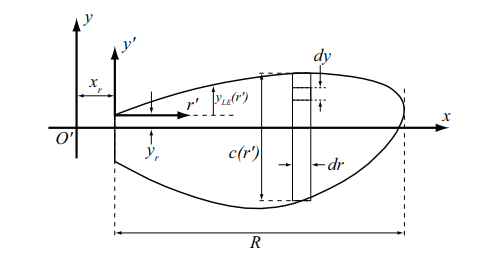



In [ ]:
class WingShape:
    def __init__(self, R, AR, y_hat__r):
        #R is the projected distance along the r'-axis from the wing root to the most distal point on the wing
        #AR is the aspect ratio of the wing
        #r_hat is the nondimensional radial distance defined as r'/R
        #C_hat is the nondimensional chord profile defined as chord/chord_mean
        #C_hat__r_hat is the non dimensional chord profile as a function of the nondimensional radial distance r_hat
        #Y_LE_hat is the non dimensional leading edge profile defined as Y_LE/chord_mean
        #Y_LE_hat__r_hat is the nondimensional leading edge profile as a function of the nondimensional radial distance r_hat

        self.R = R                          #projected distance along the r'-axis from the wing root to the most distal point on the wing
        self.AR = AR                       #Aspect Ratio of the wing
        self.C_mean = self.R / self.AR  #area of one wing divided by wing length
        self.rhat2()
        self.rhatM()
        self.S = self.R * self.C_mean
        self.y_hat__r = y_hat__r



    def chord_f(self, r):
        if self.wing_shape == 'rectangle':
            return self.max_chord                                            #rectangle wing
        elif self.wing_shape == 'ellipse':
            return self.max_chord*np.sqrt(1-r**2/(self.wing_length**2))           #ellipse wing


    def C_hat__r_hat(self, r_hat):
        C_hat = 1               #for rectangular wing
        #C_hat = np.abs((-0.01305/self.C_mean-(-0.09525/self.C_mean))*r_hat - 0.09525/self.C_mean)          #(end_chord_length/C_mean-front_chord_length/C_mean)*r_hat - front_chord_length/C_mean
        #C_hat = np.abs(2*r_hat - 2)
        #C_hat = np.abs(1*r_hat - 1.5)
        return C_hat

    def Y_LE_hat__r_hat(self, r_hat):
        Y_LE_hat = 0.25     #rectangle
        Y_LE_hat = 0.0
        return Y_LE_hat

    def rhat2(self):
        rhat2 = 0
        for i in range(1000):
            deltar = 1/1000
            rhat2 = rhat2 + ((i+0.5)*deltar)**2 * self.C_hat__r_hat((i+0.5)*deltar) * deltar
        self.rhat2 = np.sqrt(rhat2)

    def rhatM(self):
        rhatM = 0
        for i in range(1000):
            deltar = 1/1000
            rhatM = rhatM + ((i+1)*deltar)**2 * (self.C_hat__r_hat((i+1)*deltar))**2 * deltar
        self.rhatM = np.sqrt(rhatM)



#Wing Dynamics Class

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.close('all')

class WingDynamics:
    def __init__(self, side, Wingshape, num_elements=num_elements, glide=False, time_step=t_step, \
                 v0=v_free_stream, freq=freq, \
                 phi_amplitude=phi_amplitude, theta_amplitude=theta_amplitude, \
                 beta=beta, phi=phi_start, psi=psi_start, theta=theta_start, \
                 phi_dot=0, psi_dot=0, theta_dot=0, \
                 phi_0=phi0, psi0=psi0, theta0=theta0):
        self._state = np.array([[0],    # (x-pos) [0]
                               [0],     # (y-pos) [1]
                               [0],     # (z-pos) [2]
                               [v0.item(0)],     # (u) [3]
                               [v0.item(1)],     # (v) [4]
                               [v0.item(2)],     # (w) [5]
                               [beta],     # (beta) angle to stroke plane [6]
                               [phi],     # (phi) causes flapping motion [7]
                               [psi],     # (psi) deviation angle [8]
                               [theta],      # (theta) rotation angle[9]
                               [phi_dot],      # (phi_dot) [10]
                               [psi_dot],      # (psi_dot) [11]
                               [theta_dot]])     # (theta_dot) [12]
        self.side = side
        self.Wingshape = Wingshape
        self.time_step = time_step
        self.num_elements = num_elements

        self.freq = freq
        self.phi_amplitude = phi_amplitude
        self.theta_amplitude = theta_amplitude
        self.phi0 = phi0         #mean stroke angle
        self.theta0 = theta0     #mean rotation angle
        self.psi0 = psi0     #mean deviation angle


        self._state[10][0] = -self.phi_amplitude*2*np.pi*self.freq*np.cos(2*np.pi*self.freq*0 + np.pi/2 )                                                                       #derivative of phi function at t=t_period
        self._state[12][0] = 2*np.pi*self.theta_amplitude*C_alpha*self.freq * (np.tanh(C_alpha))**(-1) * np.cos(2*np.pi*self.freq*0) * (np.cosh(-C_alpha*np.sin(2*np.pi*self.freq*0))**-2)     #derivative of theta function at t=t_period

        self.u_inf = np.sqrt(self._state.item(3)**2 + self._state.item(4)**2 + self._state.item(5)**2)
        self.J = self.u_inf/(2*(2*self.phi_amplitude)*self.Wingshape.R*self.freq)

        self.V_W_inflow_prev = np.zeros((self.num_elements, 3, 1))

        self.glide = glide
        if self.glide == True:
            self._state[10][0] = 0
            self._state[11][0] = 0
            self._state[12][0] = 0


    def update(self, time):
        if self.glide == False:
            w = 2*np.pi*self.freq

            new_stroke = self.phi0 - self.phi_amplitude*np.sin(2*np.pi*self.freq*time + np.pi/2)#-np.pi/2)
            #new_stroke = 0.1192  + -0.3018*np.cos(w*time) + -0.3905*np.sin(w*time) + -0.01042*np.cos(2*w*time) + -0.02967*np.sin(2*w*time) + -0.002753*np.cos(3*w*time) + -0.001312*np.sin(3*w*time)
            #https://www.mdpi.com/2226-4310/3/3/23

            C_alpha = 2.6
            new_pitch = self.theta0 - self.theta_amplitude/(np.tanh(C_alpha))*np.tanh(C_alpha*np.sin(2*np.pi*self.freq*time -np.pi/2 +np.pi -np.pi/2 + np.pi))           #taken from Bhatti
            #new_pitch = -0.09502  + -0.5728*np.cos(w*time) + -0.479*np.sin(w*time) + -0.01803*np.cos(2*w*time) + -0.0364*np.sin(2*w*time) + -0.1374*np.cos(3*w*time) + -0.1374*np.sin(3*w*time)

            new_deviation = self.psi0
            self._state[10][0] = (new_stroke - self._state[7][0])/self.time_step
            self._state[11][0] = (new_deviation - self._state[8][0])/self.time_step
            self._state[12][0] = (new_pitch - self._state[9][0])/self.time_step

            self._state[7][0] = new_stroke
            self._state[8][0] = new_deviation
            self._state[9][0] = new_pitch
        else:
            self._state[10][0] = 0
            self._state[11][0] = 0
            self._state[12][0] = 0

            self._state[7][0] = self._state.item(7)
            self._state[8][0] = self._state.item(8)
            self._state[9][0] = self._state.item(9)

    def update_initial_angle(self, time, stroke_offset, pitch_offset):
        if self.glide == False:
            w = 2*np.pi*self.freq

            new_stroke = self.phi0 - self.phi_amplitude*np.sin(2*np.pi*self.freq*time + np.pi/2 - stroke_offset)
            #new_stroke = 0.1192  + -0.3018*np.cos(w*time) + -0.3905*np.sin(w*time) + -0.01042*np.cos(2*w*time) + -0.02967*np.sin(2*w*time) + -0.002753*np.cos(3*w*time) + -0.001312*np.sin(3*w*time)
            #https://www.mdpi.com/2226-4310/3/3/23

            C_alpha = 2.6
            new_pitch = self.theta0 - self.theta_amplitude/(np.tanh(C_alpha))*np.tanh(C_alpha*np.sin(2*np.pi*self.freq*time + np.pi - pitch_offset))           #taken from Bhatti
            #new_pitch = -0.09502  + -0.5728*np.cos(w*time) + -0.479*np.sin(w*time) + -0.01803*np.cos(2*w*time) + -0.0364*np.sin(2*w*time) + -0.1374*np.cos(3*w*time) + -0.1374*np.sin(3*w*time)

            new_deviation = self.psi0
            self._state[10][0] = (new_stroke - self._state[7][0])/self.time_step
            self._state[11][0] = (new_deviation - self._state[8][0])/self.time_step
            self._state[12][0] = (new_pitch - self._state[9][0])/self.time_step

            self._state[7][0] = new_stroke
            self._state[8][0] = new_deviation
            self._state[9][0] = new_pitch
        else:
            self._state[10][0] = 0
            self._state[11][0] = 0
            self._state[12][0] = 0

            self._state[7][0] = self._state.item(7)
            self._state[8][0] = self._state.item(8)
            self._state[9][0] = self._state.item(9)

    def get_aero_coeff(self, r):
        self.u_inf = self._state.item(3)#np.sqrt(self._state.item(3)**2 + self._state.item(4)**2 + self._state.item(5)**2)
        self.J = self.u_inf/(2 * (2*self.phi_amplitude) * self.Wingshape.R * self.freq)
        xhat_0 = self.Wingshape.Y_LE_hat__r_hat(r/self.Wingshape.R) + self.Wingshape.y_hat__r      #=x/c where x is the distance between the leading edge and the wing pitching axis
        K_PL = -2.109*((self.J + self.Wingshape.rhat2)**-0.606) + 4.136
        K_VL = 2.659*((self.J + self.Wingshape.rhat2)**-0.666) + -0.344
        K_PD = -0.182*((self.J + self.Wingshape.rhat2)**-2.414) + 1.370
        K_VD = 0.765*((self.J + self.Wingshape.rhat2)**-1.497) + 2.078
        K_PM = 0.803*((self.J + self.Wingshape.rhatM)**-0.972) + -0.363
        K_VM = -0.242*((self.J + self.Wingshape.rhatM)**-1.354) + -0.554

        alpha = self.alpha
        # if alpha>np.radians(90):
        #     alpha = -np.pi + alpha
        #CL = K_PL*np.sin(self.alpha)*(np.cos(self.alpha)**2) + K_VL*(np.sin(self.alpha)**2)*np.cos(self.alpha)
        #CD = K_PD*(np.sin(self.alpha)**2)*np.cos(self.alpha) + K_VD*(np.sin(self.alpha)**3)
        #CM = K_PM*(np.sin(self.alpha)**2)*np.cos(self.alpha) + K_VM*(np.sin(self.alpha)**2)
        CL = K_PL*np.sin(alpha)*(np.cos(alpha)**2) + K_VL*(np.sin(alpha)**2)*np.cos(alpha)
        CD = K_PD*(np.sin(alpha)**2)*np.cos(alpha) + K_VD*(np.sin(alpha)**3)
        CM = K_PM*(np.sin(alpha)**2)*np.cos(alpha) + K_VM*(np.sin(alpha)**2)
        CR = np.pi*(0.75-xhat_0)
        CA = np.pi/8
        return CL, CD, CM, CR, CA

    def force_calc(self):
        beta = self._state.item(6)
        phi = self._state.item(7)
        psi = self._state.item(8)
        theta = self._state.item(9)
        phi_dot = self._state.item(10)
        psi_dot = self._state.item(11)
        theta_dot = self._state.item(12)

        if self.side == 'right':              #side when looking at fwmav, (side along negative y axis)
            #Dont know if all these should be negatives
            phi = -phi
            phi_dot = -phi_dot
            theta = theta
            theta_dot = theta_dot
            psi = -psi
            psi_dot = -psi_dot

        R_BW = R_theta(theta) @ R_psi(psi) @ R_phi(phi) @ R_beta(beta)

        #convention for naming: V_W_body is velocity of the body expressed in the wing frame (W)
        V_W_body = R_BW @ self._state[3:6]      #rotation @ body velocity
        omega_W_wing = np.array([[0], [theta_dot], [0]]) + R_theta(theta) @ np.array([[psi_dot], [0], [0]]) + R_theta(theta) @ R_psi(psi) @ np.array([[0], [0], [phi_dot]])
        if self.glide == False:
            #omega_W_wing = np.array([[0], [theta_dot], [0]]) + R_theta(theta) @ np.array([[psi_dot], [0], [0]]) + R_theta(theta) @ R_psi(psi) @ np.array([[0], [0], [phi_dot]])
            F_W_trans = np.array([[0],[0],[0]])
            F_W_rot = np.array([[0],[0],[0]])
            F_W_added = np.array([[0],[0],[0]])

            M_W_trans = np.array([[0],[0],[0]])
            M_W_rot = np.array([[0],[0],[0]])
            M_W_added = np.array([[0],[0],[0]])

            for i in range(self.num_elements):
                #aero calculations
                delta_r = self.Wingshape.R/self.num_elements
                if self.side == 'left':                                            #side when looking at fwmav, (side along positive y axis)
                    r_W_i = np.array([[0], [(i+0.5)*delta_r], [0]])                 #distance from wing pivot to i-th blade element
                    chord_i = self.Wingshape.C_hat__r_hat(r_W_i.item(1)/self.Wingshape.R)*self.Wingshape.C_mean

                    V_W_inflow = V_W_body + np.cross(omega_W_wing.T, r_W_i.T).T
                    V_W_i = np.array([[1, 0, 0],[0, 0, 0],[0, 0, 1]]) @ V_W_inflow
                    chat_W_i = np.array([[0], [0], [-1]])                   #c hat in Wing frame for element i

                    #a_W_i_inflow = (V_W_inflow - self.V_W_inflow_prev[i])/self.time_step        #acceleration of center of blade element (derivative of velocity)
                    #self.V_W_inflow_prev[i,:] = V_W_inflow
                    V_W_COP = np.array([[1, 0, 0],[0, 0, 0],[0, 0, 1]]) @ (V_W_body + np.cross(omega_W_wing.T, np.array([[0], [self.Wingshape.rhat2*self.Wingshape.R], [0]]).T).T)
                    self.alpha_COP = np.arctan2((np.sqrt(np.cross(V_W_COP.T, chat_W_i.T) @ np.cross(V_W_COP.T, chat_W_i.T).T)),(V_W_COP.T @ chat_W_i))

                    self.alpha = np.arctan2((np.sqrt(np.cross(V_W_i.T, chat_W_i.T) @ np.cross(V_W_i.T, chat_W_i.T).T)),(V_W_i.T @ chat_W_i))
                    #self.alpha = np.arctan((np.sqrt(np.cross(V_W_i.T, chat_W_i.T) @ np.cross(V_W_i.T, chat_W_i.T).T))/(V_W_i.T @ chat_W_i))
                    #print(i, np.degrees(self.alpha), V_W_i)
                    CL, CD, CM, CR, CA = self.get_aero_coeff(r_W_i.item(1))
                    #calculate frames
                    i_W = np.array([[1], [0], [0]])
                    j_W = np.array([[0], [1], [0]])
                    c_i = (self.Wingshape.Y_LE_hat__r_hat(r_W_i.item(1)/self.Wingshape.R) - self.Wingshape.C_hat__r_hat(r_W_i.item(1)/self.Wingshape.R)/2) * self.Wingshape.C_mean          #distance from wing root axis to COM of element
                    s_W_i = np.array([[0], [np.dot(r_W_i.T, j_W).item(0)], [-c_i]])                                                                                                          #Location of center of blade element
                    lhat_W_i = (np.dot(V_W_i.T, i_W))/(np.sqrt(np.dot(V_W_i.T, i_W) * np.dot(V_W_i.T, i_W))) * np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]]) @ (V_W_i)/(np.sqrt(V_W_i.T @ V_W_i))
                    dhat_W_i = np.array([[-1, 0, 0], [0, 0, 0], [0, 0, -1]]) @ (V_W_i)/(np.sqrt(V_W_i.T @ V_W_i))

                    V_W_inflow_s = V_W_body + np.cross(omega_W_wing.T, s_W_i.T).T
                    a_W_i_inflow = (V_W_inflow_s - self.V_W_inflow_prev[i])/self.time_step        #acceleration of center of blade element (derivative of velocity)
                    self.V_W_inflow_prev[i,:] = V_W_inflow_s

                    F_W_trans_i = (CL* 0.5 * rho * (V_W_i.T @ V_W_i) * chord_i * delta_r) * lhat_W_i + (CD * 0.5 * rho * (V_W_i.T @ V_W_i) * chord_i * delta_r) * dhat_W_i
                    F_W_rot_i = (CR * rho * np.dot(omega_W_wing.T, j_W) * np.sqrt(V_W_i.T @ V_W_i) * chord_i**2 * delta_r) * i_W
                    F_W_added_i = (CA * rho * np.dot(a_W_i_inflow.T, i_W) * chord_i**2 * delta_r) * i_W

                    F_W_trans = F_W_trans + F_W_trans_i
                    F_W_rot = F_W_rot + F_W_rot_i
                    F_W_added = F_W_added + F_W_added_i
                    #print(self.side, CD, CL, chord_i * delta_r, chord_i**2 * delta_r)
                    #M_W_trans_i = np.sign(self._state.item(10))*(CM * 0.5 * rho * V_W_i.T @ V_W_i * chord_i**2 * delta_r) * j_W + np.cross(r_W_i.T, F_W_trans_i.T).T
                    M_W_trans_i = (CM * 0.5 * rho * V_W_i.T @ V_W_i * chord_i**2 * delta_r) * j_W + np.cross(r_W_i.T, F_W_trans_i.T).T
                    M_W_rot_i = np.cross(s_W_i.T, F_W_rot_i.T).T
                    M_W_added_i = np.cross(s_W_i.T, F_W_added_i.T).T

                    #print(np.sign(self._state.item(10))*(CM * 0.5 * rho * V_W_i.T @ V_W_i * chord_i**2 * delta_r) * j_W)
                    M_W_trans = M_W_trans + M_W_trans_i
                    M_W_rot = M_W_rot + M_W_rot_i
                    M_W_added = M_W_added + M_W_added_i

                    # if i==4:
                    #     print(np.degrees(self.alpha), CL, CD, V_W_i)

                elif self.side == 'right':
                    r_W_i = np.array([[0], [(i+0.5)*delta_r], [0]])
                    chord_i = self.Wingshape.C_hat__r_hat(r_W_i.item(1)/self.Wingshape.R)*self.Wingshape.C_mean

                    V_W_inflow = V_W_body + np.cross(omega_W_wing.T, -r_W_i.T).T
                    V_W_i = np.array([[1, 0, 0],[0, 0, 0],[0, 0, 1]]) @ V_W_inflow
                    chat_W_i = np.array([[0], [0], [-1]])                   #c hat in Wing frame for element i

                    #a_W_i_inflow = (V_W_inflow - self.V_W_inflow_prev[i])/self.time_step        #acceleration of center of blade element (derivative of velocity)
                    #self.V_W_inflow_prev[i,:] = V_W_inflow
                    V_W_COP = np.array([[1, 0, 0],[0, 0, 0],[0, 0, 1]]) @ (V_W_body + np.cross(omega_W_wing.T, -np.array([[0], [self.Wingshape.rhat2*self.Wingshape.R], [0]]).T).T)
                    self.alpha_COP = np.arctan2((np.sqrt(np.cross(V_W_COP.T, chat_W_i.T) @ np.cross(V_W_COP.T, chat_W_i.T).T)),(V_W_COP.T @ chat_W_i))

                    self.alpha = np.arctan2((np.sqrt(np.cross(V_W_i.T, chat_W_i.T) @ np.cross(V_W_i.T, chat_W_i.T).T)),(V_W_i.T @ chat_W_i))
                    #self.alpha = np.arctan((np.sqrt(np.cross(V_W_i.T, chat_W_i.T) @ np.cross(V_W_i.T, chat_W_i.T).T))/(V_W_i.T @ chat_W_i))
                    CL, CD, CM, CR, CA = self.get_aero_coeff(r_W_i.item(1))
                    #calculate frames
                    i_W = np.array([[1], [0], [0]])
                    j_W = np.array([[0], [1], [0]])
                    c_i = (self.Wingshape.Y_LE_hat__r_hat(r_W_i.item(1)/self.Wingshape.R) - self.Wingshape.C_hat__r_hat(r_W_i.item(1)/self.Wingshape.R)/2) * self.Wingshape.C_mean          #distance from pitching axis to COM of element
                    s_W_i = np.array([[0], [np.dot(-r_W_i.T, j_W).item(0)], [-c_i]])
                    lhat_W_i = (np.dot(V_W_i.T, i_W))/(np.sqrt(np.dot(V_W_i.T, i_W) * np.dot(V_W_i.T, i_W))) * np.array([[0, 0, 1], [0, -1, 0], [-1, 0, 0]]) @ (V_W_i)/(np.sqrt(V_W_i.T @ V_W_i))
                    dhat_W_i = np.array([[-1, 0, 0], [0, 0, 0], [0, 0, -1]]) @ (V_W_i)/(np.sqrt(V_W_i.T @ V_W_i))

                    V_W_inflow_s = V_W_body + np.cross(omega_W_wing.T, s_W_i.T).T
                    a_W_i_inflow = (V_W_inflow_s - self.V_W_inflow_prev[i])/self.time_step        #acceleration of center of blade element (derivative of velocity)
                    self.V_W_inflow_prev[i,:] = V_W_inflow_s

                    F_W_trans_i = (CL* 0.5 * rho * (V_W_i.T @ V_W_i) * chord_i * delta_r) * lhat_W_i + (CD * 0.5 * rho * (V_W_i.T @ V_W_i) * chord_i * delta_r) * dhat_W_i
                    F_W_rot_i = (CR * rho * np.dot(omega_W_wing.T, j_W) * np.sqrt(V_W_i.T @ V_W_i) * chord_i**2 * delta_r) * i_W
                    F_W_added_i = (CA * rho * np.dot(a_W_i_inflow.T, i_W) * chord_i**2 * delta_r) * i_W

                    F_W_trans = F_W_trans + F_W_trans_i
                    F_W_rot = F_W_rot + F_W_rot_i
                    F_W_added = F_W_added + F_W_added_i

                    #print(self.side, F_W_added_i.item(0), F_W_added_i.item(2), r_W_i.item(1))
                    #M_W_trans_i = np.sign(self._state.item(10))*(CM * 0.5 * rho * V_W_i.T @ V_W_i * chord_i**2 * delta_r) * j_W + np.cross(-r_W_i.T, F_W_trans_i.T).T
                    M_W_trans_i = (CM * 0.5 * rho * V_W_i.T @ V_W_i * chord_i**2 * delta_r) * j_W + np.cross(-r_W_i.T, F_W_trans_i.T).T
                    M_W_rot_i = np.cross(s_W_i.T, F_W_rot_i.T).T
                    M_W_added_i = np.cross(s_W_i.T, F_W_added_i.T).T

                    M_W_trans = M_W_trans + M_W_trans_i
                    M_W_rot = M_W_rot + M_W_rot_i
                    M_W_added = M_W_added + M_W_added_i

            #print(F_W_added, F_W_rot, F_W_trans)
            F_W = F_W_trans + F_W_rot + F_W_added
            M_W = M_W_trans + M_W_rot + M_W_added

            F_B = R_BW.T @ F_W
            M_B = R_BW.T @ M_W


            return np.array([[F_B.item(0), F_B.item(1), F_B.item(2), M_B.item(0), M_B.item(1), M_B.item(2)]]).T
        elif self.glide == True:
            chat_W_i = np.array([[0], [0], [-1]])                   #c hat in Wing frame for element i
            #omega_W_wing = np.array([[0], [theta_dot], [0]]) + R_theta(theta) @ np.array([[psi_dot], [0], [0]]) + R_theta(theta) @ R_psi(psi) @ np.array([[0], [0], [phi_dot]])

            delta_r = self.Wingshape.R
            r_W_i = np.array([[0], [self.Wingshape.rhat2*delta_r], [0]])                 #distance from wing pivot to i-th blade element
            #chord_i = self.Wingshape.C_hat__r_hat(r_W_i.item(1))*self.Wingshape.C_mean
            if self.side == 'left':                                            #side when looking at fwmav, (side along positive y axis)
                 V_W_inflow = V_W_body + np.cross(omega_W_wing.T, r_W_i.T).T                 #distance from wing pivot to i-th blade element
            elif self.side == 'right':
                 V_W_inflow = V_W_body + np.cross(omega_W_wing.T, -r_W_i.T).T
            V_W_i = np.array([[1, 0, 0],[0, 0, 0],[0, 0, 1]]) @ V_W_inflow
            #print(V_W_i)
            if (V_W_i.T @ chat_W_i) == 0:
                self.alpha_COP = np.pi/2
            else:
                self.alpha_COP = np.arctan((np.sqrt(np.cross(V_W_i.T, chat_W_i.T) @ np.cross(V_W_i.T, chat_W_i.T).T))/(V_W_i.T @ chat_W_i))
                #self.alpha_COP = np.arctan2((np.sqrt(np.cross(V_W_i.T, chat_W_i.T) @ np.cross(V_W_i.T, chat_W_i.T).T)),(V_W_i.T @ chat_W_i))
            self.alpha_COP = np.arctan2(V_W_i.item(0),-V_W_i.item(2))

            q_dynamic = 0.5 * rho * (V_W_body[0] ** 2 + V_W_body[2] ** 2) * self.Wingshape.S

            # Sigma --> Blending Function
            sigma_num = (1 + np.exp(-M*(self.alpha_COP - alpha0)) + np.exp(M*(self.alpha_COP + alpha0)))
            sigma_denom = (1 + np.exp(-M*(self.alpha_COP - alpha0))) * (1 + np.exp(M*(self.alpha_COP + alpha0)))
            sigma = sigma_num / sigma_denom

            CL_0 = 0 #0.23
            CL_alpha = np.pi*self.Wingshape.AR/(1+np.sqrt(1 + (self.Wingshape.AR/2)**2))
            CD_alpha = ((CL_0 + CL_alpha*self.alpha_COP)**2)/(np.pi*e*self.Wingshape.AR)

            CL = ((1 - sigma)*(CL_0 + CL_alpha*self.alpha_COP)) + ((sigma)*2*np.sign(self.alpha_COP)*(np.sin(self.alpha_COP)**2)*np.cos(self.alpha_COP))
            CD = CD_alpha

            f_lift = CL * q_dynamic
            f_drag = CD * q_dynamic
            fz = f_drag * np.cos(self.alpha_COP) + (-f_lift * np.sin(self.alpha_COP))
            fx = (-f_drag * np.sin(self.alpha_COP) + (-f_lift * np.cos(self.alpha_COP)))

            F_W = np.array([[fx.item(0)],[0],[fz.item(0)]])
            M_W = np.array([[0],[0],[0]])
            F_B = R_BW.T @ F_W
            M_B = R_BW.T @ M_W


            return np.array([[F_B.item(0), F_B.item(1), F_B.item(2), M_B.item(0), M_B.item(1), M_B.item(2)]]).T



def R_theta(theta):
    c_theta = np.cos(theta)
    s_theta = np.sin(theta)
    return np.array([[c_theta, 0, -s_theta],
                        [0, 1, 0],
                        [s_theta, 0, c_theta]])
def R_psi(psi):
    c_psi = np.cos(psi)
    s_psi = np.sin(psi)
    return np.array([[1, 0, 0],
                      [0, c_psi, -s_psi],
                      [0, s_psi, c_psi]])
def R_phi(phi):
    c_phi = np.cos(phi)
    s_phi = np.sin(phi)
    return np.array([[c_phi, s_phi, 0],
                      [-s_phi, c_phi, 0],
                      [0, 0, 1]])
def R_beta(beta):
    c_beta = np.cos(beta)
    s_beta = np.sin(beta)
    return np.array([[c_beta, 0, s_beta],
                        [0, 1, 0],
                        [-s_beta, 0, c_beta]])

#Tail forces

In [ ]:
def aero_force_tail(t, theta, xdot, ydot, thetadot):
    # Ensure that all inputs are NumPy arrays
    t = np.array(t)
    theta = np.array(theta)
    xdot = np.array(xdot)
    ydot = np.array(ydot)
    thetadot = np.array(thetadot)

    # Calculate tail_xdot and tail_ydot for arrays
    tail_ydot = ydot + thetadot * r_tail * np.cos(theta)
    tail_xdot = xdot + thetadot * r_tail * -np.sin(theta)
    #print(f"velocity: {tail_xdot} and {tail_ydot}")
    # Handle the case when theta is an array
    if theta.size > 1:
        theta = np.where(theta > 0, theta % (2 * np.pi), theta % (-2 * np.pi))
    else:
        if np.sign(theta) == 1:
            theta = theta % (2 * np.pi)
        else:
            theta = theta % (-2 * np.pi)

    alpha = theta - np.arctan2(tail_ydot, tail_xdot) - angle_tail
    if alpha.size > 1:
        alpha = np.where(alpha > 0, alpha % (2 * np.pi), alpha % (-2 * np.pi))
    else:
        if np.sign(alpha) == 1:
            alpha = alpha % (2 * np.pi)
        else:
            alpha = alpha % (-2 * np.pi)
    #print(np.degrees([alpha, alpha1]))
    q_dynamic = 0.5 * rho * (tail_xdot ** 2 + tail_ydot ** 2) * S_tail

    # Sigma --> Blending Function
    sigma_num = (1 + np.exp(-M*(alpha - alpha0)) + np.exp(M*(alpha + alpha0)))
    sigma_denom = (1 + np.exp(-M*(alpha - alpha0))) * (1 + np.exp(M*(alpha + alpha0)))
    sigma = sigma_num / sigma_denom

    CL_0 = 0.0 #0.23
    CD_p = 0.0
    CL_alpha = np.pi*AR_tail/(1+np.sqrt(1 + (AR_tail/2)**2))
    CD_alpha = ((CL_0 + CL_alpha*alpha)**2)/(np.pi*e*AR_tail)


    CL = ((1 - sigma)*(CL_0 + CL_alpha*alpha)) + ((sigma)*2*np.sign(alpha)*(np.sin(alpha)**2)*np.cos(alpha))
    CD = CD_p + CD_alpha
    #CD = 1-np.cos(2*alpha)

    #CL = np.sin(2*alpha) #2 * np.pi * alpha
    #CD = 1-np.cos(2*alpha) #np.abs(1.28 * np.sin(alpha))
    f_lift = CL * q_dynamic
    f_drag = CD * q_dynamic
    fx_tail = (-f_drag * np.cos(alpha) + (f_lift * np.sin(alpha)))
    fy_tail = (f_drag * np.sin(alpha) + (f_lift * np.cos(alpha)))
    # fx_tail = (-f_drag * np.cos(alpha) + -(f_lift * np.sin(alpha)))
    # fy_tail = (-f_drag * np.sin(alpha) + (f_lift * np.cos(alpha)))
    fx = fx_tail*np.cos(angle_tail) + fy_tail*np.sin(angle_tail)
    fy = -fx_tail*np.sin(angle_tail) + fy_tail*np.cos(angle_tail)
    #print(f"Alpha: {np.degrees(alpha)}, Lift: {f_lift}, Drag: {f_drag}, fx_tail: {fx_tail}, fy_tail: {fy_tail}, fx: {fx}, fy: {fy}")


    # Handle the case when inputs were scalars
    if isinstance(t, (int, float)):
        return fx.item(), fy.item(), alpha.item()  # Convert scalars back to Python scalars
    else:
        return np.array([fx, fy, alpha])  # Return NumPy arrays for arrays



#Body Forces

In [ ]:
def aero_force_body(t, theta, xdot, ydot, thetadot):
    # Ensure that all inputs are NumPy arrays
    t = np.array(t)
    theta = np.array(theta)
    xdot = np.array(xdot)
    ydot = np.array(ydot)
    thetadot = np.array(thetadot)

    body_ydot = ydot + thetadot * r_body * np.cos(theta)
    body_xdot = xdot + thetadot * r_body * -np.sin(theta)
    # Handle the case when theta is an array
    if theta.size > 1:
        theta = np.where(theta > 0, theta % (2 * np.pi), theta % (-2 * np.pi))
    else:
        if np.sign(theta) == 1:
            theta = theta % (2 * np.pi)
        else:
            theta = theta % (-2 * np.pi)

    alpha = theta - np.arctan2(body_ydot, body_xdot)
    if alpha.size > 1:
        alpha = np.where(alpha > 0, alpha % (2 * np.pi), alpha % (-2 * np.pi))
    else:
        if np.sign(alpha) == 1:
            alpha = alpha % (2 * np.pi)
        else:
            alpha = alpha % (-2 * np.pi)
    #print(np.degrees([alpha, alpha1]))
    q_dynamic = 0.5 * rho * (body_xdot ** 2 + body_ydot ** 2) * S_body

    # Sigma --> Blending Function
    sigma_num = (1 + np.exp(-M*(alpha - alpha0)) + np.exp(M*(alpha + alpha0)))
    sigma_denom = (1 + np.exp(-M*(alpha - alpha0))) * (1 + np.exp(M*(alpha + alpha0)))
    sigma = sigma_num / sigma_denom

    CL_0 = 0.00 #0.23
    CD_p = 0.00
    CL_alpha = np.pi*AR_body/(1+np.sqrt(1 + (AR_body/2)**2))
    CD_alpha = ((CL_0 + CL_alpha*alpha)**2)/(np.pi*e*AR_body)


    CL = ((1 - sigma)*(CL_0 + CL_alpha*alpha)) + ((sigma)*2*np.sign(alpha)*(np.sin(alpha)**2)*np.cos(alpha))
    CD = CD_p + CD_alpha
    #CD = 1-np.cos(2*alpha)

    #CL = np.sin(2*alpha) #2 * np.pi * alpha
    #CD = 1-np.cos(2*alpha) #np.abs(1.28 * np.sin(alpha))
    f_lift = CL * q_dynamic
    f_drag = CD * q_dynamic
    fx = (-f_drag * np.cos(alpha) + (f_lift * np.sin(alpha)))
    fy = (f_drag * np.sin(alpha) + (f_lift * np.cos(alpha)))
    #print(f"Tail {np.degrees(alpha+angle_tail)}, {fx}, {fy}")
    # Handle the case when inputs were scalars
    if isinstance(t, (int, float)):
        return fx.item(), fy.item(), alpha.item()  # Convert scalars back to Python scalars
    else:
        return np.array([fx, fy, alpha])  # Return NumPy arrays for arrays



#Derivatives function

In [ ]:
def f(t, state, tmp_left, tmp_right):
    dx_dt = [0, 0, 0, 0, 0, 0]          #xdot, ydot, thetadot, xddot, yddot, thetaddot
    x, y, theta, xdot, ydot, thetadot = state
    fx_aero_tail, fy_aero_tail, alpha_tail = aero_force_tail(t, theta, xdot, ydot, thetadot)
    fx_aero_body, fy_aero_body, alpha_body = aero_force_body(t, theta, xdot, ydot, thetadot)
    fx_aero = fx_aero_tail + fx_aero_body
    fy_aero = fy_aero_tail + fy_aero_body
    pin = False
    if pin == True:
        dx_dt[0] = 0
        dx_dt[1] = 0
        dx_dt[2] = 0
        dx_dt[3] = 0
        dx_dt[4] = 0
        dx_dt[5] = 0
    else:
        dx_dt[0] = xdot
        dx_dt[1] = ydot
        dx_dt[2] = thetadot
        dx_dt[3] = ((-(tmp_left + tmp_right).item(2) + fy_aero)*-np.sin(theta) + ((tmp_left + tmp_right).item(0) + fx_aero)*np.cos(theta))/m
        dx_dt[4] = (-m*g + (-(tmp_left + tmp_right).item(2) + fy_aero)*np.cos(theta) + ((tmp_left + tmp_right).item(0) + fx_aero)*np.sin(theta))/m
        dx_dt[5] = (r_wing*-(tmp_left + tmp_right).item(2) + r_tail*fy_aero_tail + r_body*fy_aero_body + (tmp_left + tmp_right).item(4))/(Jz*1)
    return np.array(dx_dt)

#Runge-Kutta Solver


In [ ]:
def runge_kutta(time_sim, current, tmp_left, tmp_right, delta_t):
    state= current
    K1 = delta_t*f(time_sim, state, tmp_left, tmp_right)
    K2 = delta_t*f(time_sim, state + 1/2*K1, tmp_left, tmp_right)
    K3 = delta_t*f(time_sim, state + 1/2*K2, tmp_left, tmp_right)
    K4 = delta_t*f(time_sim, state + 1*K3, tmp_left, tmp_right)
    state += (K1/6 + K2/3 + K3/3 + K4/6)
    return state

#Main

In [ ]:
tArr = np.zeros(int(num_periods*t_period/t_step))
alpha_Arr = np.zeros(int(num_periods*t_period/t_step))
results = np.zeros((int(num_periods*t_period/t_step), 6))
wing_force = np.zeros((int(num_periods*t_period/t_step), 2))
wing_moment = np.zeros((int(num_periods*t_period/t_step), 1))
wing_angles = np.zeros((int(num_periods*t_period/t_step), 3))
wing_angle_vel = np.zeros((int(num_periods*t_period/t_step), 3))

time_sim = 0
time_flapping = 0
i = 0

v0=3     #initial forward velocity in global frame
angle0= 0#-8    #inital theta

Wingshape = WingShape(wing_length, AR_wing, 0)
wing_left = WingDynamics(side='left', Wingshape=Wingshape, v0=np.array([[v0*np.cos(np.radians(angle0))], [-v0*np.sin(np.radians(angle0))], [0]]), glide=True, phi=0, phi_dot=0, theta=0, theta_dot=0)               #rectangle ellipse
wing_right = WingDynamics(side='right', Wingshape=Wingshape, v0=np.array([[v0*np.cos(np.radians(angle0))], [-v0*np.sin(np.radians(angle0))], [0]]), glide=True, phi=0, phi_dot=0, theta=0, theta_dot=0)

# wing_left = WingDynamics(side='left', Wingshape=Wingshape, v0=np.array([[v0], [0], [0]]), glide=False)               #rectangle ellipse
# wing_right = WingDynamics(side='right', Wingshape=Wingshape, v0=np.array([[v0], [0], [0]]), glide=False)


state = [0, 10, np.radians(angle0), v0, 0, 0]

wing_left._state[3][0] = (state[3]*np.cos(state[2]) + state[4]*np.sin(state[2]))
wing_left._state[4][0] = 0
wing_left._state[5][0] = -(state[4]*np.cos(state[2]) - state[3]*np.sin(state[2]) )#+ r_wing*state[5])

wing_right._state[3][0] = (state[3]*np.cos(state[2]) + state[4]*np.sin(state[2]))
wing_right._state[4][0] = 0
wing_right._state[5][0] = -(state[4]*np.cos(state[2]) - state[3]*np.sin(state[2]) )#+ r_wing*state[5])

wing_right.update(-2*t_step)
wing_left.update(-2*t_step)
#print(wing_left.V_W_inflow_prev)
tmp_left = wing_left.force_calc()
tmp_right = wing_right.force_calc()

wing_right.update(-t_step)
wing_left.update(-t_step)
#print(wing_left.V_W_inflow_prev)
tmp_left = wing_left.force_calc()
tmp_right = wing_right.force_calc()

wing_right.update(time_flapping)
wing_left.update(time_flapping)
#print(wing_left.V_W_inflow_prev)
tmp_left = wing_left.force_calc()
tmp_right = wing_right.force_calc()
#print(wing_left.V_W_inflow_prev)

while round(time_sim, 9) < round(num_periods*t_period, 9):
    results[i, :] = state
    if np.sign(state[2]) == 1:
        state[2] = state[2] % (2 * np.pi)
    else:
        state[2] = state[2] % (-2 * np.pi)

    wing_force[i, :] = [(tmp_left + tmp_right).item(0), -(tmp_left + tmp_right).item(2)]
    wing_moment[i, :] = [(tmp_left + tmp_right).item(4)]
    wing_angles[i, :] = [wing_left._state[7][0], wing_left._state[8][0], wing_left._state[9][0]]
    wing_angle_vel[i, :] = [wing_left._state[10][0], wing_left._state[11][0], wing_left._state[12][0]]

    tArr[i] = time_sim
    alpha_Arr[i] = wing_left.alpha_COP

    time_sim = time_sim + t_step
    if wing_left.glide == False:
        time_flapping = time_flapping + t_step
        if round(time_flapping, 8) >= round(t_period, 8):
            time_flapping = 0



    wing_left._state[3][0] = (state[3]*np.cos(state[2]) + state[4]*np.sin(state[2]))
    wing_left._state[4][0] = 0
    wing_left._state[5][0] = -(state[4]*np.cos(state[2]) - state[3]*np.sin(state[2]) )#+ r_wing*state[5])

    wing_right._state[3][0] = (state[3]*np.cos(state[2]) + state[4]*np.sin(state[2]))
    wing_right._state[4][0] = 0
    wing_right._state[5][0] = -(state[4]*np.cos(state[2]) - state[3]*np.sin(state[2]) )#+ r_wing*state[5])

    wing_right.update(time_flapping)
    wing_left.update(time_flapping)

    tmp_left = wing_left.force_calc()
    tmp_right = wing_right.force_calc()
    #print((state[3]*np.cos(state[2]) + state[4]*np.sin(state[2])))
    state = runge_kutta(time_sim, state, tmp_left, tmp_right, t_step)
    i+=1

In [ ]:
def simulation(x0, y0, angle0, vx0, vy0, omega0, stroke_offset, pitch_offset):
    tArr = np.zeros(int(num_periods*t_period/t_step))
    alpha_Arr = np.zeros(int(num_periods*t_period/t_step))
    results = np.zeros((int(num_periods*t_period/t_step), 6))
    wing_force = np.zeros((int(num_periods*t_period/t_step), 2))
    wing_moment = np.zeros((int(num_periods*t_period/t_step), 1))
    wing_angles = np.zeros((int(num_periods*t_period/t_step), 3))
    wing_angle_vel = np.zeros((int(num_periods*t_period/t_step), 3))

    time_sim = 0
    time_flapping = 0
    i = 0

    Wingshape = WingShape(wing_length, AR_wing, 0)
    # wing_left = WingDynamics(side='left', Wingshape=Wingshape, v0=np.array([[v0*np.cos(np.radians(angle0))], [-v0*np.sin(np.radians(angle0))], [0]]), glide=True, phi=0, phi_dot=0, theta=0, theta_dot=0)               #rectangle ellipse
    # wing_right = WingDynamics(side='right', Wingshape=Wingshape, v0=np.array([[v0*np.cos(np.radians(angle0))], [-v0*np.sin(np.radians(angle0))], [0]]), glide=True, phi=0, phi_dot=0, theta=0, theta_dot=0)

    wing_left = WingDynamics(side='left', Wingshape=Wingshape, v0=np.array([[vx0], [0], [-vy0]]), glide=False)               #rectangle ellipse
    wing_right = WingDynamics(side='right', Wingshape=Wingshape, v0=np.array([[vx0], [0], [-vy0]]), glide=False)


    state = [x0, y0, np.radians(angle0), vx0, vy0, omega0]

    wing_left._state[3][0] = (state[3]*np.cos(state[2]) + state[4]*np.sin(state[2]))
    wing_left._state[4][0] = 0
    wing_left._state[5][0] = -(state[4]*np.cos(state[2]) - state[3]*np.sin(state[2]) )#+ r_wing*state[5])

    wing_right._state[3][0] = (state[3]*np.cos(state[2]) + state[4]*np.sin(state[2]))
    wing_right._state[4][0] = 0
    wing_right._state[5][0] = -(state[4]*np.cos(state[2]) - state[3]*np.sin(state[2]) )#+ r_wing*state[5])

    wing_right.update_initial_angle(-2*t_step, stroke_offset, pitch_offset)
    wing_left.update_initial_angle(-2*t_step, stroke_offset, pitch_offset)
    #print(wing_left.V_W_inflow_prev)
    tmp_left = wing_left.force_calc()
    tmp_right = wing_right.force_calc()

    wing_right.update_initial_angle(-t_step, stroke_offset, pitch_offset)
    wing_left.update_initial_angle(-t_step, stroke_offset, pitch_offset)
    #print(wing_left.V_W_inflow_prev)
    tmp_left = wing_left.force_calc()
    tmp_right = wing_right.force_calc()

    wing_right.update_initial_angle(time_flapping, stroke_offset, pitch_offset)
    wing_left.update_initial_angle(time_flapping, stroke_offset, pitch_offset)
    #print(wing_left.V_W_inflow_prev)
    tmp_left = wing_left.force_calc()
    tmp_right = wing_right.force_calc()
    #print(wing_left.V_W_inflow_prev)

    while round(time_sim, 9) < round(num_periods*t_period, 9):
        results[i, :] = state
        if np.sign(state[2]) == 1:
            state[2] = state[2] % (2 * np.pi)
        else:
            state[2] = state[2] % (-2 * np.pi)

        wing_force[i, :] = [(tmp_left + tmp_right).item(0), -(tmp_left + tmp_right).item(2)]
        wing_moment[i, :] = [(tmp_left + tmp_right).item(4)]
        wing_angles[i, :] = [wing_left._state[7][0], wing_left._state[8][0], wing_left._state[9][0]]
        wing_angle_vel[i, :] = [wing_left._state[10][0], wing_left._state[11][0], wing_left._state[12][0]]

        tArr[i] = time_sim
        alpha_Arr[i] = wing_left.alpha_COP

        time_sim = time_sim + t_step
        if wing_left.glide == False:
            time_flapping = time_flapping + t_step
            if round(time_flapping, 8) >= round(t_period, 8):
                time_flapping = 0



        wing_left._state[3][0] = (state[3]*np.cos(state[2]) + state[4]*np.sin(state[2]))
        wing_left._state[4][0] = 0
        wing_left._state[5][0] = -(state[4]*np.cos(state[2]) - state[3]*np.sin(state[2]))# + r_wing*state[5])

        wing_right._state[3][0] = (state[3]*np.cos(state[2]) + state[4]*np.sin(state[2]))
        wing_right._state[4][0] = 0
        wing_right._state[5][0] = -(state[4]*np.cos(state[2]) - state[3]*np.sin(state[2]))# + r_wing*state[5])

        wing_right.update_initial_angle(time_flapping, stroke_offset, pitch_offset)
        wing_left.update_initial_angle(time_flapping, stroke_offset, pitch_offset)

        tmp_left = wing_left.force_calc()
        tmp_right = wing_right.force_calc()
        #print((state[3]*np.cos(state[2]) + state[4]*np.sin(state[2])))
        state = runge_kutta(time_sim, state, tmp_left, tmp_right, t_step)
        i+=1
    tail_force = aero_force_tail(tArr, results[:,2], results[:,3], results[:,4], results[:,5])
    return tArr, results, wing_force, tail_force, alpha_Arr

##Angles over a period

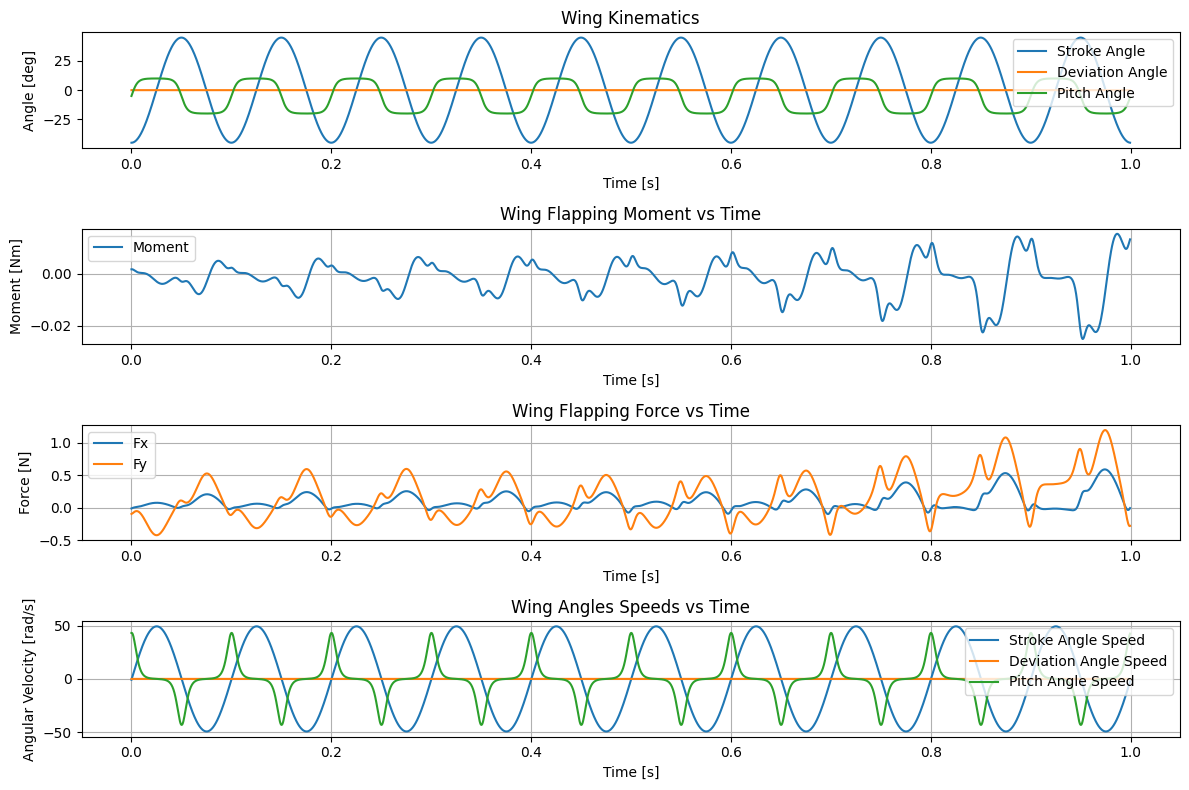

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.title("Wing Kinematics")
plt.plot(tArr, np.degrees(wing_angles[:, 0]), label="Stroke Angle")
plt.plot(tArr, np.degrees(wing_angles[:, 1]), label="Deviation Angle")
plt.plot(tArr, np.degrees(wing_angles[:, 2]), label="Pitch Angle")
# plt.plot(tArr, np.degrees(alpha_Arr), alpha=0.5, label="Alpha wing")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Angle [deg]")
# plt.grid()

plt.subplot(4, 1, 2)
plt.title("Wing Flapping Moment vs Time")
plt.plot(tArr, wing_moment[:, 0], label="Moment")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Moment [Nm]")
plt.grid()

plt.subplot(4, 1, 3)
plt.title("Wing Flapping Force vs Time")
plt.plot(tArr, wing_force[:, 0], label="Fx")
plt.plot(tArr, wing_force[:, 1], label="Fy")
# plt.plot(tArr, wing_force[:, 0]*-np.cos(alpha_Arr) + wing_force[:, 1]*np.sin(alpha_Arr), label="Wing Force Lift")
# plt.plot(tArr, wing_force[:, 0]*np.sin(alpha_Arr) + wing_force[:, 1]*np.cos(alpha_Arr), label="Wing Force Drag")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Force [N]")
plt.grid()

plt.subplot(4, 1, 4)
plt.title("Wing Angles Speeds vs Time")
plt.plot(tArr, (wing_angle_vel[:, 0]), label="Stroke Angle Speed")
plt.plot(tArr, (wing_angle_vel[:, 1]), label="Deviation Angle Speed")
plt.plot(tArr, (wing_angle_vel[:, 2]), label="Pitch Angle Speed")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Angular Velocity [rad/s]")
plt.grid()

plt.tight_layout()

In [ ]:
print(sum(wing_moment)/len(wing_moment))
print(sum(wing_force[:, 1])/len(wing_moment))
print(sum(wing_force[:, 0])/len(wing_moment))
print(wing_force[1, 1])
print(np.degrees(wing_angles[0, 0]))
print(wing_left.J, wing_left._state.item(3))
print(wing_left.Wingshape.rhat2, wing_left.Wingshape.S, wing_left.Wingshape.C_mean)

[-0.00275557]
0.005675162299949797
0.006973836127170304
-0.004955287082924222
-24.999999999999996
1.066565943275261 3.961290598675818
0.5773501970208376 0.007108923076923077 0.04676923076923077


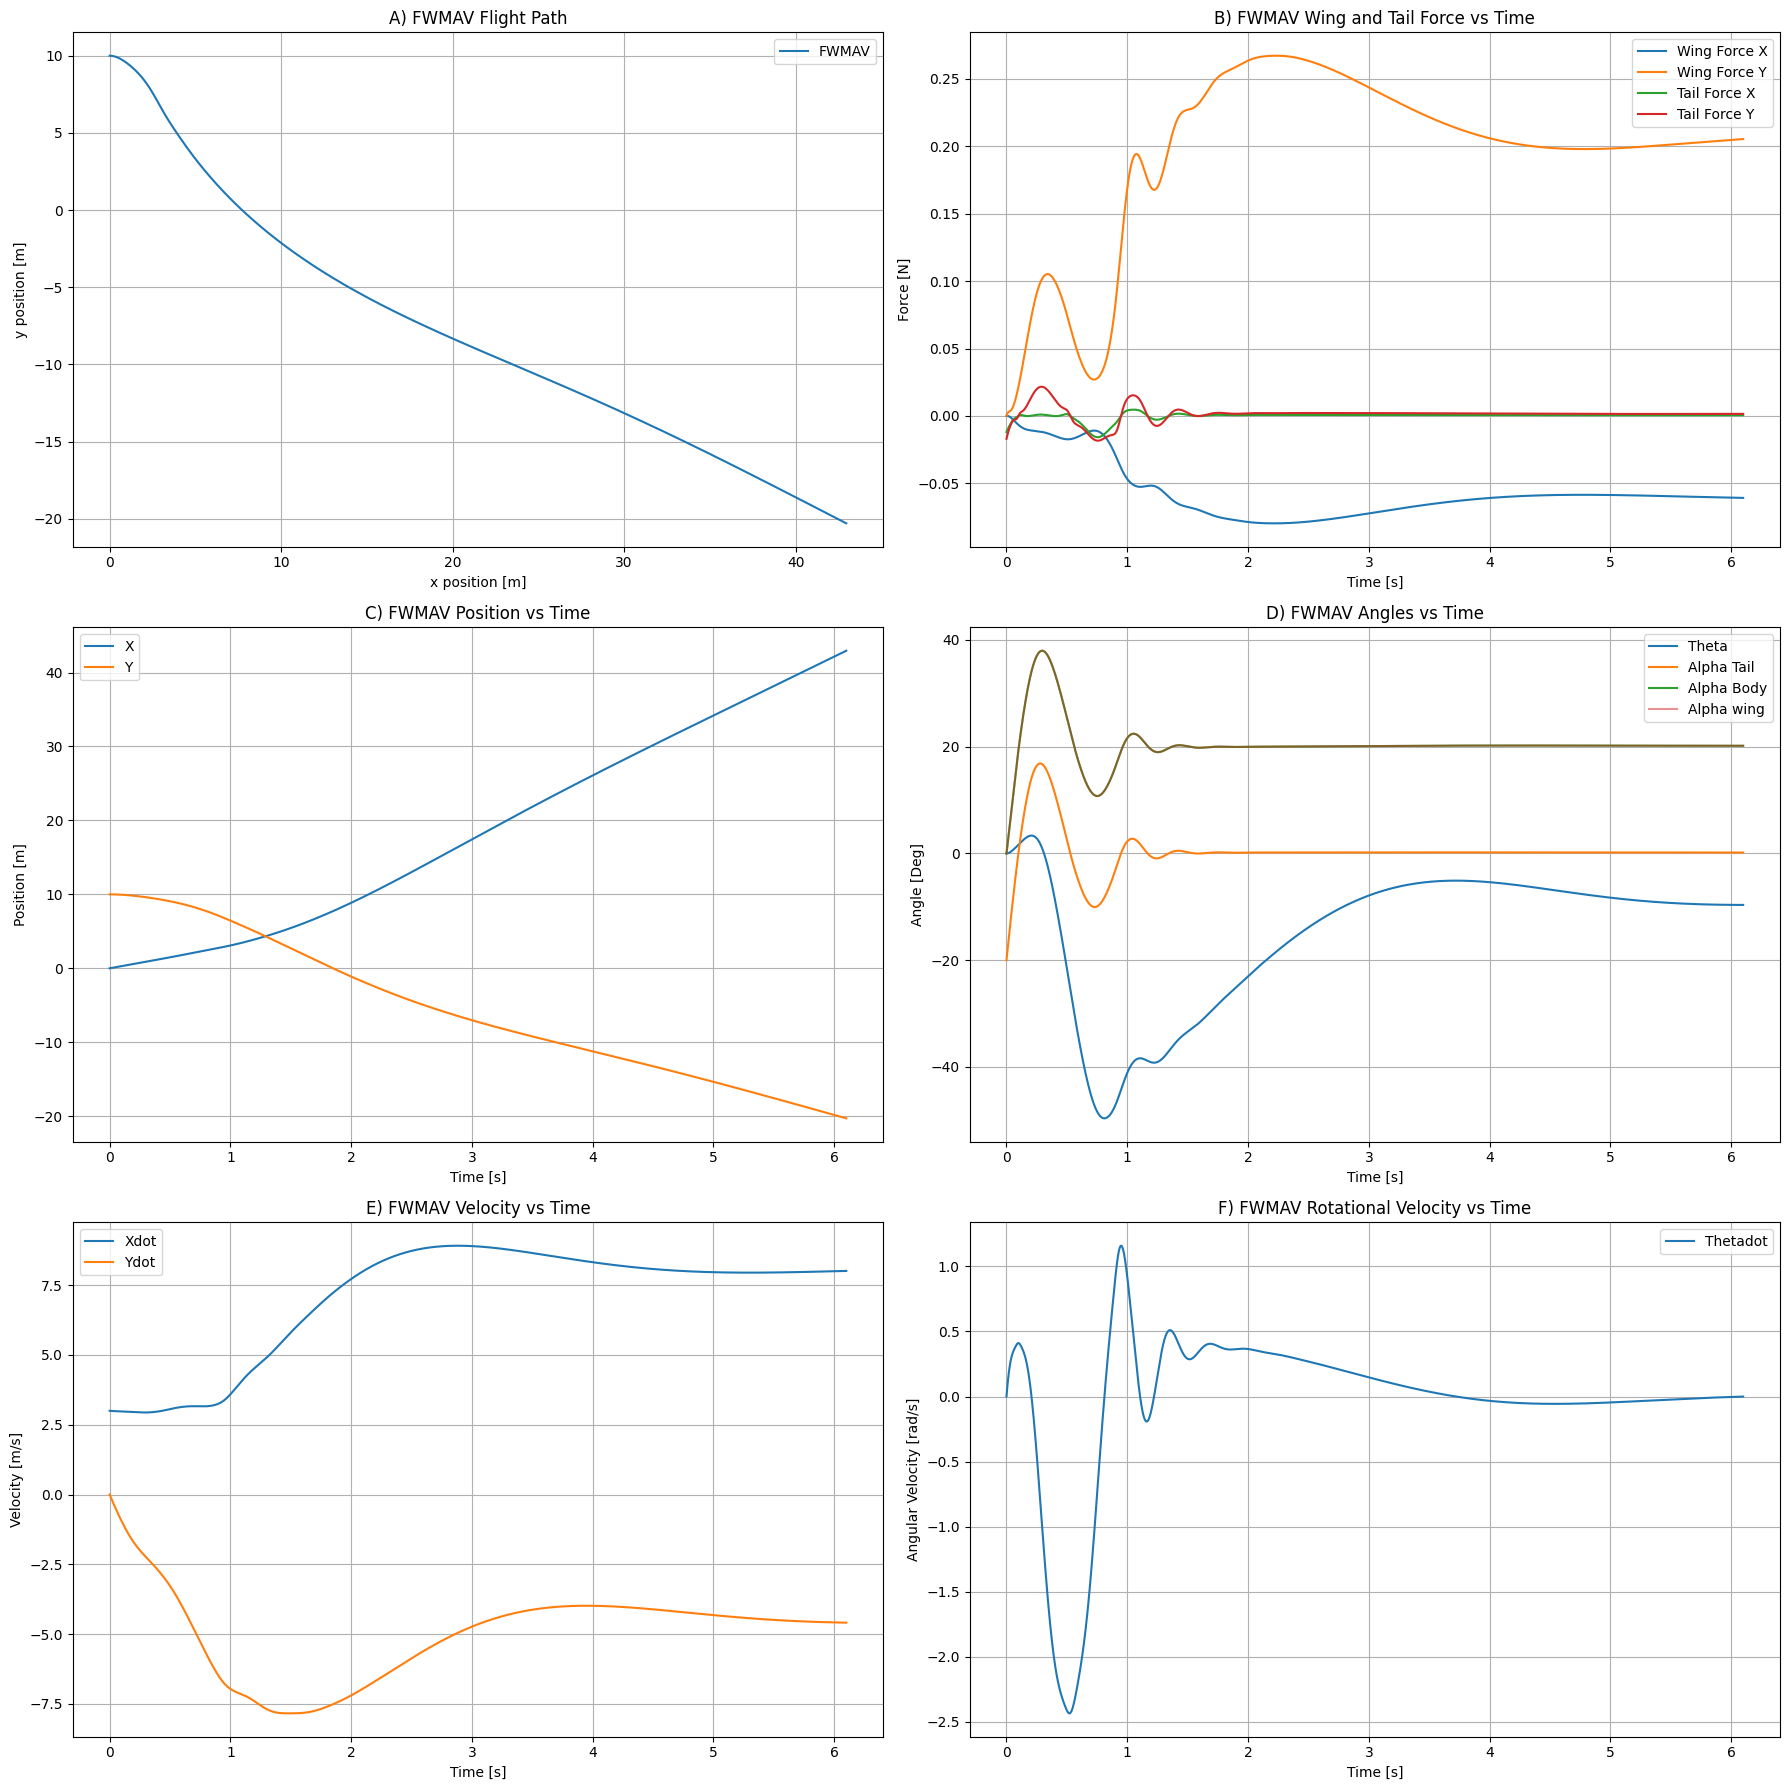

In [ ]:
def plot_figures(t, results, wing_force, tail_force):
    plt.figure(figsize=(18, 18))

    plt.subplot(3, 2, 1)
    plt.title("A) FWMAV Flight Path")
    plt.plot(results[:, 0], results[:, 1], label="FWMAV")
    plt.legend()
    plt.xlabel("x position [m]")
    plt.ylabel("y position [m]")
    plt.grid()

    plt.subplot(3, 2, 3)
    plt.title("C) FWMAV Position vs Time")
    plt.plot(t, results[:, 0], label="X")
    plt.plot(t, results[:, 1], label="Y")
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Position [m]")
    plt.grid()

    plt.subplot(3, 2, 5)
    plt.title("E) FWMAV Velocity vs Time")
    plt.plot(t, results[:, 3], label="Xdot")
    plt.plot(t, results[:, 4], label="Ydot")
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Velocity [m/s]")
    plt.grid()

    plt.subplot(3, 2, 4)
    plt.title("D) FWMAV Angles vs Time")
    plt.plot(t, np.degrees(results[:, 2]), label="Theta")
    plt.plot(t, np.degrees(tail_force[2, :]), label="Alpha Tail")
    #plt.plot(t, np.degrees(results[:, 2] - np.arctan2(results[:, 4] + results[:, 5]*r_tail*np.cos(results[:, 2]), results[:, 3] + -results[:, 5]*r_tail*np.sin(results[:, 2]))- angle_tail), label="Alpha tail")
    #plt.plot(t, np.degrees(results[:, 2] - np.arctan2(results[:, 4] + results[:, 5]*r_tail*np.cos(results[:, 2]), results[:, 3] + -results[:, 5]*r_tail*np.sin(results[:, 2]))), label="Alpha Body")
    plt.plot(t, np.degrees(results[:, 2] - np.arctan2(results[:, 4], results[:, 3])), label="Alpha Body")
    plt.plot(t, np.degrees(alpha_Arr), alpha=0.5, label="Alpha wing")
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Angle [Deg]")
    plt.grid()

    plt.subplot(3, 2, 6)
    plt.title("F) FWMAV Rotational Velocity vs Time")
    plt.plot(t, results[:, 5], label="Thetadot")
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Angular Velocity [rad/s]")
    plt.grid()

    plt.subplot(3, 2, 2)
    plt.title("B) FWMAV Wing and Tail Force vs Time")
    #plt.plot(result.t, np.degrees(result.y[2, :] - np.arctan2(-result.y[4, :], result.y[3, :])), label="Alpha")
    plt.plot(t, wing_force[:, 0], label="Wing Force X")
    plt.plot(t, wing_force[:, 1], label="Wing Force Y")
    plt.plot(t, tail_force[0, :], label="Tail Force X")
    plt.plot(t, tail_force[1, :], label="Tail Force Y")
    # plt.plot(t, wing_force[:, 0]*-np.cos(alpha_Arr) + wing_force[:, 1]*np.sin(alpha_Arr), label="Wing Force Lift")
    # plt.plot(t, wing_force[:, 0]*np.sin(alpha_Arr) + wing_force[:, 1]*np.cos(alpha_Arr), label="Wing Force Drag")
    # plt.plot(t, tail_force[0, :]*-np.cos(tail_force[2, :]) + tail_force[1, :]*np.sin(tail_force[2, :]), label="Tail Force Lift")
    # plt.plot(t, tail_force[0, :]*np.sin(tail_force[2, :]) + tail_force[1, :]*np.cos(tail_force[2, :]), label="Tail Force Drag")
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Force [N]")
    plt.grid()

    plt.tight_layout()
    plt.show()

tail_force = aero_force_tail(tArr, results[:,2], results[:,3], results[:,4], results[:,5])
plot_figures(tArr, results, wing_force, tail_force)

#Parameter Study

In [ ]:
baseline_tArr, baseline_results, baseline_wing_force, baseline_tail_force, baseline_alphaArr = simulation(2, np.degrees(0), 0, 1, 0, 0)

<ipython-input-10-84914217033e>:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha_Arr[i] = wing_left.alpha_COP


In [ ]:
lower_tArr, lower_results, lower_wing_force, lower_tail_force, lower_alphaArr = simulation(2, np.degrees(0), 0, 0, 0, 0)

<ipython-input-10-84914217033e>:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha_Arr[i] = wing_left.alpha_COP


In [ ]:
higher_tArr, higher_results, higher_wing_force, higher_tail_force, higher_alphaArr = simulation(2, np.degrees(0), 0, 0, 0, 0)

<ipython-input-10-84914217033e>:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha_Arr[i] = wing_left.alpha_COP


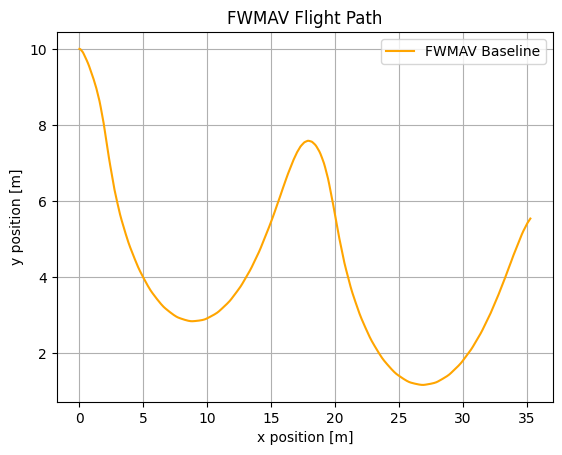

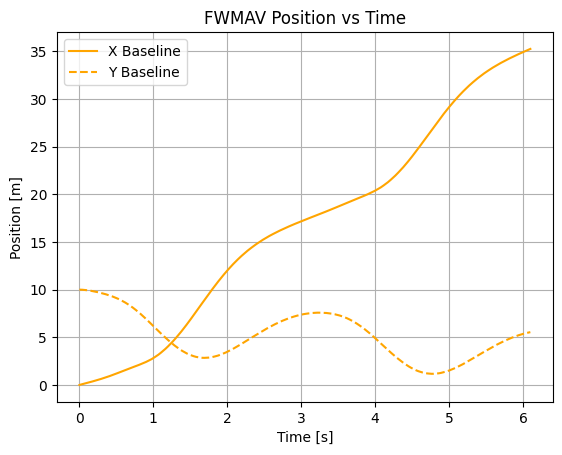

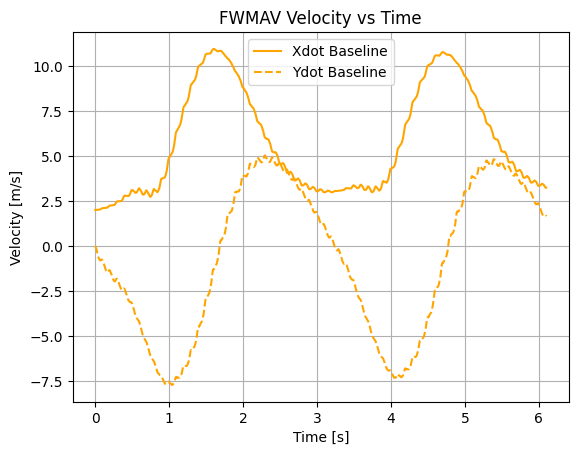

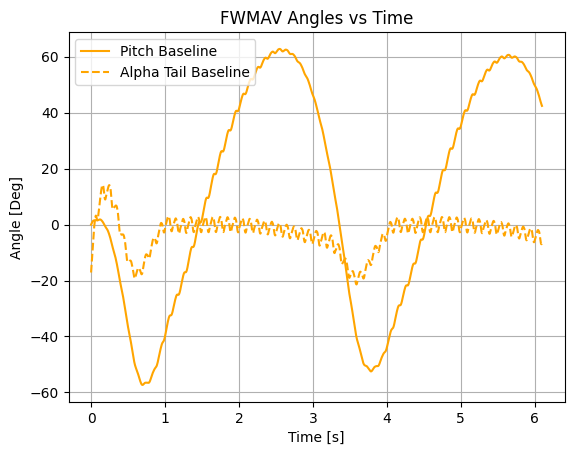

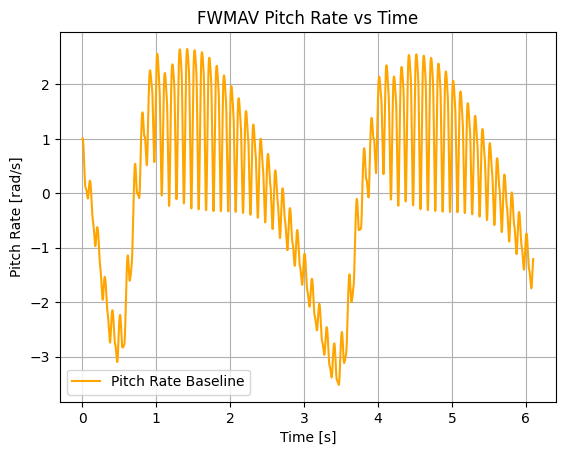

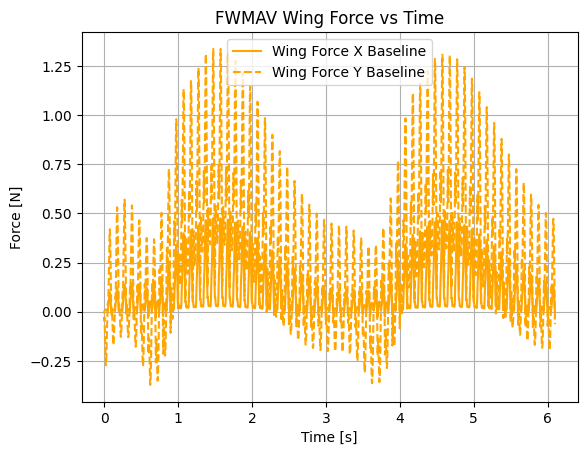

In [ ]:
plt.rcParams['text.usetex'] = False
# plt.figure(figsize=(18, 18))

# plt.subplot(3, 2, 1)
plt.title("FWMAV Flight Path")
plt.plot(baseline_results[:, 0], baseline_results[:, 1], label="FWMAV Baseline", color="orange")
# plt.plot(lower_results[:, 0], lower_results[:, 1], label="FWMAV Triangular", color='blue')
# plt.plot(higher_results[:, 0], higher_results[:, 1], label="FWMAV Trapezoidal", color='green')
plt.legend()
plt.xlabel("x position [m]")
plt.ylabel("y position [m]")
plt.grid()
plt.show()

# plt.subplot(3, 2, 3)
plt.title("FWMAV Position vs Time")
plt.plot(baseline_tArr, baseline_results[:, 0], label="X Baseline", color="orange")
# plt.plot(lower_tArr, lower_results[:, 0], label="X Triangular", color='blue')
# plt.plot(higher_tArr, higher_results[:, 0], label="X Trapezoidal", color='green')
plt.plot(baseline_tArr, baseline_results[:, 1], '--', label="Y Baseline", color="orange")
# plt.plot(lower_tArr, lower_results[:, 1], '--', label="Y Triangular", color='blue')
# plt.plot(higher_tArr, higher_results[:, 1], '--', label="Y Trapezoidal", color='green')
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.grid()
plt.show()

# plt.subplot(3, 2, 5)
plt.title("FWMAV Velocity vs Time")
# plt.plot(t, results[:, 3], label="Xdot")
# plt.plot(t, results[:, 4], label="Ydot")
plt.plot(baseline_tArr, baseline_results[:, 3], label="Xdot Baseline", color="orange")
# plt.plot(lower_tArr, lower_results[:, 3], label="Xdot Triangular", color='blue')
# plt.plot(higher_tArr, higher_results[:, 3], label="Xdot Trapezoidal", color='green')
plt.plot(baseline_tArr, baseline_results[:, 4], '--', label="Ydot Baseline", color="orange")
# plt.plot(lower_tArr, lower_results[:, 4], '--', label="Ydot Triangular", color='blue')
# plt.plot(higher_tArr, higher_results[:, 4], '--', label="Ydot Trapezoidal", color='green')
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Velocity [m/s]")
plt.grid()
plt.show()

# plt.subplot(3, 2, 4)
plt.title("FWMAV Angles vs Time")
plt.plot(baseline_tArr, np.degrees(baseline_results[:, 2]), label="Pitch Baseline", color="orange")
# plt.plot(lower_tArr, np.degrees(lower_results[:, 2]), label="Pitch Triangular", color='blue')
# plt.plot(higher_tArr, np.degrees(higher_results[:, 2]), label="Pitch Trapezoidal", color='green')
plt.plot(baseline_tArr, np.degrees(baseline_tail_force[2, :]), '--', label="Alpha Tail Baseline", color="orange")
# plt.plot(lower_tArr, np.degrees(lower_tail_force[2, :]), '--', label="Alpha Tail Triangular", color='blue')
# plt.plot(higher_tArr, np.degrees(higher_tail_force[2, :]), '--', label="Alpha Tail Trapezoidal", color='green')


#plt.plot(t, np.degrees(results[:, 2] - np.arctan2(results[:, 4] + results[:, 5]*r_tail*np.cos(results[:, 2]), results[:, 3] + -results[:, 5]*r_tail*np.sin(results[:, 2]))- angle_tail), label="Alpha tail")
#plt.plot(t, np.degrees(results[:, 2] - np.arctan2(results[:, 4] + results[:, 5]*r_tail*np.cos(results[:, 2]), results[:, 3] + -results[:, 5]*r_tail*np.sin(results[:, 2]))), label="Alpha Body")
# plt.plot(t, np.degrees(results[:, 2] - np.arctan2(results[:, 4], results[:, 3])), label="Alpha Body")
# plt.plot(t, np.degrees(alpha_Arr), alpha=0.5, label="Alpha wing")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Angle [Deg]")
plt.grid()
plt.show()

# plt.subplot(3, 2, 6)
plt.title("FWMAV Pitch Rate vs Time")
plt.plot(baseline_tArr, baseline_results[:, 5], label="Pitch Rate Baseline", color="orange")
# plt.plot(lower_tArr, lower_results[:, 5], label="Pitch Rate Triangular", color='blue')
# plt.plot(higher_tArr, higher_results[:, 5], label="Pitch Rate Trapezoidal", color='green')
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Pitch Rate [rad/s]")
plt.grid()
plt.show()

# plt.subplot(3, 2, 2)
plt.title("FWMAV Wing Force vs Time")
#plt.plot(result.t, np.degrees(result.y[2, :] - np.arctan2(-result.y[4, :], result.y[3, :])), label="Alpha")
plt.plot(baseline_tArr, baseline_wing_force[:, 0], label="Wing Force X Baseline", color="orange")
# plt.plot(lower_tArr, lower_wing_force[:, 0], label="Wing Force X Triangular", color='blue')
# plt.plot(higher_tArr, higher_wing_force[:, 0], label="Wing Force X Trapezoidal", color='green')
plt.plot(baseline_tArr, baseline_wing_force[:, 1], '--', label="Wing Force Y Baseline", color="orange")
# plt.plot(lower_tArr, lower_wing_force[:, 1], '--', label="Wing Force Y Triangular", color='blue')
# plt.plot(higher_tArr, higher_wing_force[:, 1], '--', label="Wing Force Y Trapezoidal", color='green')
# plt.plot(t, tail_force[0, :], label="Tail Force X")
# plt.plot(t, tail_force[1, :], label="Tail Force Y")
# plt.plot(t, wing_force[:, 0]*-np.cos(alpha_Arr) + wing_force[:, 1]*np.sin(alpha_Arr), label="Wing Force Lift")
# plt.plot(t, wing_force[:, 0]*np.sin(alpha_Arr) + wing_force[:, 1]*np.cos(alpha_Arr), label="Wing Force Drag")
# plt.plot(t, tail_force[0, :]*-np.cos(tail_force[2, :]) + tail_force[1, :]*np.sin(tail_force[2, :]), label="Tail Force Lift")
# plt.plot(t, tail_force[0, :]*np.sin(tail_force[2, :]) + tail_force[1, :]*np.cos(tail_force[2, :]), label="Tail Force Drag")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Force [N]")
plt.grid()
plt.show()

# plt.tight_layout()
# plt.show()

#Comparison with Recorded Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files
uploaded = files.upload()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving fwmav-cf-1 0.csv to fwmav-cf-1 0.csv
Saving fwmav-cf-1 1.csv to fwmav-cf-1 1.csv
Saving fwmav-cf-1 2.csv to fwmav-cf-1 2.csv
Saving fwmav-cf-1 3.csv to fwmav-cf-1 3.csv
Saving fwmav-cf-1 4.csv to fwmav-cf-1 4.csv
Saving fwmav-cf-1 5.csv to fwmav-cf-1 5.csv
Saving fwmav-cf-1 6.csv to fwmav-cf-1 6.csv
Saving fwmav-cf-1 7.csv to fwmav-cf-1 7.csv
Saving fwmav-cf-1 8.csv to fwmav-cf-1 8.csv
Saving fwmav-cf-1 9.csv to fwmav-cf-1 9.csv
Saving fwmav-cf-1 10.csv to fwmav-cf-1 10.csv
Saving fwmav-cf-1 11.csv to fwmav-cf-1 11.csv
Saving fwmav-cf-1 12.csv to fwmav-cf-1 12.csv
Saving fwmav-cf-1 13.csv to fwmav-cf-1 13.csv
Saving fwmav-cf-1 14.csv to fwmav-cf-1 14.csv
Saving fwmav-cf-1 15.csv to fwmav-cf-1 15.csv


In [ ]:
data = []
for test_run in uploaded:
    # print(f'{test_run}')
    #df = pd.read_csv(test_run, skiprows=[0, 1, 2, 4])
    df = pd.read_csv(test_run)
    #df.drop([0, 1, 2, 5], axis=0, inplace=True)
    df.columns = ['Frame', 'time', 'Rx', 'Ry', 'Rz', 'Tx', 'Ty', 'Tz']

    df['time'] = 0.01*df['Frame']
    df['Tx'] = df['Tx']/1000
    df['Ty'] = df['Ty']/1000
    df['Tz'] = df['Tz']/1000
    df['Vx'] = (df['Tx'].shift(-1)-df['Tx'])/0.01
    df['Vy'] = (df['Ty'].shift(-1)-df['Ty'])/0.01
    df['Vz'] = (df['Tz'].shift(-1)-df['Tz'])/0.01
    df['Wx'] = (df['Rx'].shift(-1)-df['Rx'])/0.01
    df['Wy'] = (df['Ry'].shift(-1)-df['Ry'])/0.01
    df['Wz'] = (df['Rz'].shift(-1)-df['Rz'])/0.01
    df['Ax'] = (df['Vx'].shift(-1)-df['Vx'])/0.01
    df['Ay'] = (df['Vy'].shift(-1)-df['Vy'])/0.01
    df['Az'] = (df['Vz'].shift(-1)-df['Vz'])/0.01
    df['Alphax'] = (df['Wx'].shift(-1)-df['Wx'])/0.01
    df['Alphay'] = (df['Wy'].shift(-1)-df['Wy'])/0.01
    df['Alphaz'] = (df['Wz'].shift(-1)-df['Wz'])/0.01

    df = df.dropna(axis=0, how="any")
    df = df.drop(df[df['Ax'] >= 100].index)
    df = df.drop(df[df['Ax'] <= -100].index)
    df = df.drop(df[df['Az'] >= 100].index)
    df = df.drop(df[df['Az'] <= -100].index)

    # df['Vx10roll'] = df['Vx'].rolling(10).mean()

    # df.plot.scatter('time', 'Tx')
    # df.plot.scatter('time', 'Ty')
    # df.plot.scatter('time', 'Tz')
    #print(df[((df.Vx10roll - df.Vx10roll.shift(10)) > 1) & (abs(df.Vx10roll.shift(-30)-df.Vx10roll) > 0.005)].iloc[-1].Frame)

    #print(df[(df.Vz10roll > .4) & (df.Vz10roll.shift(30) < 0)])
    #df.plot.scatter('time', 'Vx10roll')
    #print(df[((df.Vx10roll - df.Vx10roll.shift(10)) > 1) & (abs(df.Vx10roll.shift(-30)-df.Vx10roll) > 0.005)])
    #print(df[((df.Vx10roll - df.Vx10roll.shift(10)) > 1)], df[(abs(df.Vx10roll.shift(-30)-df.Vx10roll) > 0.005)])

    # frame0 = df[((df.Vx10roll - df.Vx10roll.shift(10)) > 0.5) & (abs(df.Vx10roll.shift(-30)-df.Vx10roll) > 0.005)].iloc[-1].Frame
    # df = df.drop(df[df['Frame'] < frame0].index)

    # frame1 = df[df['Tz'] < 0.1].iloc[0].Frame
    # df = df.drop(df[df['Frame'] > frame1].index)

    # df = df.dropna(axis=0, how="any")
    # df = df.drop(df[df['Ax'] >= 100].index)
    # df = df.drop(df[df['Ax'] <= -100].index)
    # df = df.drop(df[df['Az'] >= 100].index)
    # df = df.drop(df[df['Az'] <= -100].index)

    #df['Vz10'] = df['Vz'].rolling(1).mean()
    df_reset = df.reset_index()
    if (max(df_reset['Ty']) - min(df_reset['Ty'])) < 0.15:
        data.append(df_reset)
        print(f'{test_run}')


    # data.append(df_reset)

#print(data)
pd.set_option('display.max_rows', None)


fwmav-cf-1 0.csv
fwmav-cf-1 3.csv
fwmav-cf-1 4.csv
fwmav-cf-1 5.csv
fwmav-cf-1 8.csv
fwmav-cf-1 11.csv
fwmav-cf-1 13.csv
fwmav-cf-1 14.csv


here 0.113551865 -0.483596588 2.09
(2.0533936000000086, -0.170781, 0.620739799999992, -1.7647000000000024)


<ipython-input-10-84914217033e>:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha_Arr[i] = wing_left.alpha_COP
<ipython-input-42-99147e875c31>:116: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


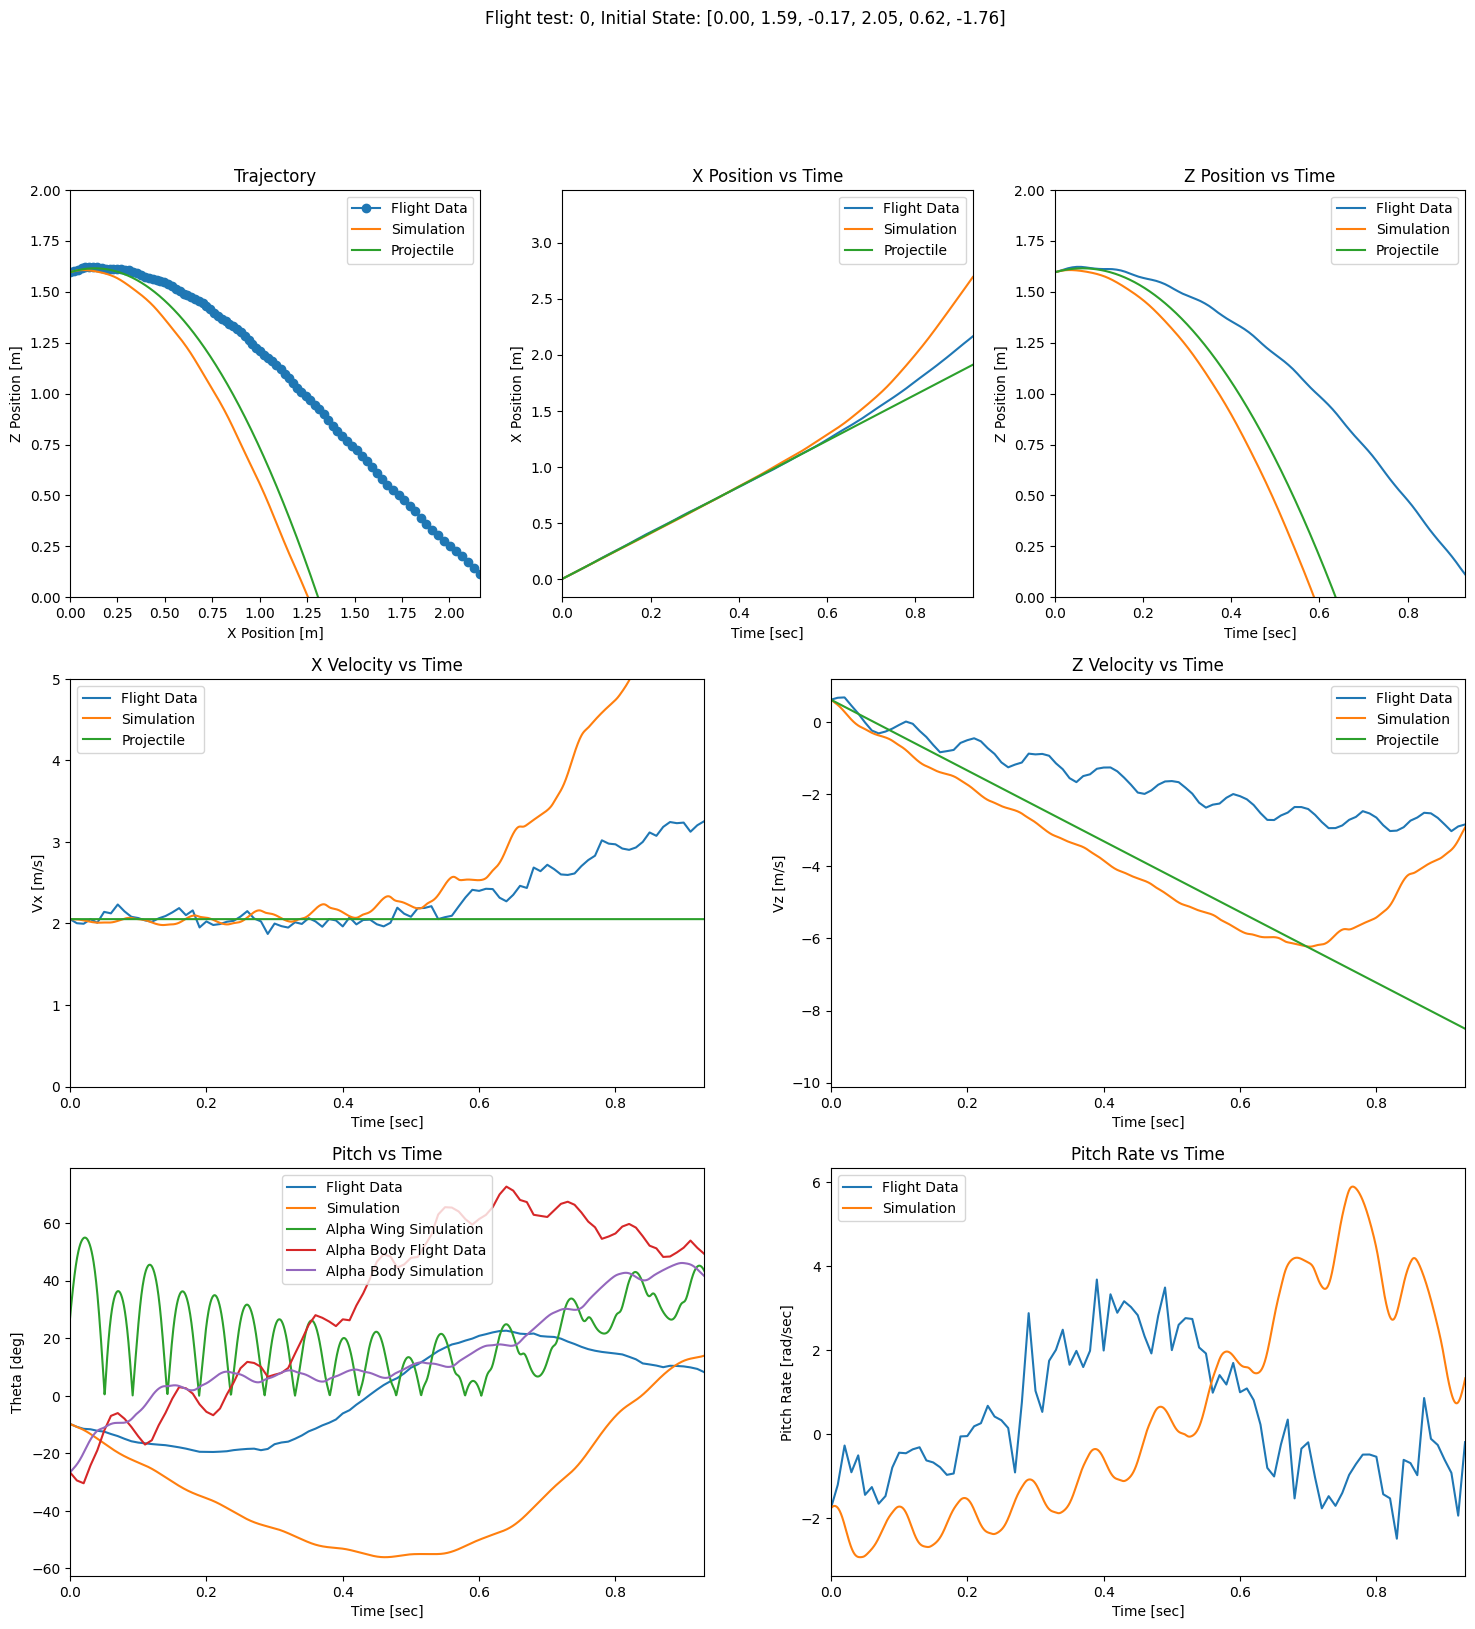

here 0.137187576 -0.978781372 2.38
(1.4250000000000096, -0.574808, -0.42509759999997954, -1.468500000000006)


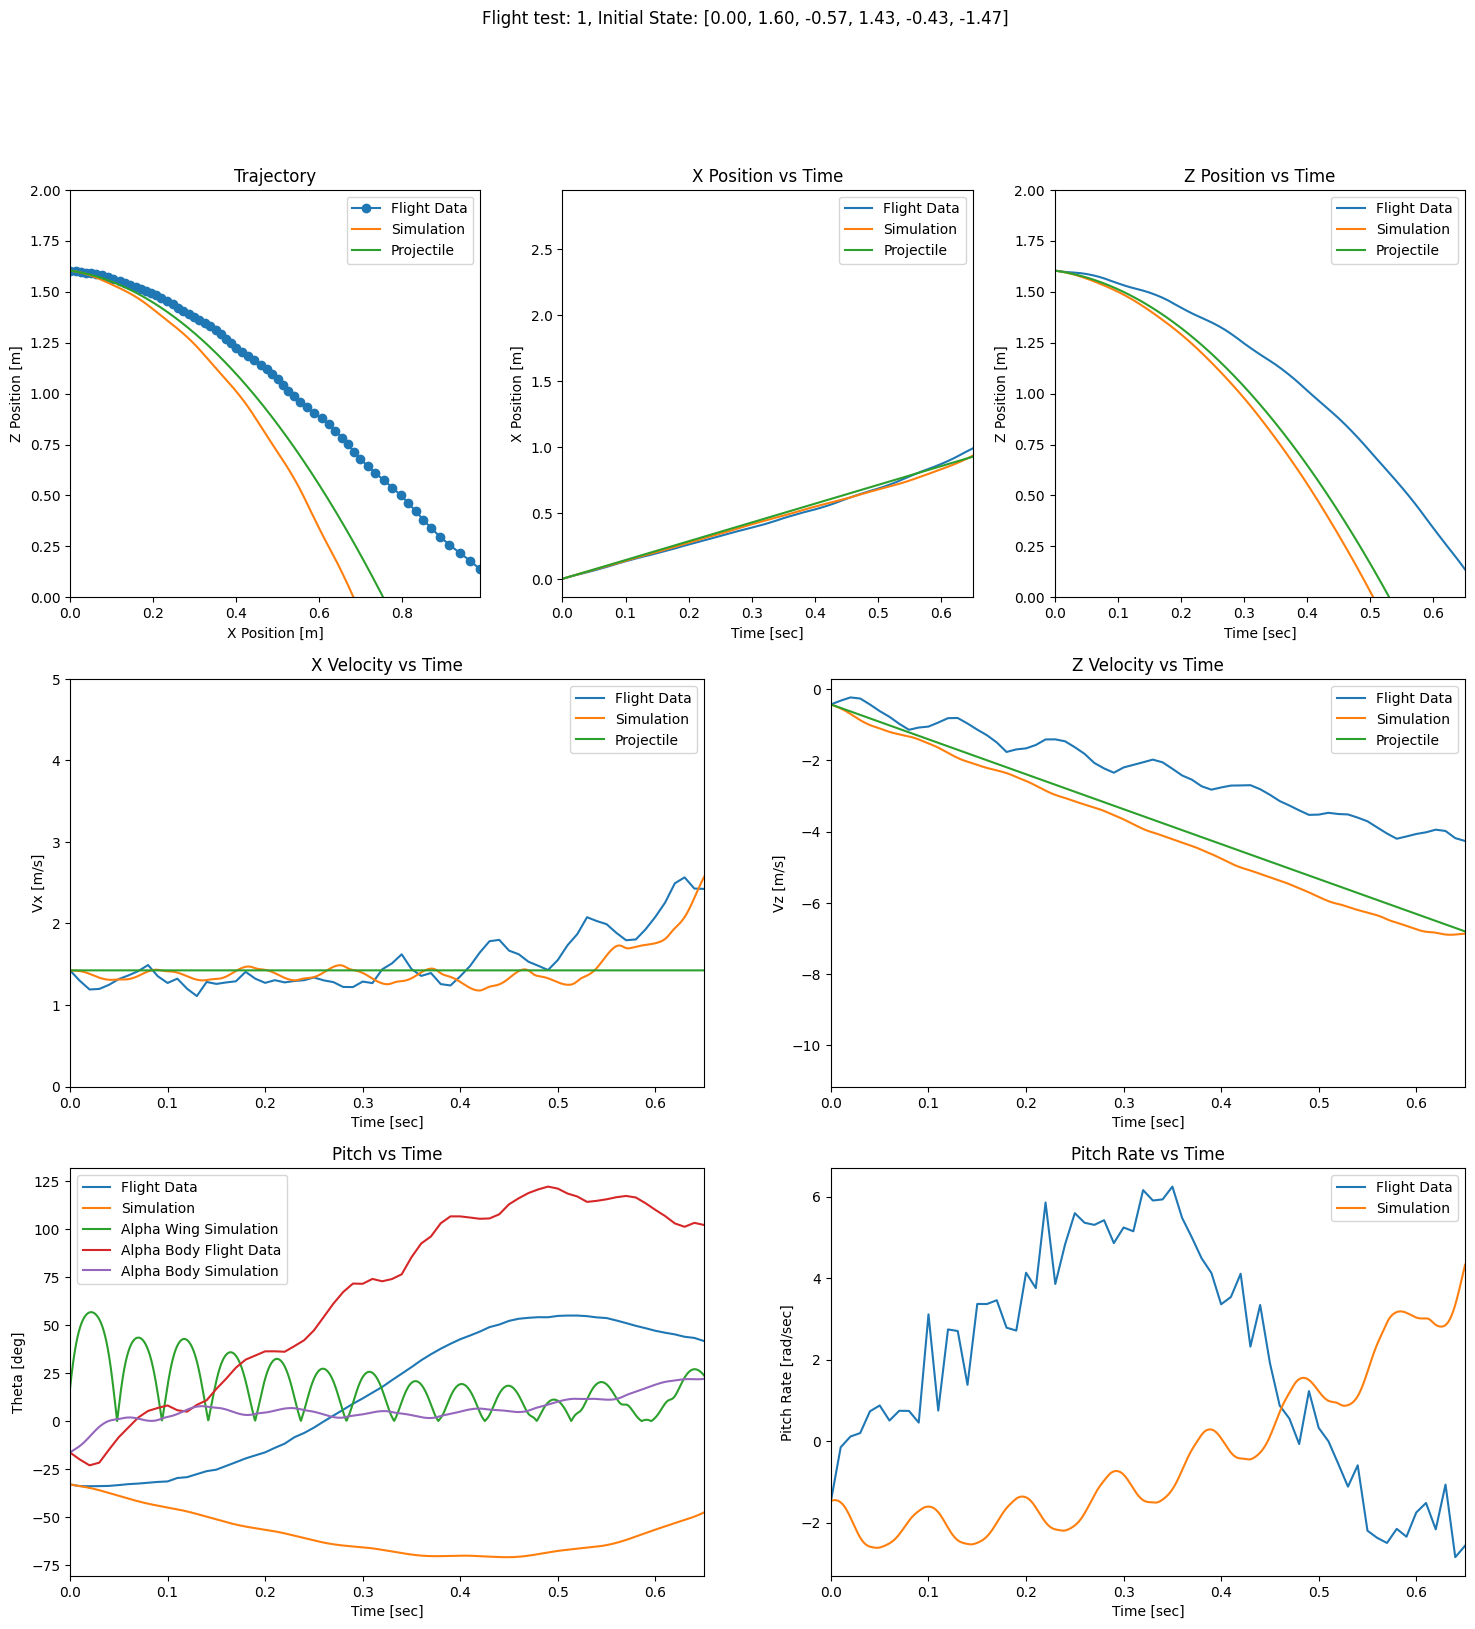

here 0.07548419199999999 -0.26496997099999997 2.06
(1.5504395000000226, 0.383222, 0.4001464999999982, -0.48210000000000197)


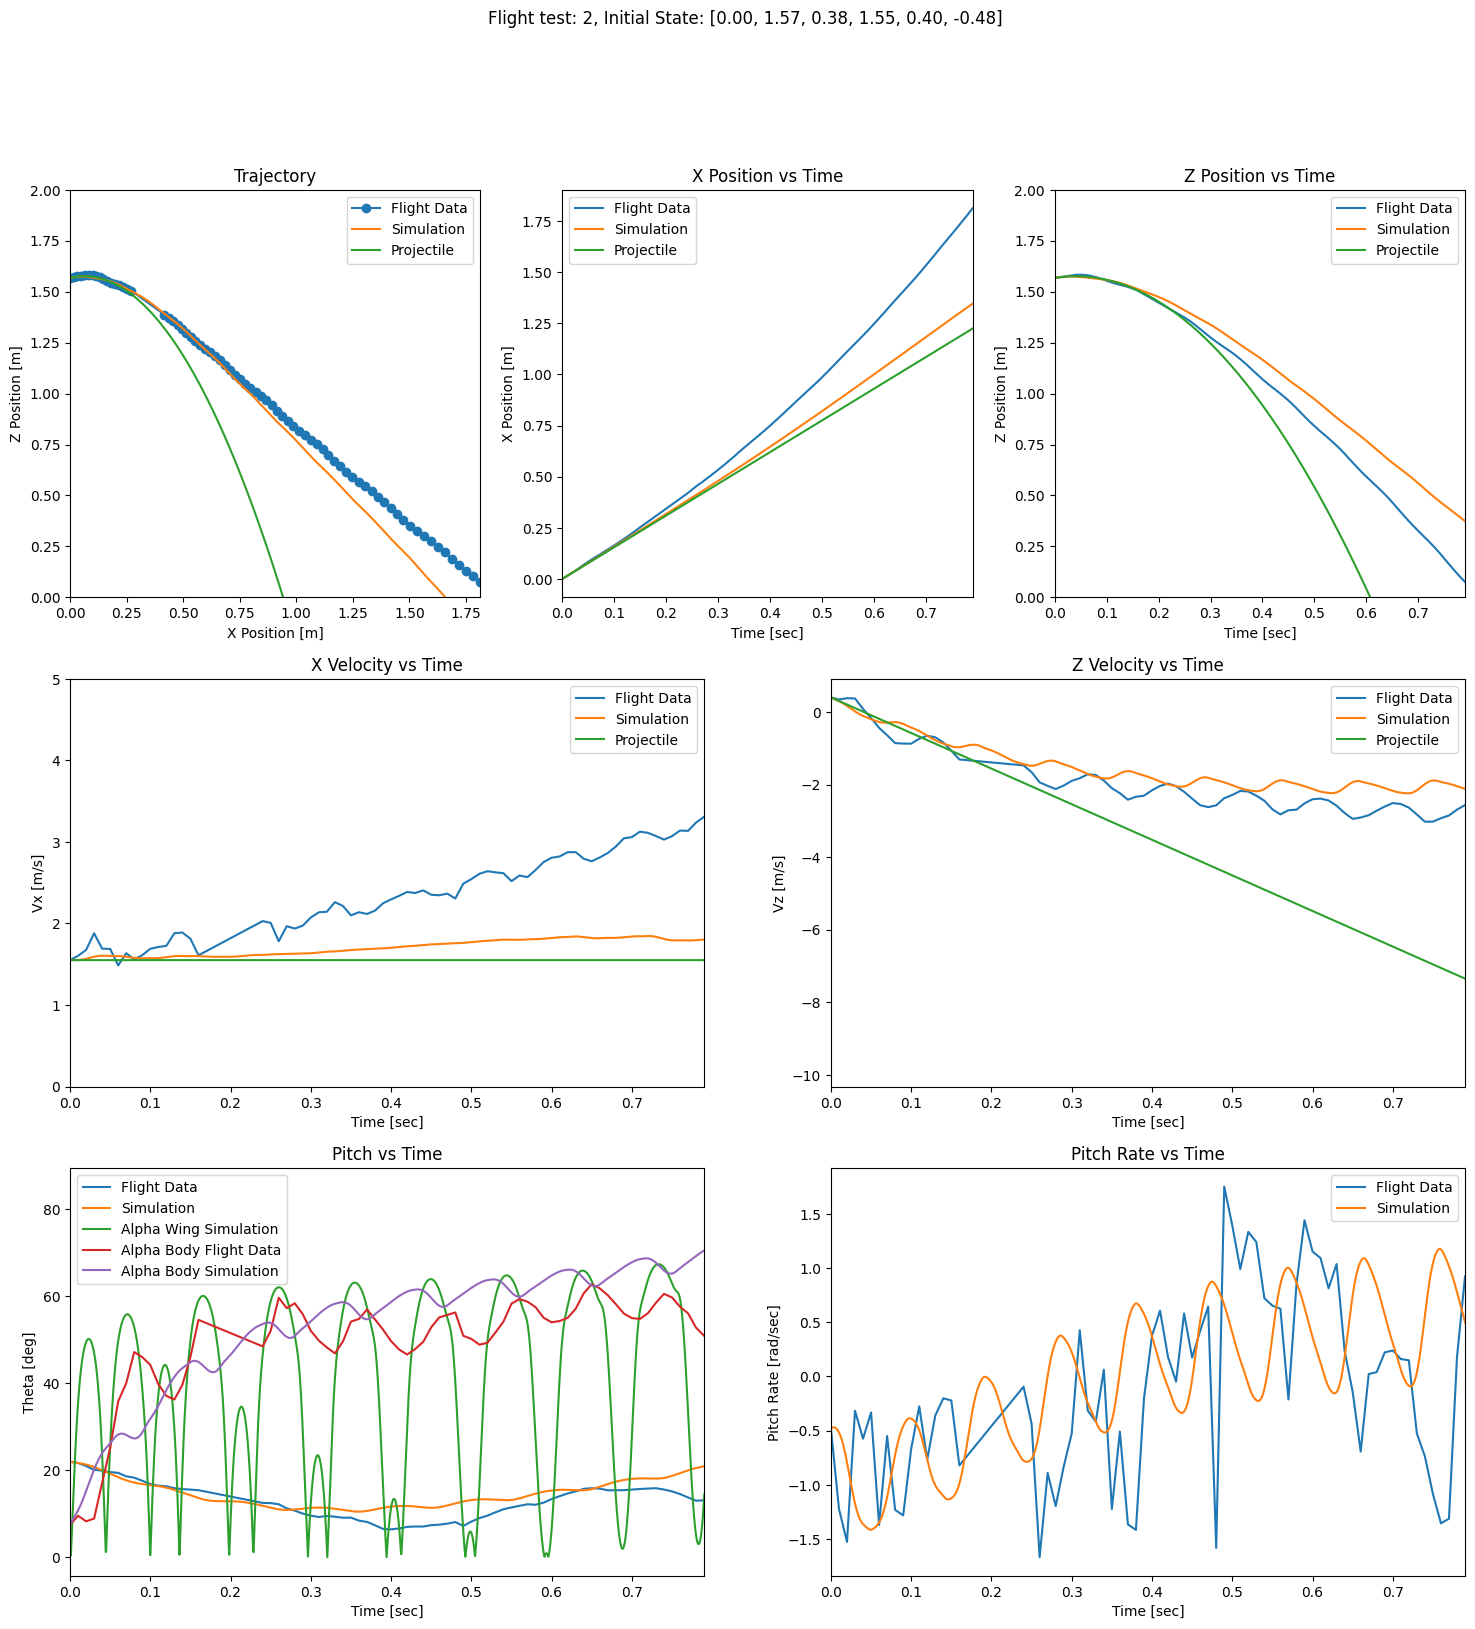

here 0.13004711900000002 -0.84506427 1.47
(2.016625999999988, -0.673309, 0.4078491999999878, -2.755999999999992)


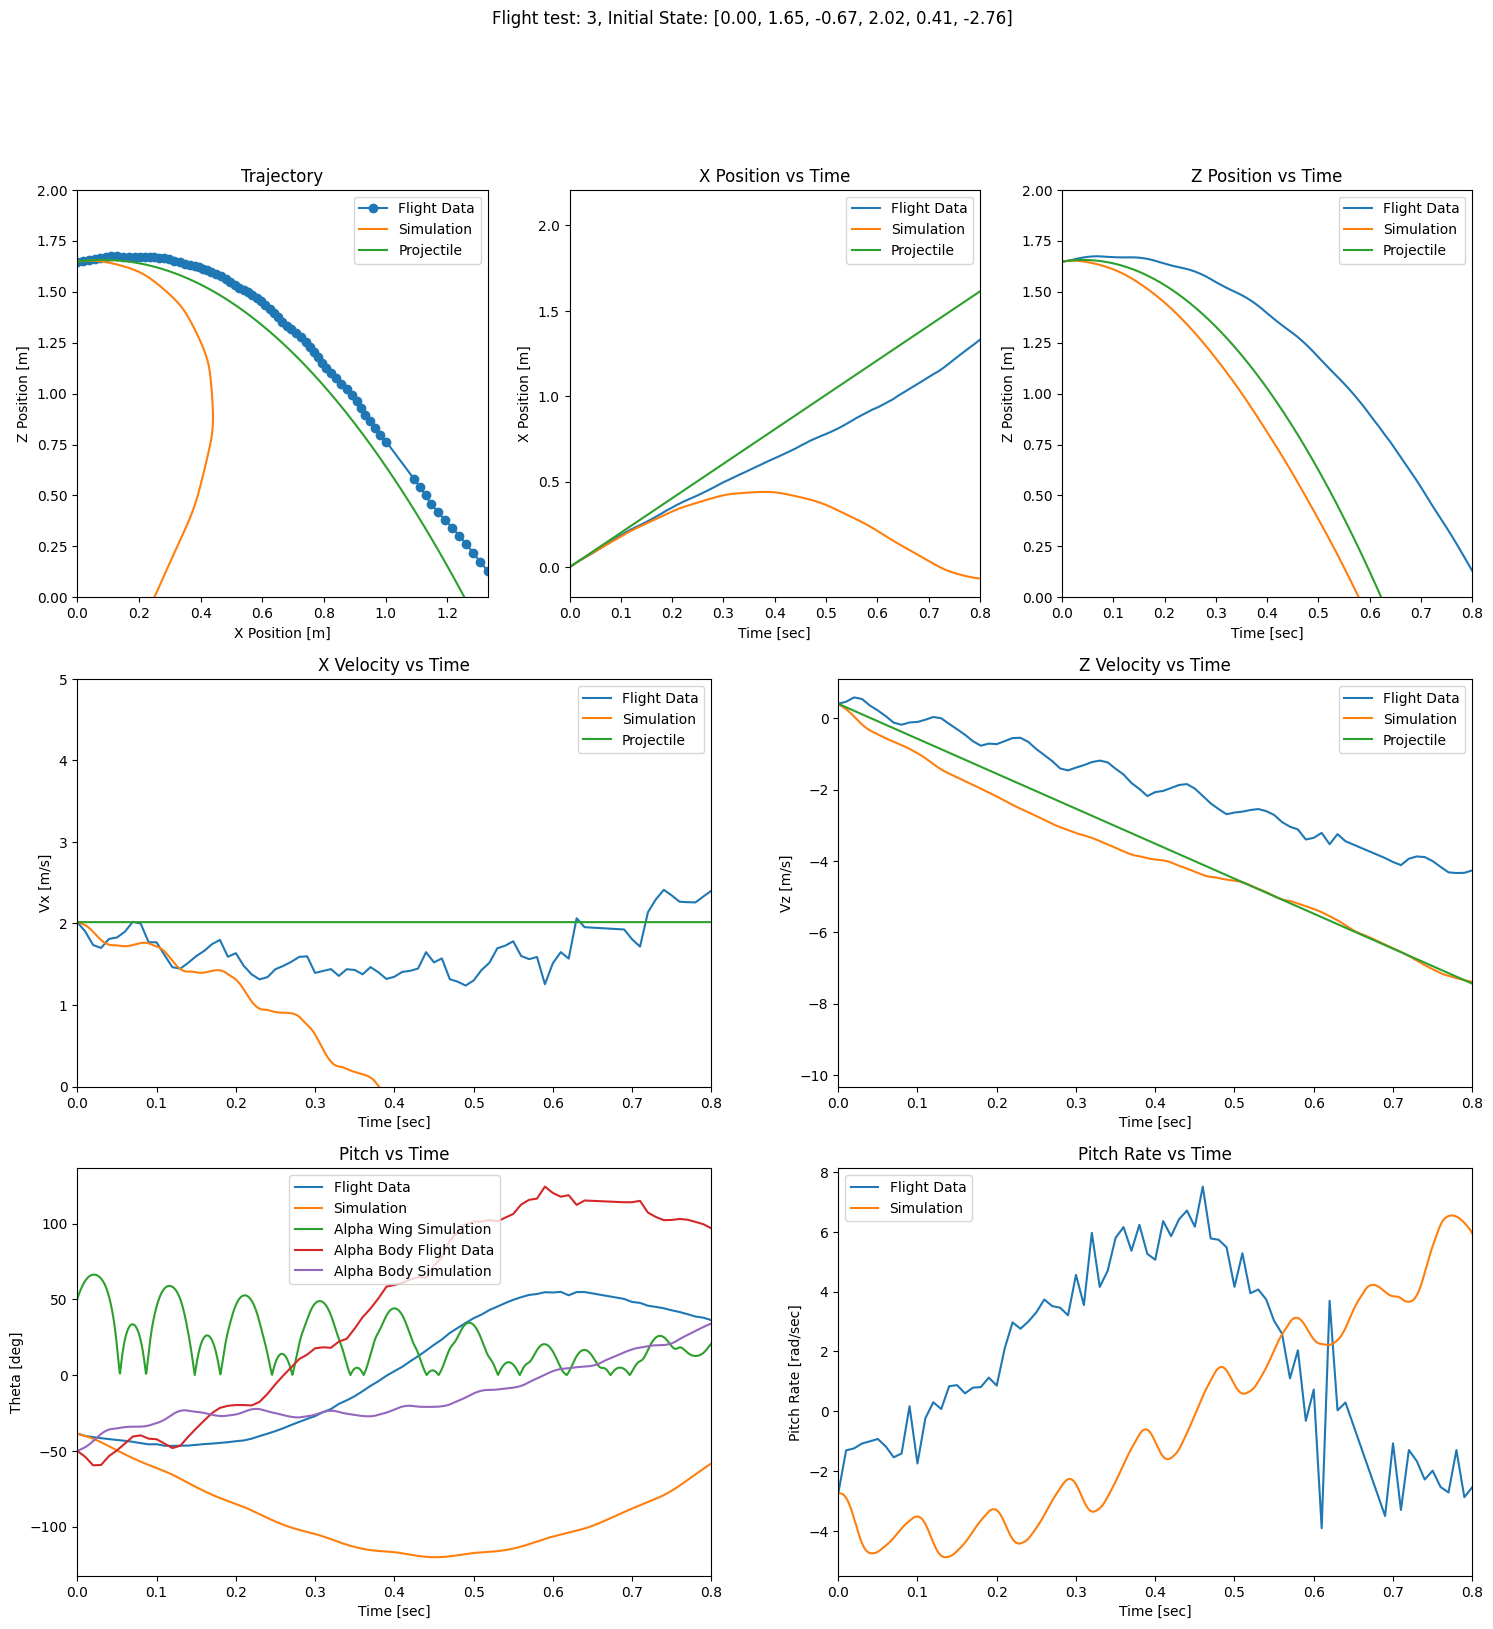

here 0.106320107 -0.545762573 2.0
(1.9269042999999986, 0.177024, -0.5053711000000183, 0.0072000000000016495)


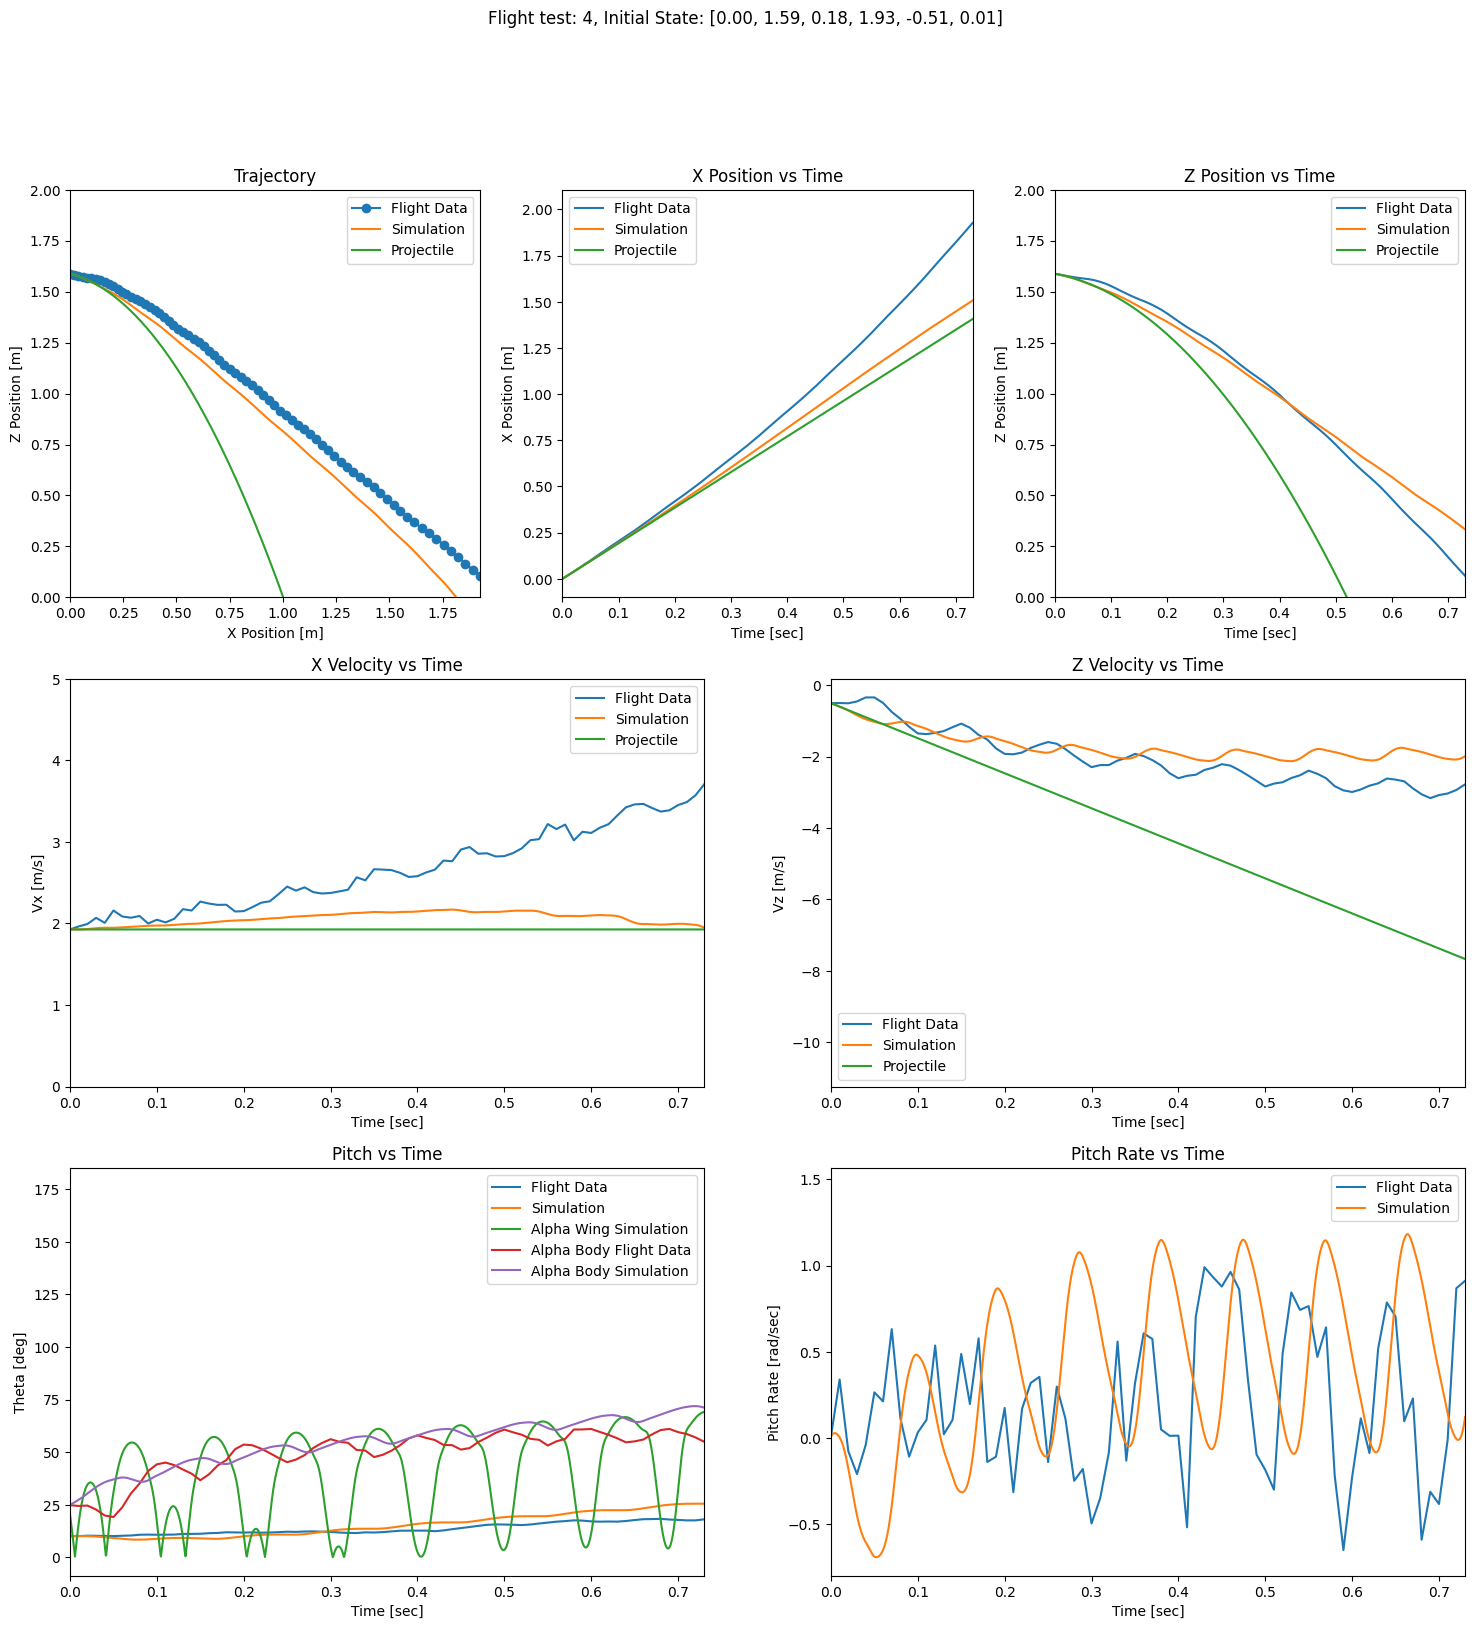

here 0.060379311 -0.202871933 2.2
(2.7362792999999552, -0.184084, 0.0027954000000107726, -2.3271000000000015)


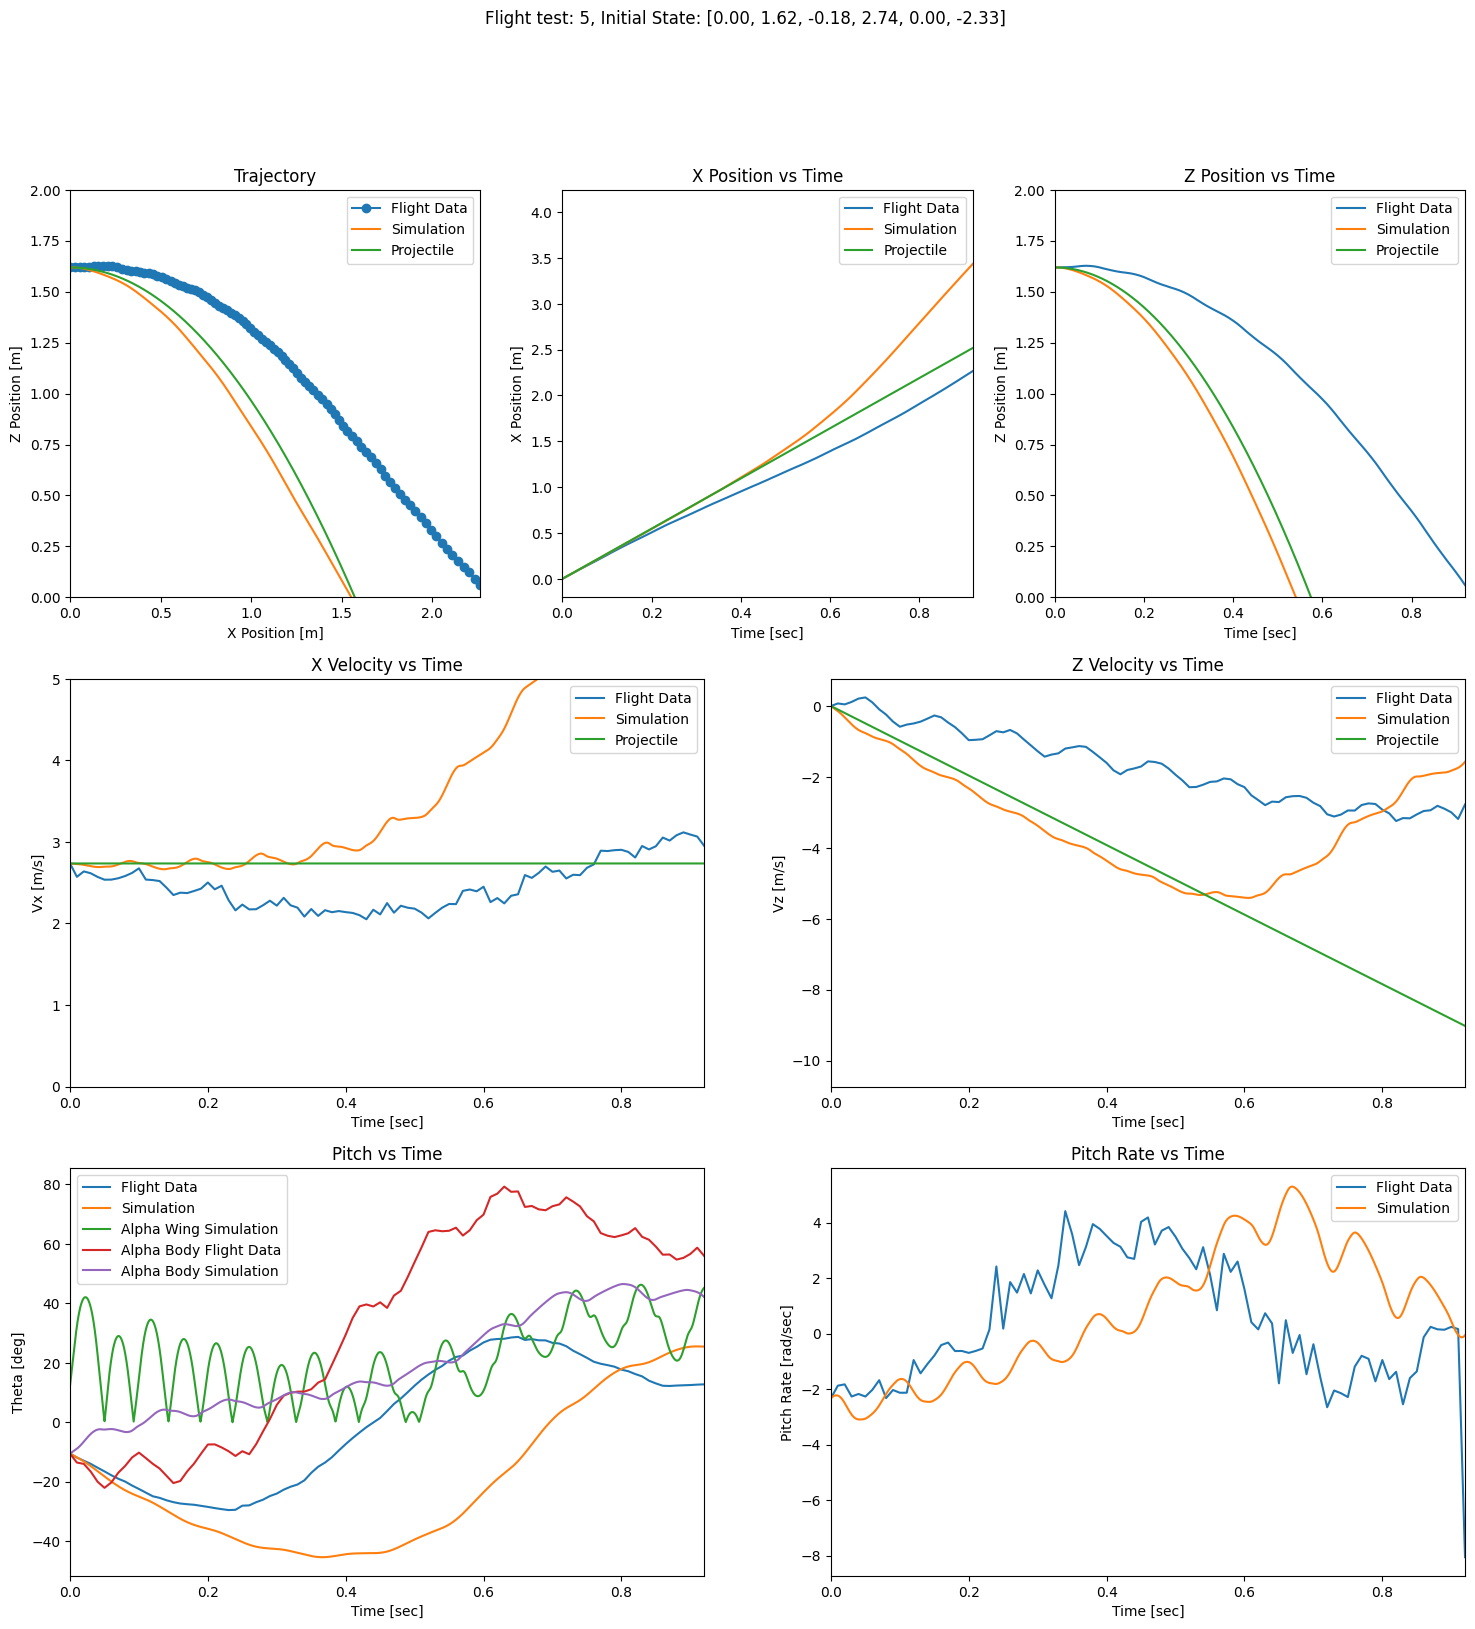

here 0.11902351400000001 -0.9920749510000001 1.98
(2.136157199999955, 0.027751, -0.03916019999998799, -1.098)


In [ ]:
i = 0
for trial in data:
    t = trial['time']

    x = trial['Tx']
    y = trial['Ty']
    z = trial['Tz']

    vx = trial['Vx']
    vz = trial['Vz']

    Fx = m*trial['Ax']
    Fz = m*trial['Az']

    rx = trial["Rx"]
    ry = trial["Ry"]
    rz = trial["Rz"]

    Wx = trial["Wx"]
    Wy = trial["Wy"]
    Wz = trial["Wz"]

    My = Jz*trial['Alphay']
    print("here", z.iloc[-1], x.iloc[-1], t.iloc[-1])
    print((vx[0], ry[0], vz[0], Wy[0]))
    tArr, results, wing_force, tail_force, alphaArr = simulation(vx[0], np.degrees(ry[0]), vz[0], Wy[0], 0, 0)

    x_norm = vx[0]*tArr
    y_norm = z[0] + vz[0]*tArr - 0.5*g*tArr**2
    vx_norm = vx[0]*np.ones(len(tArr))
    vy_norm = vz[0]*np.ones(len(tArr)) - g*tArr

    plt.figure(figsize=(18, 18))
    plt.subplot(3, 3, 1)
    plt.suptitle(f'Flight test: {i}, Initial State: [{0:.2f}, {z[0]:.2f}, {ry[0]:.2f}, {vx[0]:.2f}, {vz[0]:.2f}, {Wy[0]:.2f}]')
    plt.title("Trajectory")
    plt.plot(x[:] - x[0], z[:], marker='o', label="Flight Data")
    #plt.plot(x[:] - x[174], y[:], label="Flight Data y")
    plt.plot(results[:, 0], results[:, 1]-(10-z[0]), label="Simulation")
    plt.plot(x_norm, y_norm, label="Projectile")
    plt.xlabel("X Position [m]")
    plt.ylabel("Z Position [m]")
    plt.legend()
    plt.ylim(0, 2)
    plt.xlim(0, x.iloc[-1]-x.iloc[0])

    plt.subplot(3, 3, 2)
    plt.title("X Position vs Time")
    plt.plot(t[:]-t[0], x[:] - x[0], label="Flight Data")
    plt.plot(tArr, results[:, 0],  label="Simulation")
    plt.plot(tArr, x_norm,  label="Projectile")
    plt.xlabel("Time [sec]")
    plt.ylabel("X Position [m]")
    plt.legend()
    # plt.ylim(0, x.iloc[-1])
    plt.xlim(0, t.iloc[-1]-t.iloc[0])

    plt.subplot(3, 3, 3)
    plt.title("Z Position vs Time")
    plt.plot(t[:]-t[0], z[:], label="Flight Data")
    plt.plot(tArr, results[:, 1]-(10-z[0]),  label="Simulation")
    plt.plot(tArr, y_norm,  label="Projectile")
    plt.xlabel("Time [sec]")
    plt.ylabel("Z Position [m]")
    plt.legend()
    plt.ylim(0, 2)
    plt.xlim(0, t.iloc[-1]-t.iloc[0])

    plt.subplot(3, 2, 3)
    plt.title("X Velocity vs Time")
    plt.plot(t[:]-t[0], vx[:], label="Flight Data")
    plt.plot(tArr, results[:, 3],  label="Simulation")
    plt.plot(tArr, vx_norm,  label="Projectile")
    plt.xlabel("Time [sec]")
    plt.ylabel("Vx [m/s]")
    plt.legend()
    plt.ylim(0, 5)
    plt.xlim(0, t.iloc[-1]-t.iloc[0])

    plt.subplot(3, 2, 4)
    plt.title("Z Velocity vs Time")
    plt.plot(t[:]-t[0], vz, label="Flight Data")
    plt.plot(tArr, results[:, 4],  label="Simulation")
    plt.plot(tArr, vy_norm,  label="Projectile")
    plt.xlabel("Time [sec]")
    plt.ylabel("Vz [m/s]")
    plt.legend()
    # plt.ylim(-3, 1)
    plt.xlim(0, t.iloc[-1]-t.iloc[0])

    plt.subplot(3, 2, 5)
    plt.title("Pitch vs Time")
    #plt.plot(t[:]-t[0], np.degrees(rx[:]), label="Flight Data")
    plt.plot(t[:]-t[0], np.degrees(ry[:]), label="Flight Data")
    #plt.plot(t[:]-t[0], np.degrees(rz[:]), label="Flight Data")
    plt.plot(tArr, np.degrees(results[:, 2]),  label="Simulation")
    plt.plot(tArr, np.degrees(alphaArr),  label="Alpha Wing Simulation")
    plt.plot(t[:]-t[0], np.degrees(ry[:] - np.arctan2(vz[:], vx[:])), label="Alpha Body Flight Data")
    plt.plot(tArr, np.degrees(results[:, 2] - np.arctan2(results[:, 4], results[:, 3])), label="Alpha Body Simulation")
    plt.xlabel("Time [sec]")
    plt.ylabel("Theta [deg]")
    plt.legend()
    # plt.ylim(-3, 1)
    plt.xlim(0, t.iloc[-1]-t.iloc[0])

    plt.subplot(3, 2, 6)
    plt.title("Pitch Rate vs Time")
    plt.plot(t[:]-t[0], (Wy[:]), label="Flight Data")
    plt.plot(tArr, (results[:, 5]),  label="Simulation")
    plt.xlabel("Time [sec]")
    plt.ylabel("Pitch Rate [rad/sec]")
    plt.legend()
    # plt.ylim(-3, 1)
    plt.xlim(0, t.iloc[-1]-t.iloc[0])

    plt.tight_layout()
    plt.show()
    i+=1

##Trial 0

<ipython-input-276-84914217033e>:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha_Arr[i] = wing_left.alpha_COP
<ipython-input-280-2414299a113c>:115: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


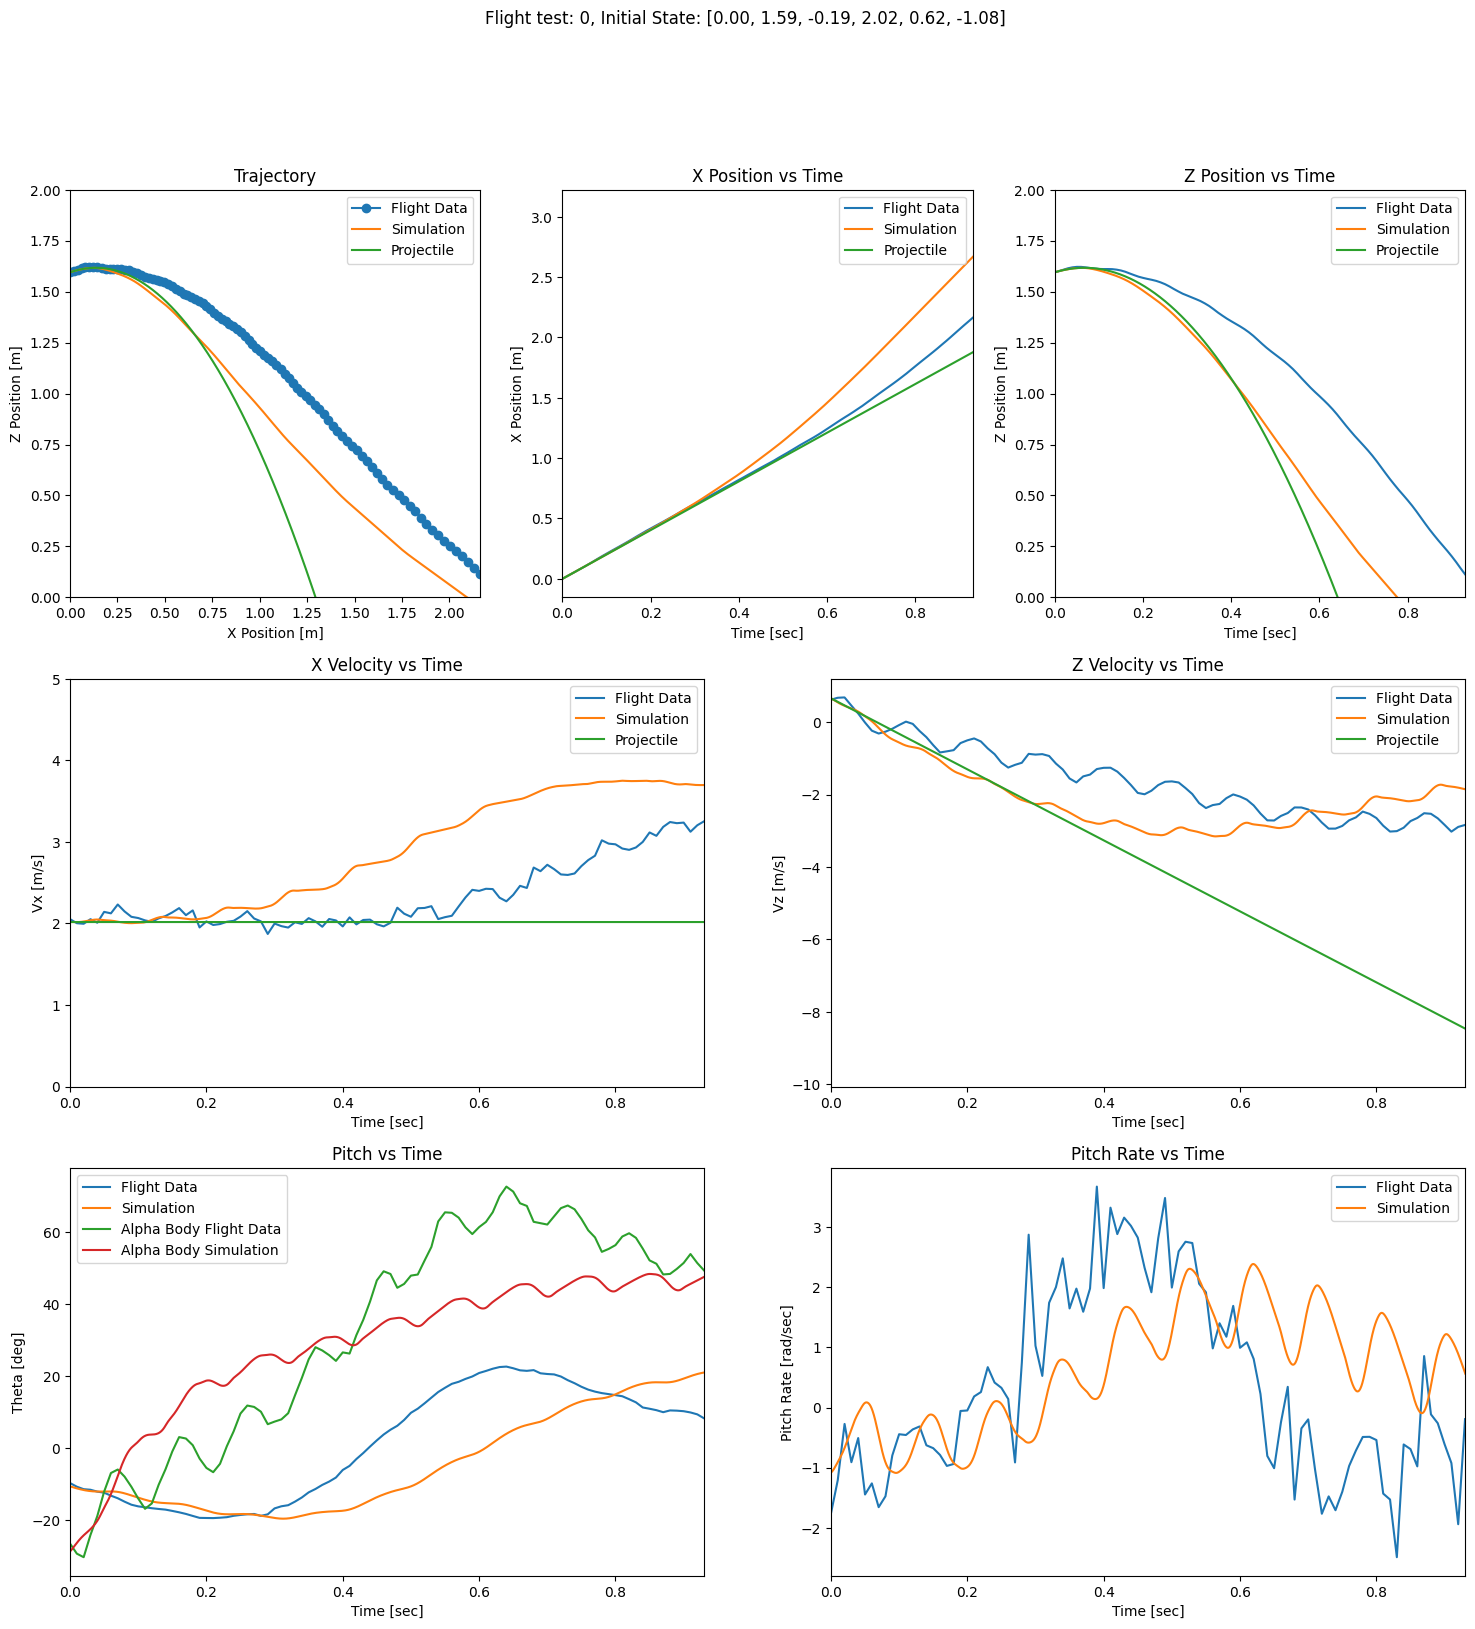

In [ ]:
trial = data[0]

t = trial['time']

x = trial['Tx']
y = trial['Ty']
z = trial['Tz']

vx = trial['Vx']
vz = trial['Vz']

Fx = m*trial['Ax']
Fz = m*trial['Az']

rx = trial["Rx"]
ry = trial["Ry"]
rz = trial["Rz"]

Wx = trial["Wx"]
Wy = trial["Wy"]
Wz = trial["Wz"]

My = Jz*trial['Alphay']
# print("here", z.iloc[-1], x.iloc[-1], t.iloc[-1])
tArr, results, wing_force, tail_force, alphaArr = simulation(vx[0:3].mean(), np.degrees(ry[0:3].mean()), vz[0:3].mean(), Wy[0:3].mean(), np.pi*4/4, np.pi*4/4)

x_norm = vx[0:3].mean()*tArr
y_norm = z[0] + vz[0:3].mean()*tArr - 0.5*g*tArr**2
vx_norm = vx[0:3].mean()*np.ones(len(tArr))
vy_norm = vz[0:3].mean()*np.ones(len(tArr)) - g*tArr

plt.figure(figsize=(18, 18))
plt.subplot(3, 3, 1)
plt.suptitle(f'Flight test: 0, Initial State: [{0:.2f}, {z[0]:.2f}, {ry[0:3].mean():.2f}, {vx[0:3].mean():.2f}, {vz[0]:.2f}, {Wy[0:3].mean():.2f}]')
plt.title("Trajectory")
plt.plot(x[:] - x[0], z[:], marker='o', label="Flight Data")
#plt.plot(x[:] - x[174], y[:], label="Flight Data y")
plt.plot(results[:, 0], results[:, 1]-(10-z[0]), label="Simulation")
plt.plot(x_norm, y_norm, label="Projectile")
plt.xlabel("X Position [m]")
plt.ylabel("Z Position [m]")
plt.legend()
plt.ylim(0, 2)
plt.xlim(0, x.iloc[-1]-x.iloc[0])

plt.subplot(3, 3, 2)
plt.title("X Position vs Time")
plt.plot(t[:]-t[0], x[:] - x[0], label="Flight Data")
plt.plot(tArr, results[:, 0],  label="Simulation")
plt.plot(tArr, x_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("X Position [m]")
plt.legend()
# plt.ylim(0, x.iloc[-1])
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 3, 3)
plt.title("Z Position vs Time")
plt.plot(t[:]-t[0], z[:], label="Flight Data")
plt.plot(tArr, results[:, 1]-(10-z[0]),  label="Simulation")
plt.plot(tArr, y_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Z Position [m]")
plt.legend()
plt.ylim(0, 2)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 3)
plt.title("X Velocity vs Time")
plt.plot(t[:]-t[0], vx[:], label="Flight Data")
plt.plot(tArr, results[:, 3],  label="Simulation")
plt.plot(tArr, vx_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Vx [m/s]")
plt.legend()
plt.ylim(0, 5)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 4)
plt.title("Z Velocity vs Time")
plt.plot(t[:]-t[0], vz, label="Flight Data")
plt.plot(tArr, results[:, 4],  label="Simulation")
plt.plot(tArr, vy_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Vz [m/s]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 5)
plt.title("Pitch vs Time")
#plt.plot(t[:]-t[0], np.degrees(rx[:]), label="Flight Data")
plt.plot(t[:]-t[0], np.degrees(ry[:]), label="Flight Data")
#plt.plot(t[:]-t[0], np.degrees(rz[:]), label="Flight Data")
plt.plot(tArr, np.degrees(results[:, 2]),  label="Simulation")
#plt.plot(tArr, np.degrees(alphaArr),  label="Alpha Wing Simulation")
plt.plot(t[:]-t[0], np.degrees(ry[:] - np.arctan2(vz[:], vx[:])), label="Alpha Body Flight Data")
plt.plot(tArr, np.degrees(results[:, 2] - np.arctan2(results[:, 4], results[:, 3])), label="Alpha Body Simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Theta [deg]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 6)
plt.title("Pitch Rate vs Time")
plt.plot(t[:]-t[0], (Wy[:]), label="Flight Data")
plt.plot(tArr, (results[:, 5]),  label="Simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Pitch Rate [rad/sec]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.tight_layout()
plt.show()

##Trial 1

<ipython-input-10-84914217033e>:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha_Arr[i] = wing_left.alpha_COP
<ipython-input-32-262db534534c>:115: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


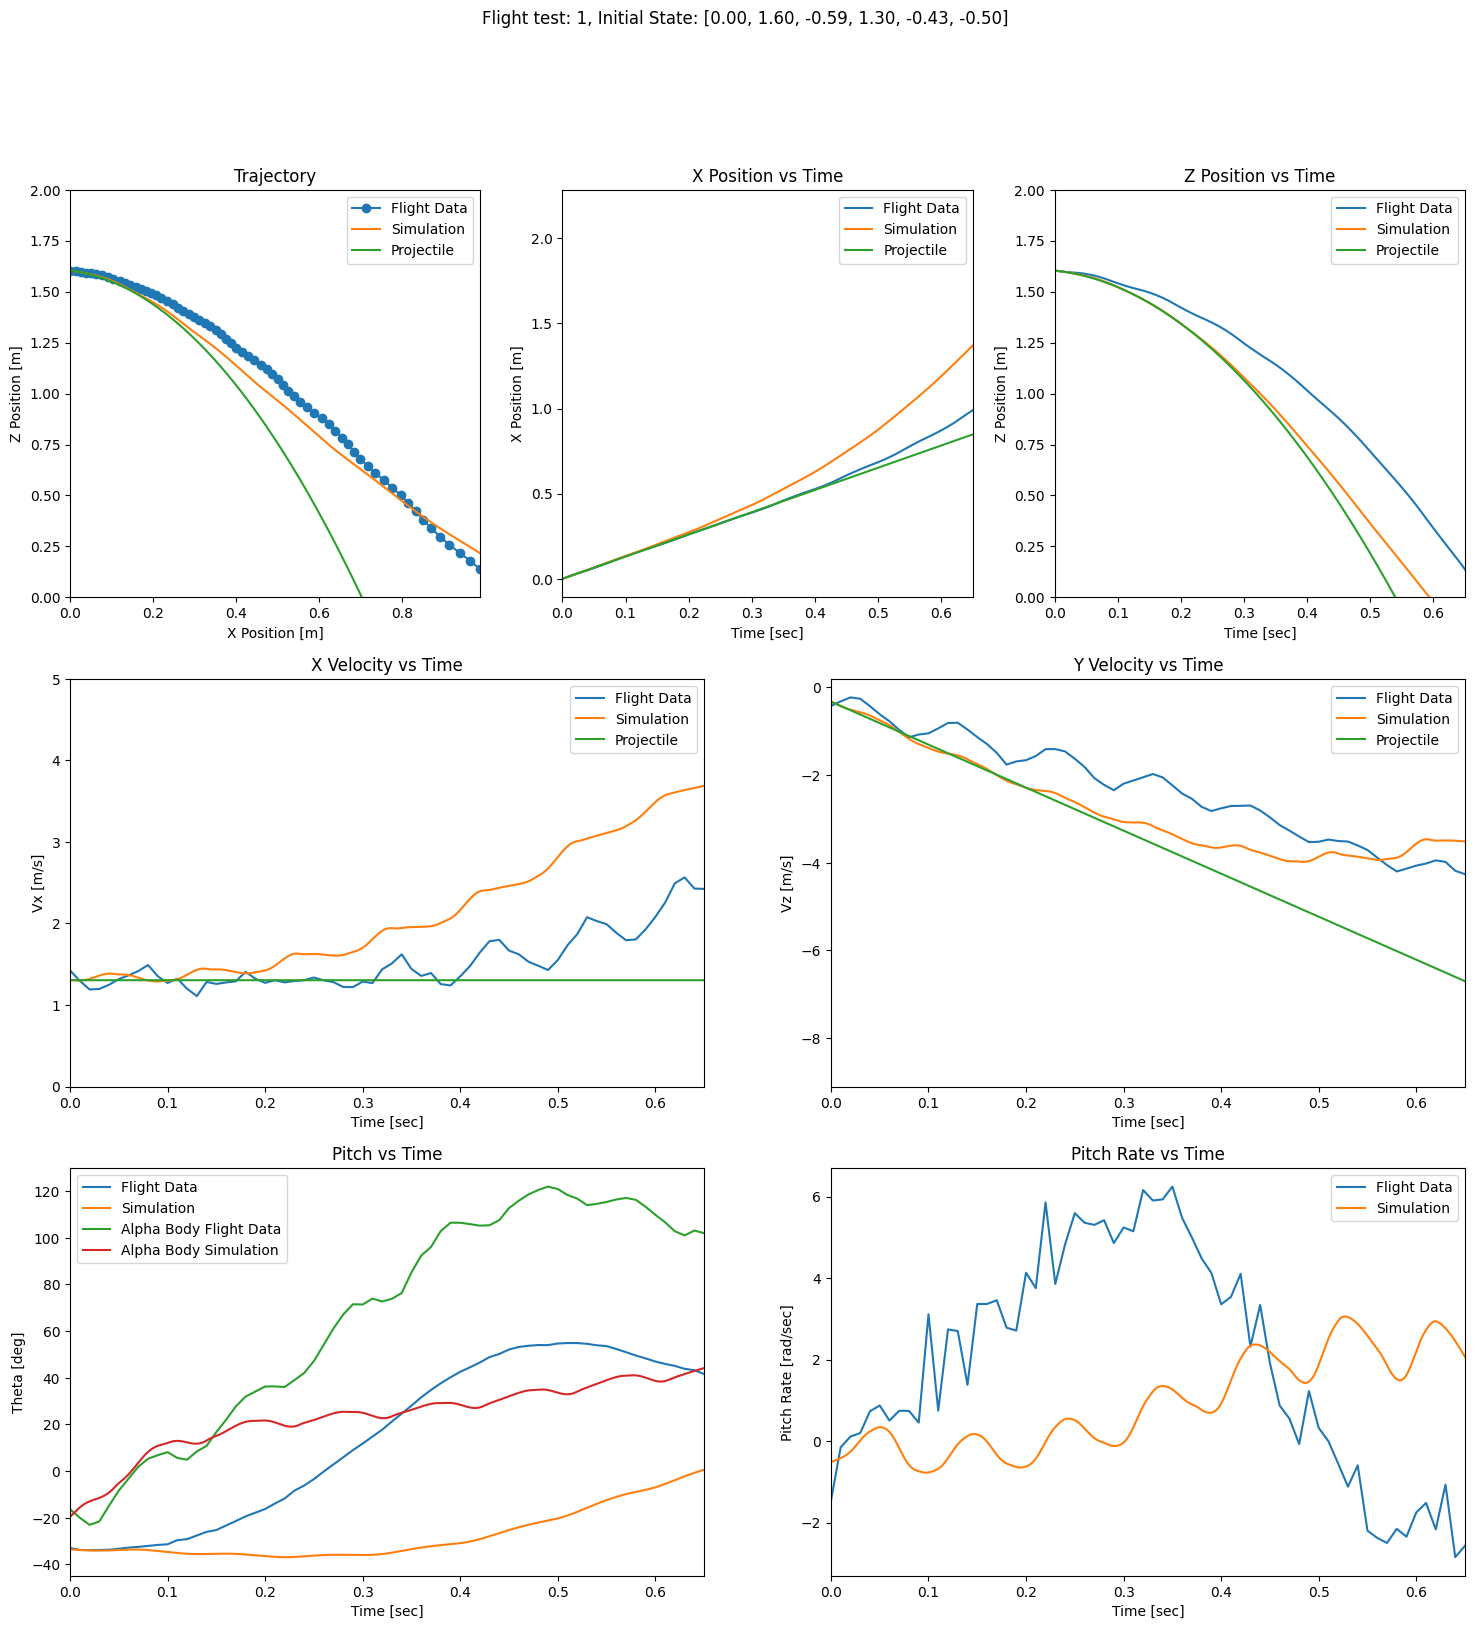

In [ ]:
trial = data[1]

t = trial['time']

x = trial['Tx']
y = trial['Ty']
z = trial['Tz']

vx = trial['Vx']
vz = trial['Vz']

Fx = m*trial['Ax']
Fz = m*trial['Az']

rx = trial["Rx"]
ry = trial["Ry"]
rz = trial["Rz"]

Wx = trial["Wx"]
Wy = trial["Wy"]
Wz = trial["Wz"]

My = Jz*trial['Alphay']
# print("here", z.iloc[-1], x.iloc[-1], t.iloc[-1])
tArr, results, wing_force, tail_force, alphaArr = simulation(vx[0:3].mean(), np.degrees(ry[0:3].mean()), vz[0:3].mean(), Wy[0:3].mean(), np.pi*4/4, np.pi*4/4)

x_norm = vx[0:3].mean()*tArr
y_norm = z[0] + vz[0:3].mean()*tArr - 0.5*g*tArr**2
vx_norm = vx[0:3].mean()*np.ones(len(tArr))
vy_norm = vz[0:3].mean()*np.ones(len(tArr)) - g*tArr

plt.figure(figsize=(18, 18))
plt.subplot(3, 3, 1)
plt.suptitle(f'Flight test: 1, Initial State: [{0:.2f}, {z[0]:.2f}, {ry[0:3].mean():.2f}, {vx[0:3].mean():.2f}, {vz[0]:.2f}, {Wy[0:3].mean():.2f}]')
plt.title("Trajectory")
plt.plot(x[:] - x[0], z[:], marker='o', label="Flight Data")
#plt.plot(x[:] - x[174], y[:], label="Flight Data y")
plt.plot(results[:, 0], results[:, 1]-(10-z[0]), label="Simulation")
plt.plot(x_norm, y_norm, label="Projectile")
plt.xlabel("X Position [m]")
plt.ylabel("Z Position [m]")
plt.legend()
plt.ylim(0, 2)
plt.xlim(0, x.iloc[-1]-x.iloc[0])

plt.subplot(3, 3, 2)
plt.title("X Position vs Time")
plt.plot(t[:]-t[0], x[:] - x[0], label="Flight Data")
plt.plot(tArr, results[:, 0],  label="Simulation")
plt.plot(tArr, x_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("X Position [m]")
plt.legend()
# plt.ylim(0, x.iloc[-1])
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 3, 3)
plt.title("Z Position vs Time")
plt.plot(t[:]-t[0], z[:], label="Flight Data")
plt.plot(tArr, results[:, 1]-(10-z[0]),  label="Simulation")
plt.plot(tArr, y_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Z Position [m]")
plt.legend()
plt.ylim(0, 2)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 3)
plt.title("X Velocity vs Time")
plt.plot(t[:]-t[0], vx[:], label="Flight Data")
plt.plot(tArr, results[:, 3],  label="Simulation")
plt.plot(tArr, vx_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Vx [m/s]")
plt.legend()
plt.ylim(0, 5)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 4)
plt.title("Y Velocity vs Time")
plt.plot(t[:]-t[0], vz, label="Flight Data")
plt.plot(tArr, results[:, 4],  label="Simulation")
plt.plot(tArr, vy_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Vz [m/s]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 5)
plt.title("Pitch vs Time")
#plt.plot(t[:]-t[0], np.degrees(rx[:]), label="Flight Data")
plt.plot(t[:]-t[0], np.degrees(ry[:]), label="Flight Data")
#plt.plot(t[:]-t[0], np.degrees(rz[:]), label="Flight Data")
plt.plot(tArr, np.degrees(results[:, 2]),  label="Simulation")
#plt.plot(tArr, np.degrees(alphaArr),  label="Alpha Wing Simulation")
plt.plot(t[:]-t[0], np.degrees(ry[:] - np.arctan2(vz[:], vx[:])), label="Alpha Body Flight Data")
plt.plot(tArr, np.degrees(results[:, 2] - np.arctan2(results[:, 4], results[:, 3])), label="Alpha Body Simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Theta [deg]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 6)
plt.title("Pitch Rate vs Time")
plt.plot(t[:]-t[0], (Wy[:]), label="Flight Data")
plt.plot(tArr, (results[:, 5]),  label="Simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Pitch Rate [rad/sec]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.tight_layout()
plt.show()

##Trial 2

<ipython-input-276-84914217033e>:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha_Arr[i] = wing_left.alpha_COP
<ipython-input-277-a30cf43b2266>:115: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


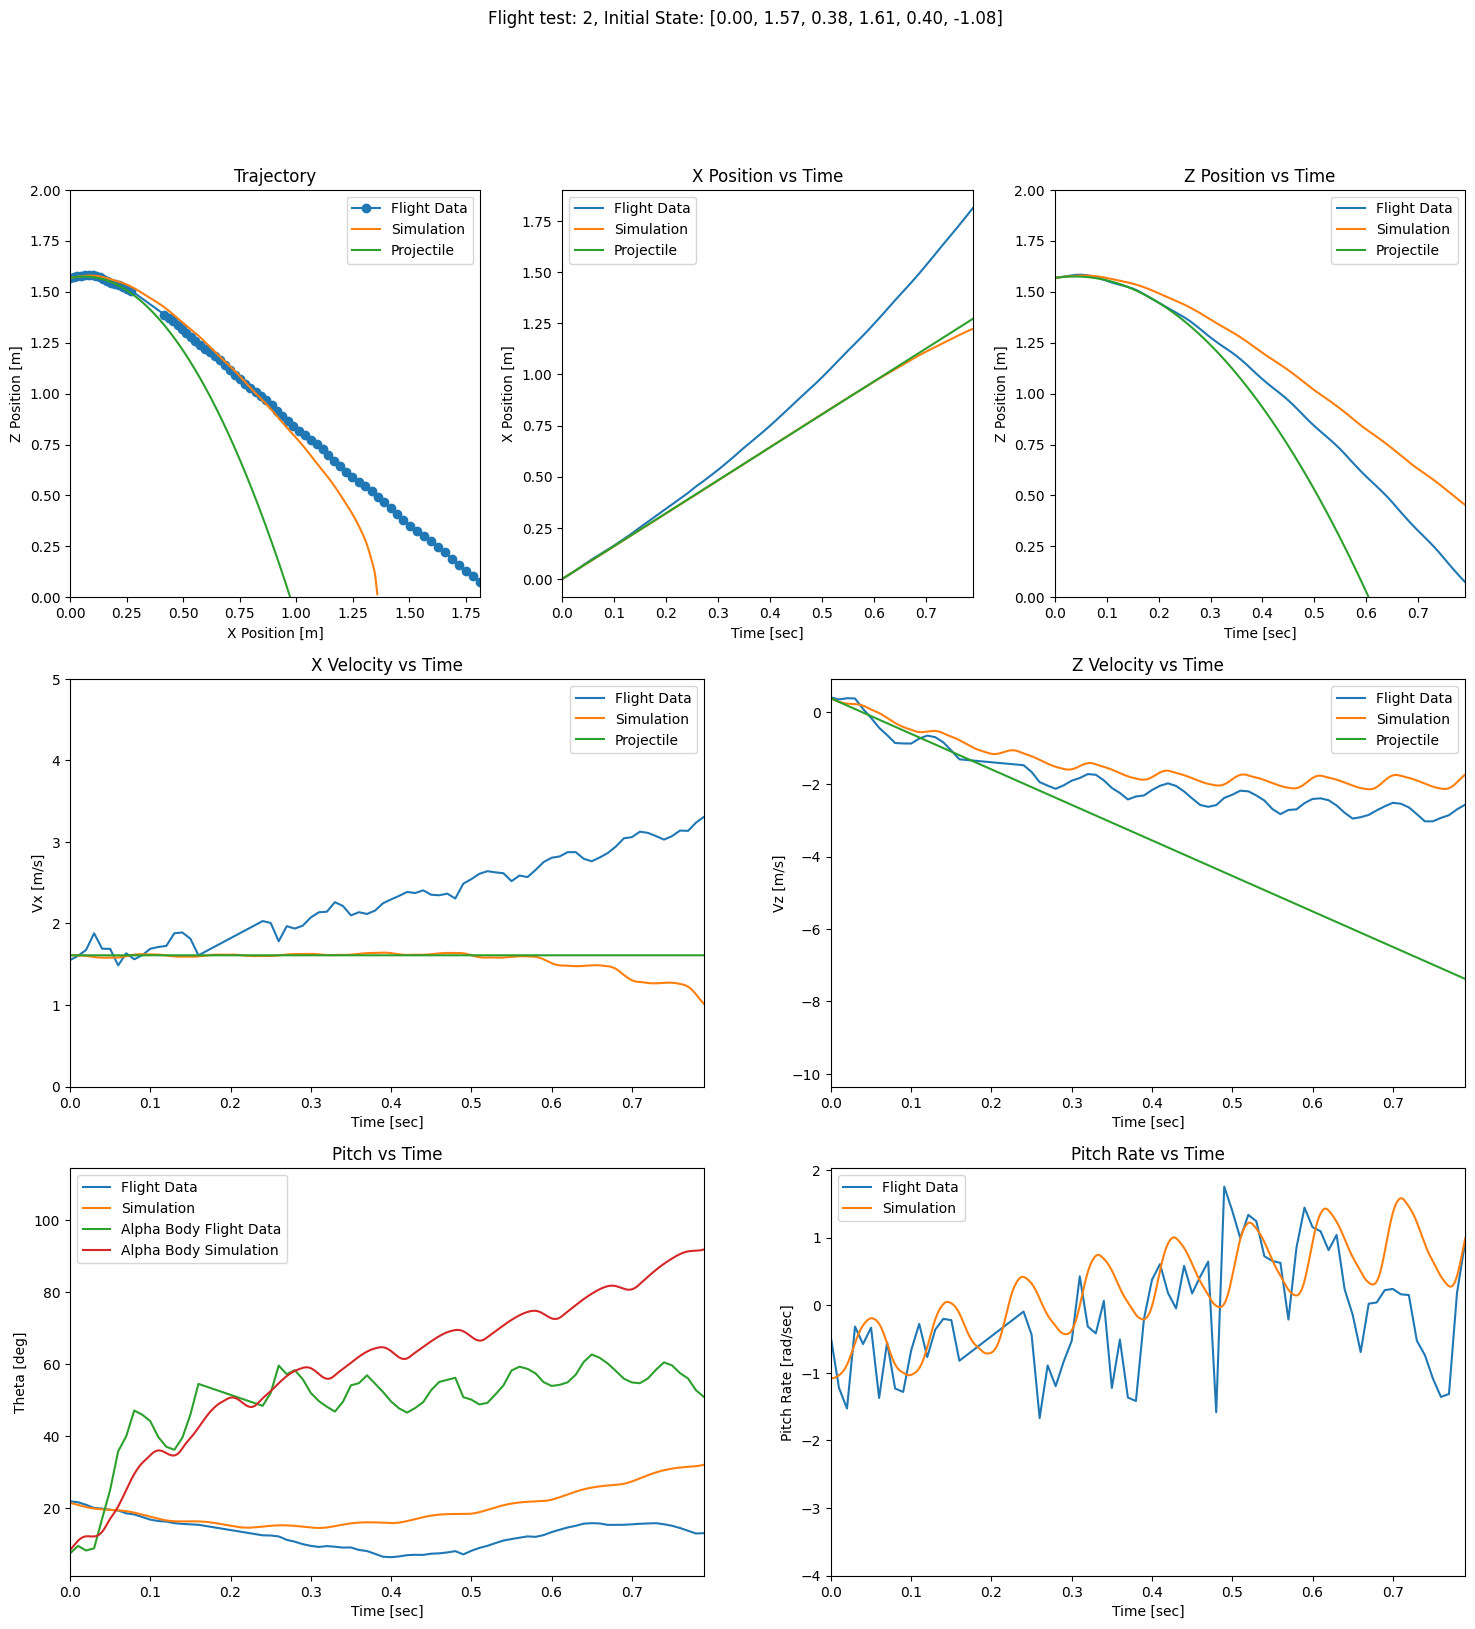

In [ ]:
trial = data[2]

t = trial['time']

x = trial['Tx']
y = trial['Ty']
z = trial['Tz']

vx = trial['Vx']
vz = trial['Vz']

Fx = m*trial['Ax']
Fz = m*trial['Az']

rx = trial["Rx"]
ry = trial["Ry"]
rz = trial["Rz"]

Wx = trial["Wx"]
Wy = trial["Wy"]
Wz = trial["Wz"]

My = Jz*trial['Alphay']
# print("here", z.iloc[-1], x.iloc[-1], t.iloc[-1])
tArr, results, wing_force, tail_force, alphaArr = simulation(vx[0:3].mean(), np.degrees(ry[0:3].mean()), vz[0:3].mean(), Wy[0:3].mean(), np.pi*4/4, np.pi*4/4)

x_norm = vx[0:3].mean()*tArr
y_norm = z[0] + vz[0:3].mean()*tArr - 0.5*g*tArr**2
vx_norm = vx[0:3].mean()*np.ones(len(tArr))
vy_norm = vz[0:3].mean()*np.ones(len(tArr)) - g*tArr

plt.figure(figsize=(18, 18))
plt.subplot(3, 3, 1)
plt.suptitle(f'Flight test: 2, Initial State: [{0:.2f}, {z[0]:.2f}, {ry[0:3].mean():.2f}, {vx[0:3].mean():.2f}, {vz[0]:.2f}, {Wy[0:3].mean():.2f}]')
plt.title("Trajectory")
plt.plot(x[:] - x[0], z[:], marker='o', label="Flight Data")
#plt.plot(x[:] - x[174], y[:], label="Flight Data y")
plt.plot(results[:, 0], results[:, 1]-(10-z[0]), label="Simulation")
plt.plot(x_norm, y_norm, label="Projectile")
plt.xlabel("X Position [m]")
plt.ylabel("Z Position [m]")
plt.legend()
plt.ylim(0, 2)
plt.xlim(0, x.iloc[-1]-x.iloc[0])

plt.subplot(3, 3, 2)
plt.title("X Position vs Time")
plt.plot(t[:]-t[0], x[:] - x[0], label="Flight Data")
plt.plot(tArr, results[:, 0],  label="Simulation")
plt.plot(tArr, x_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("X Position [m]")
plt.legend()
# plt.ylim(0, x.iloc[-1])
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 3, 3)
plt.title("Z Position vs Time")
plt.plot(t[:]-t[0], z[:], label="Flight Data")
plt.plot(tArr, results[:, 1]-(10-z[0]),  label="Simulation")
plt.plot(tArr, y_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Z Position [m]")
plt.legend()
plt.ylim(0, 2)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 3)
plt.title("X Velocity vs Time")
plt.plot(t[:]-t[0], vx[:], label="Flight Data")
plt.plot(tArr, results[:, 3],  label="Simulation")
plt.plot(tArr, vx_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Vx [m/s]")
plt.legend()
plt.ylim(0, 5)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 4)
plt.title("Z Velocity vs Time")
plt.plot(t[:]-t[0], vz, label="Flight Data")
plt.plot(tArr, results[:, 4],  label="Simulation")
plt.plot(tArr, vy_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Vz [m/s]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 5)
plt.title("Pitch vs Time")
#plt.plot(t[:]-t[0], np.degrees(rx[:]), label="Flight Data")
plt.plot(t[:]-t[0], np.degrees(ry[:]), label="Flight Data")
#plt.plot(t[:]-t[0], np.degrees(rz[:]), label="Flight Data")
plt.plot(tArr, np.degrees(results[:, 2]),  label="Simulation")
#plt.plot(tArr, np.degrees(alphaArr),  label="Alpha Wing Simulation")
plt.plot(t[:]-t[0], np.degrees(ry[:] - np.arctan2(vz[:], vx[:])), label="Alpha Body Flight Data")
plt.plot(tArr, np.degrees(results[:, 2] - np.arctan2(results[:, 4], results[:, 3])), label="Alpha Body Simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Theta [deg]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 6)
plt.title("Pitch Rate vs Time")
plt.plot(t[:]-t[0], (Wy[:]), label="Flight Data")
plt.plot(tArr, (results[:, 5]),  label="Simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Pitch Rate [rad/sec]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.tight_layout()
plt.show()

##Trial 3

<ipython-input-10-84914217033e>:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha_Arr[i] = wing_left.alpha_COP
<ipython-input-31-b86a30f8c97e>:115: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


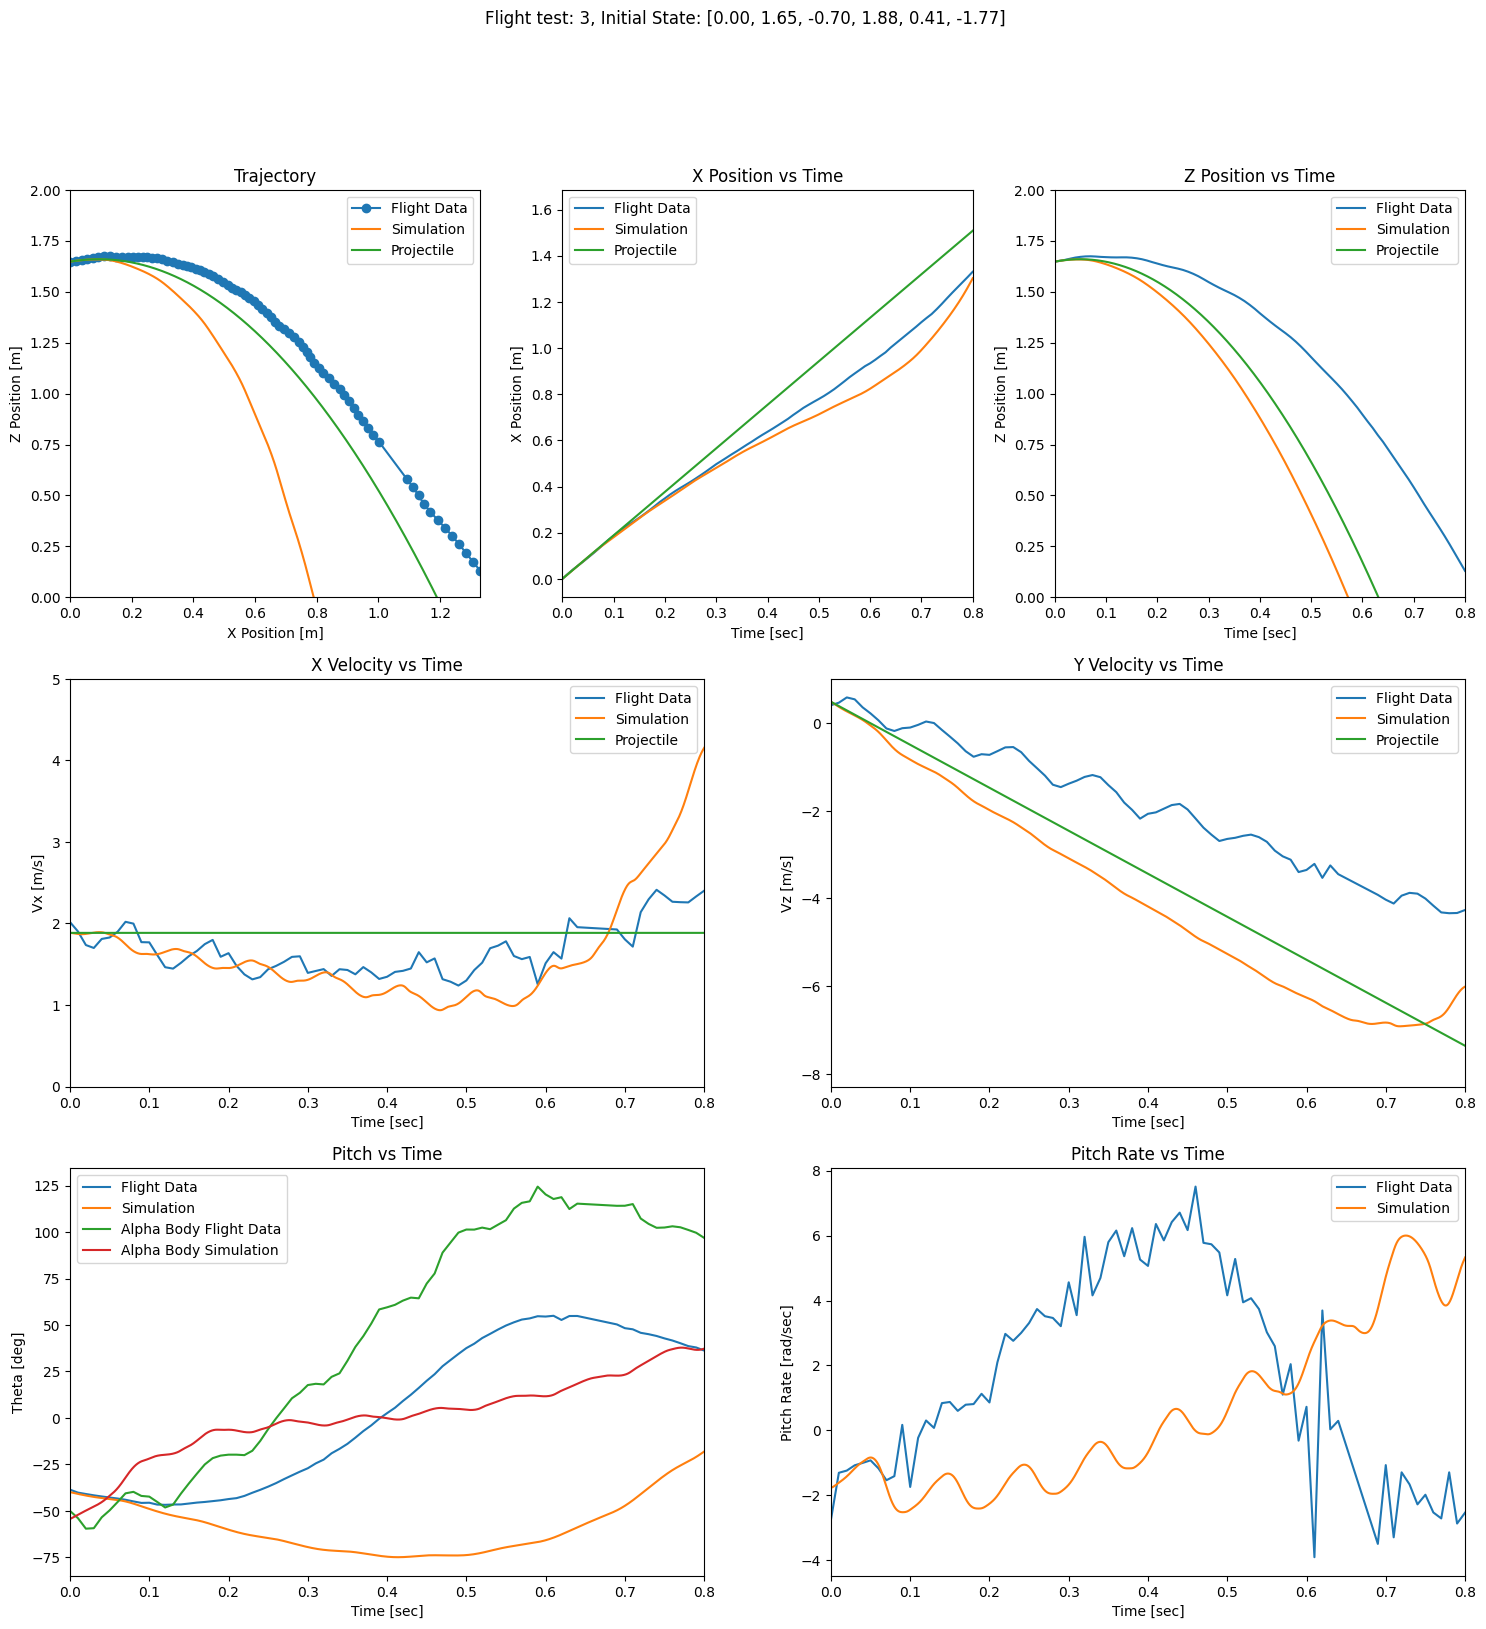

In [ ]:
trial = data[3]

t = trial['time']

x = trial['Tx']
y = trial['Ty']
z = trial['Tz']

vx = trial['Vx']
vz = trial['Vz']

Fx = m*trial['Ax']
Fz = m*trial['Az']

rx = trial["Rx"]
ry = trial["Ry"]
rz = trial["Rz"]

Wx = trial["Wx"]
Wy = trial["Wy"]
Wz = trial["Wz"]

My = Jz*trial['Alphay']
# print("here", z.iloc[-1], x.iloc[-1], t.iloc[-1])
tArr, results, wing_force, tail_force, alphaArr = simulation(vx[0:3].mean(), np.degrees(ry[0:3].mean()), vz[0:3].mean(), Wy[0:3].mean(), np.pi*4/4, np.pi*4/4)

x_norm = vx[0:3].mean()*tArr
y_norm = z[0] + vz[0:3].mean()*tArr - 0.5*g*tArr**2
vx_norm = vx[0:3].mean()*np.ones(len(tArr))
vy_norm = vz[0:3].mean()*np.ones(len(tArr)) - g*tArr

plt.figure(figsize=(18, 18))
plt.subplot(3, 3, 1)
plt.suptitle(f'Flight test: 3, Initial State: [{0:.2f}, {z[0]:.2f}, {ry[0:3].mean():.2f}, {vx[0:3].mean():.2f}, {vz[0]:.2f}, {Wy[0:3].mean():.2f}]')
plt.title("Trajectory")
plt.plot(x[:] - x[0], z[:], marker='o', label="Flight Data")
#plt.plot(x[:] - x[174], y[:], label="Flight Data y")
plt.plot(results[:, 0], results[:, 1]-(10-z[0]), label="Simulation")
plt.plot(x_norm, y_norm, label="Projectile")
plt.xlabel("X Position [m]")
plt.ylabel("Z Position [m]")
plt.legend()
plt.ylim(0, 2)
plt.xlim(0, x.iloc[-1]-x.iloc[0])

plt.subplot(3, 3, 2)
plt.title("X Position vs Time")
plt.plot(t[:]-t[0], x[:] - x[0], label="Flight Data")
plt.plot(tArr, results[:, 0],  label="Simulation")
plt.plot(tArr, x_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("X Position [m]")
plt.legend()
# plt.ylim(0, x.iloc[-1])
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 3, 3)
plt.title("Z Position vs Time")
plt.plot(t[:]-t[0], z[:], label="Flight Data")
plt.plot(tArr, results[:, 1]-(10-z[0]),  label="Simulation")
plt.plot(tArr, y_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Z Position [m]")
plt.legend()
plt.ylim(0, 2)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 3)
plt.title("X Velocity vs Time")
plt.plot(t[:]-t[0], vx[:], label="Flight Data")
plt.plot(tArr, results[:, 3],  label="Simulation")
plt.plot(tArr, vx_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Vx [m/s]")
plt.legend()
plt.ylim(0, 5)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 4)
plt.title("Y Velocity vs Time")
plt.plot(t[:]-t[0], vz, label="Flight Data")
plt.plot(tArr, results[:, 4],  label="Simulation")
plt.plot(tArr, vy_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Vz [m/s]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 5)
plt.title("Pitch vs Time")
#plt.plot(t[:]-t[0], np.degrees(rx[:]), label="Flight Data")
plt.plot(t[:]-t[0], np.degrees(ry[:]), label="Flight Data")
#plt.plot(t[:]-t[0], np.degrees(rz[:]), label="Flight Data")
plt.plot(tArr, np.degrees(results[:, 2]),  label="Simulation")
#plt.plot(tArr, np.degrees(alphaArr),  label="Alpha Wing Simulation")
plt.plot(t[:]-t[0], np.degrees(ry[:] - np.arctan2(vz[:], vx[:])), label="Alpha Body Flight Data")
plt.plot(tArr, np.degrees(results[:, 2] - np.arctan2(results[:, 4], results[:, 3])), label="Alpha Body Simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Theta [deg]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 6)
plt.title("Pitch Rate vs Time")
plt.plot(t[:]-t[0], (Wy[:]), label="Flight Data")
plt.plot(tArr, (results[:, 5]),  label="Simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Pitch Rate [rad/sec]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.tight_layout()
plt.show()

##Trial 4

<ipython-input-276-84914217033e>:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha_Arr[i] = wing_left.alpha_COP
<ipython-input-278-828092456b04>:115: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


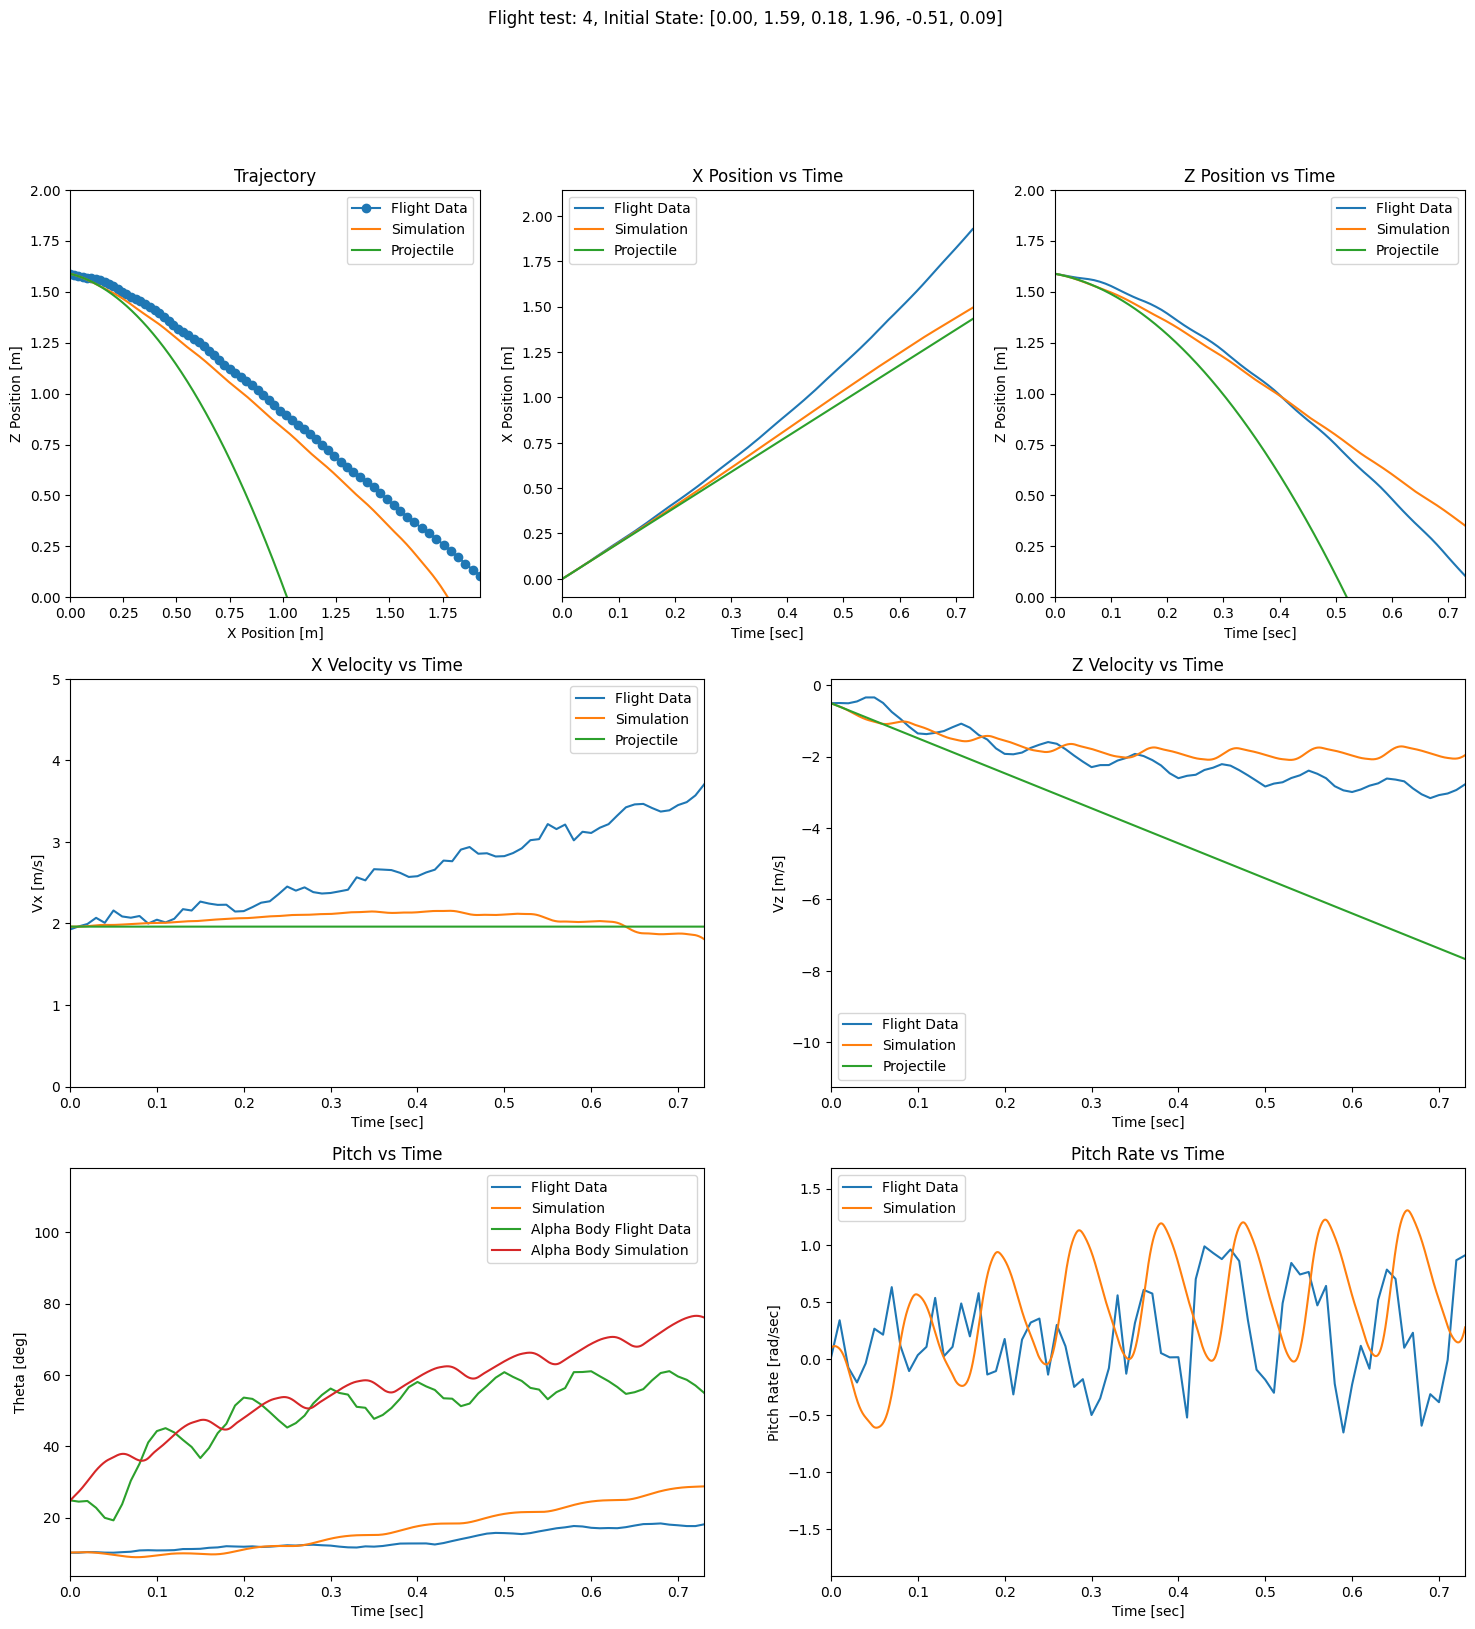

In [ ]:
trial = data[4]

t = trial['time']

x = trial['Tx']
y = trial['Ty']
z = trial['Tz']

vx = trial['Vx']
vz = trial['Vz']

Fx = m*trial['Ax']
Fz = m*trial['Az']

rx = trial["Rx"]
ry = trial["Ry"]
rz = trial["Rz"]

Wx = trial["Wx"]
Wy = trial["Wy"]
Wz = trial["Wz"]

My = Jz*trial['Alphay']
# print("here", z.iloc[-1], x.iloc[-1], t.iloc[-1])
tArr, results, wing_force, tail_force, alphaArr = simulation(vx[0:3].mean(), np.degrees(ry[0:3].mean()), vz[0:3].mean(), Wy[0:3].mean(), np.pi*0/16, np.pi*0/16)

x_norm = vx[0:3].mean()*tArr
y_norm = z[0] + vz[0:3].mean()*tArr - 0.5*g*tArr**2
vx_norm = vx[0:3].mean()*np.ones(len(tArr))
vy_norm = vz[0:3].mean()*np.ones(len(tArr)) - g*tArr

plt.figure(figsize=(18, 18))
plt.subplot(3, 3, 1)
plt.suptitle(f'Flight test: 4, Initial State: [{0:.2f}, {z[0]:.2f}, {ry[0:3].mean():.2f}, {vx[0:3].mean():.2f}, {vz[0]:.2f}, {Wy[0:3].mean():.2f}]')
plt.title("Trajectory")
plt.plot(x[:] - x[0], z[:], marker='o', label="Flight Data")
#plt.plot(x[:] - x[174], y[:], label="Flight Data y")
plt.plot(results[:, 0], results[:, 1]-(10-z[0]), label="Simulation")
plt.plot(x_norm, y_norm, label="Projectile")
plt.xlabel("X Position [m]")
plt.ylabel("Z Position [m]")
plt.legend()
plt.ylim(0, 2)
plt.xlim(0, x.iloc[-1]-x.iloc[0])

plt.subplot(3, 3, 2)
plt.title("X Position vs Time")
plt.plot(t[:]-t[0], x[:] - x[0], label="Flight Data")
plt.plot(tArr, results[:, 0],  label="Simulation")
plt.plot(tArr, x_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("X Position [m]")
plt.legend()
# plt.ylim(0, x.iloc[-1])
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 3, 3)
plt.title("Z Position vs Time")
plt.plot(t[:]-t[0], z[:], label="Flight Data")
plt.plot(tArr, results[:, 1]-(10-z[0]),  label="Simulation")
plt.plot(tArr, y_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Z Position [m]")
plt.legend()
plt.ylim(0, 2)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 3)
plt.title("X Velocity vs Time")
plt.plot(t[:]-t[0], vx[:], label="Flight Data")
plt.plot(tArr, results[:, 3],  label="Simulation")
plt.plot(tArr, vx_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Vx [m/s]")
plt.legend()
plt.ylim(0, 5)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 4)
plt.title("Z Velocity vs Time")
plt.plot(t[:]-t[0], vz, label="Flight Data")
plt.plot(tArr, results[:, 4],  label="Simulation")
plt.plot(tArr, vy_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Vz [m/s]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 5)
plt.title("Pitch vs Time")
#plt.plot(t[:]-t[0], np.degrees(rx[:]), label="Flight Data")
plt.plot(t[:]-t[0], np.degrees(ry[:]), label="Flight Data")
#plt.plot(t[:]-t[0], np.degrees(rz[:]), label="Flight Data")
plt.plot(tArr, np.degrees(results[:, 2]),  label="Simulation")
#plt.plot(tArr, np.degrees(alphaArr),  label="Alpha Wing Simulation")
plt.plot(t[:]-t[0], np.degrees(ry[:] - np.arctan2(vz[:], vx[:])), label="Alpha Body Flight Data")
plt.plot(tArr, np.degrees(results[:, 2] - np.arctan2(results[:, 4], results[:, 3])), label="Alpha Body Simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Theta [deg]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 6)
plt.title("Pitch Rate vs Time")
plt.plot(t[:]-t[0], (Wy[:]), label="Flight Data")
plt.plot(tArr, (results[:, 5]),  label="Simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Pitch Rate [rad/sec]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.tight_layout()
plt.show()

##Trial 5

<ipython-input-10-84914217033e>:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha_Arr[i] = wing_left.alpha_COP
<ipython-input-30-51f1707e9687>:115: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


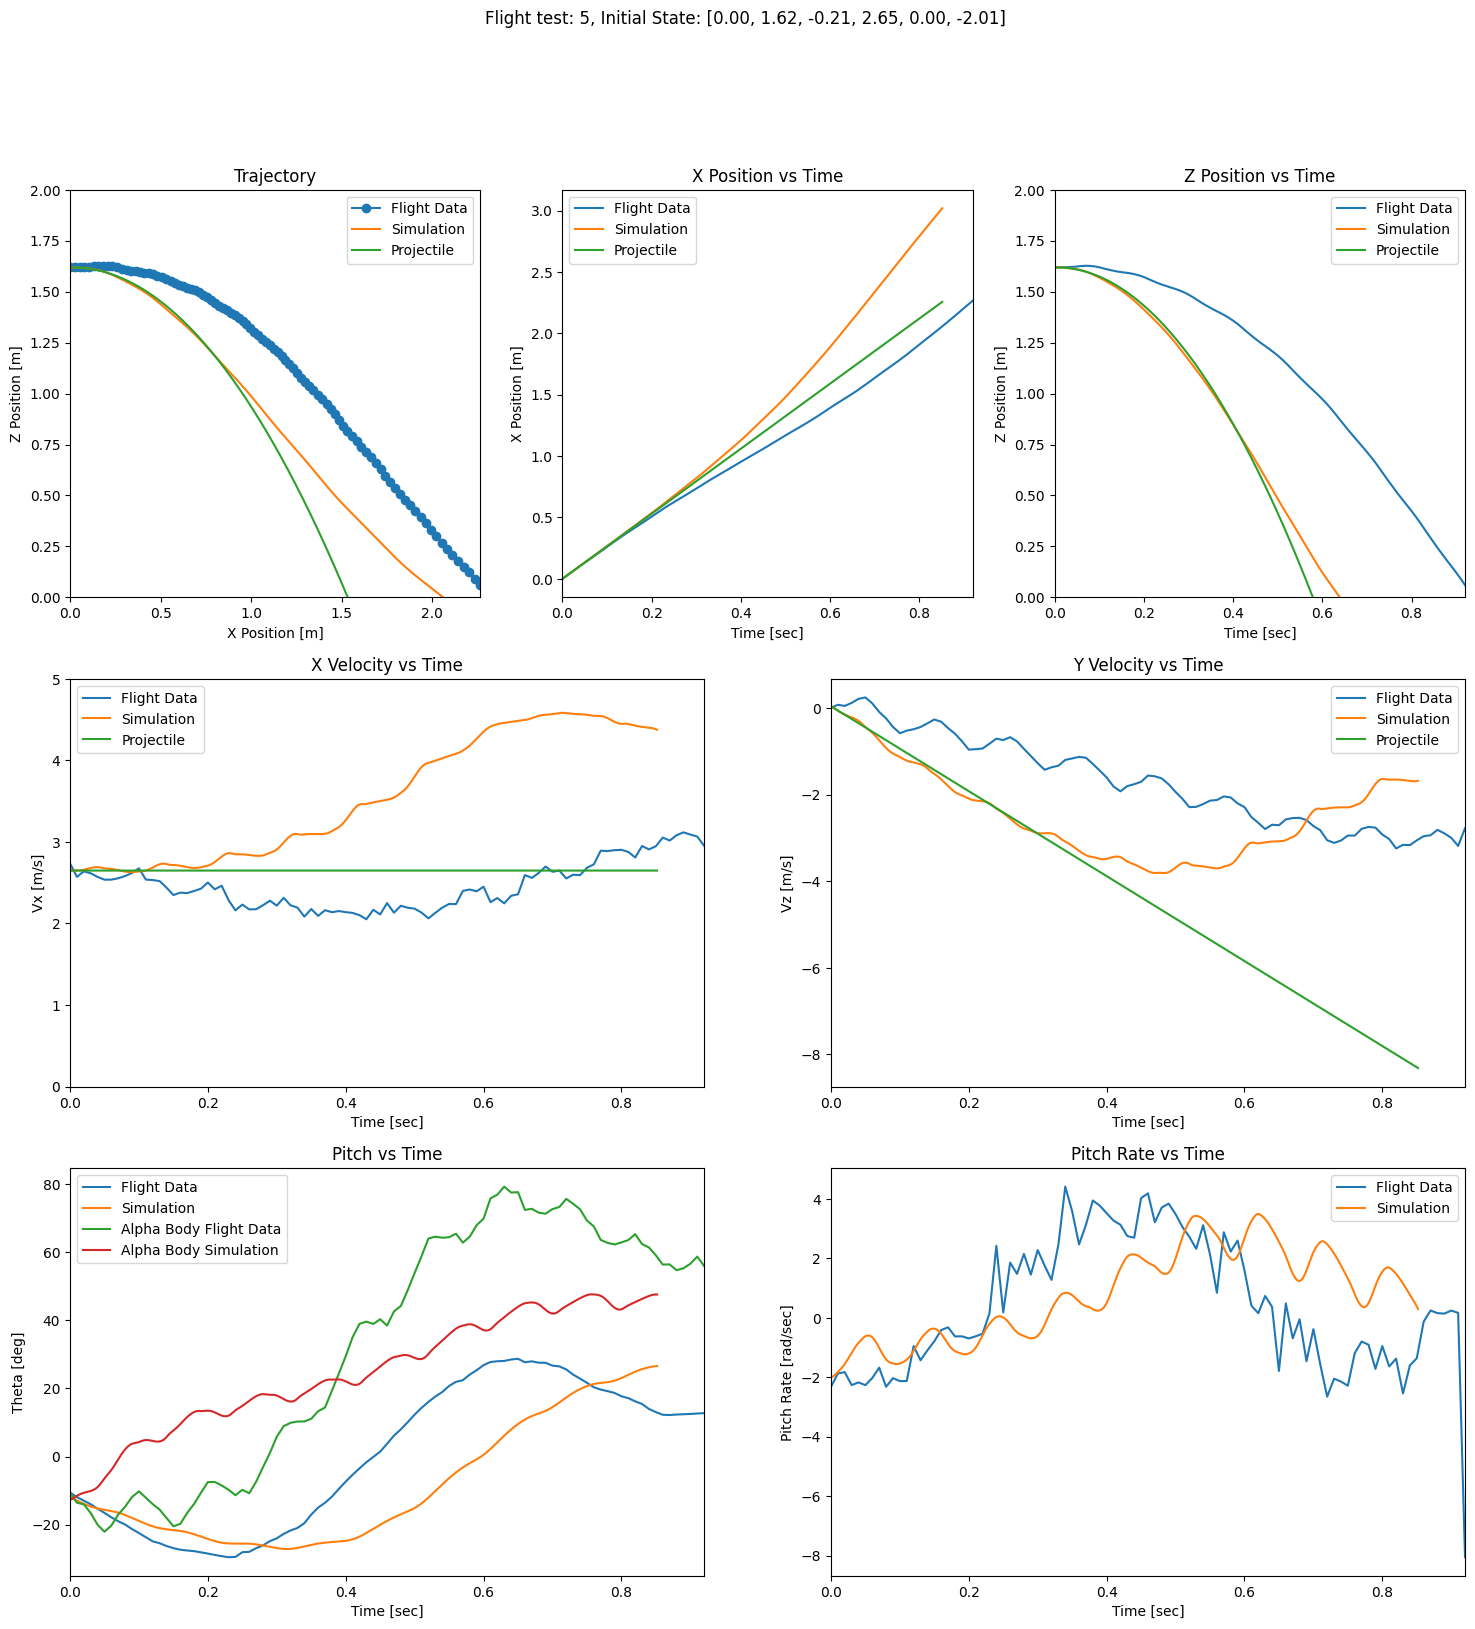

In [ ]:
trial = data[5]

t = trial['time']

x = trial['Tx']
y = trial['Ty']
z = trial['Tz']

vx = trial['Vx']
vz = trial['Vz']

Fx = m*trial['Ax']
Fz = m*trial['Az']

rx = trial["Rx"]
ry = trial["Ry"]
rz = trial["Rz"]

Wx = trial["Wx"]
Wy = trial["Wy"]
Wz = trial["Wz"]

My = Jz*trial['Alphay']
# print("here", z.iloc[-1], x.iloc[-1], t.iloc[-1])
tArr, results, wing_force, tail_force, alphaArr = simulation(vx[0:3].mean(), np.degrees(ry[0:3].mean()), vz[0:3].mean(), Wy[0:3].mean(), np.pi*4/4, np.pi*4/4)

x_norm = vx[0:3].mean()*tArr
y_norm = z[0] + vz[0:3].mean()*tArr - 0.5*g*tArr**2
vx_norm = vx[0:3].mean()*np.ones(len(tArr))
vy_norm = vz[0:3].mean()*np.ones(len(tArr)) - g*tArr

plt.figure(figsize=(18, 18))
plt.subplot(3, 3, 1)
plt.suptitle(f'Flight test: 5, Initial State: [{0:.2f}, {z[0]:.2f}, {ry[0:3].mean():.2f}, {vx[0:3].mean():.2f}, {vz[0]:.2f}, {Wy[0:3].mean():.2f}]')
plt.title("Trajectory")
plt.plot(x[:] - x[0], z[:], marker='o', label="Flight Data")
#plt.plot(x[:] - x[174], y[:], label="Flight Data y")
plt.plot(results[:, 0], results[:, 1]-(10-z[0]), label="Simulation")
plt.plot(x_norm, y_norm, label="Projectile")
plt.xlabel("X Position [m]")
plt.ylabel("Z Position [m]")
plt.legend()
plt.ylim(0, 2)
plt.xlim(0, x.iloc[-1]-x.iloc[0])

plt.subplot(3, 3, 2)
plt.title("X Position vs Time")
plt.plot(t[:]-t[0], x[:] - x[0], label="Flight Data")
plt.plot(tArr, results[:, 0],  label="Simulation")
plt.plot(tArr, x_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("X Position [m]")
plt.legend()
# plt.ylim(0, x.iloc[-1])
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 3, 3)
plt.title("Z Position vs Time")
plt.plot(t[:]-t[0], z[:], label="Flight Data")
plt.plot(tArr, results[:, 1]-(10-z[0]),  label="Simulation")
plt.plot(tArr, y_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Z Position [m]")
plt.legend()
plt.ylim(0, 2)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 3)
plt.title("X Velocity vs Time")
plt.plot(t[:]-t[0], vx[:], label="Flight Data")
plt.plot(tArr, results[:, 3],  label="Simulation")
plt.plot(tArr, vx_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Vx [m/s]")
plt.legend()
plt.ylim(0, 5)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 4)
plt.title("Y Velocity vs Time")
plt.plot(t[:]-t[0], vz, label="Flight Data")
plt.plot(tArr, results[:, 4],  label="Simulation")
plt.plot(tArr, vy_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Vz [m/s]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 5)
plt.title("Pitch vs Time")
#plt.plot(t[:]-t[0], np.degrees(rx[:]), label="Flight Data")
plt.plot(t[:]-t[0], np.degrees(ry[:]), label="Flight Data")
#plt.plot(t[:]-t[0], np.degrees(rz[:]), label="Flight Data")
plt.plot(tArr, np.degrees(results[:, 2]),  label="Simulation")
#plt.plot(tArr, np.degrees(alphaArr),  label="Alpha Wing Simulation")
plt.plot(t[:]-t[0], np.degrees(ry[:] - np.arctan2(vz[:], vx[:])), label="Alpha Body Flight Data")
plt.plot(tArr, np.degrees(results[:, 2] - np.arctan2(results[:, 4], results[:, 3])), label="Alpha Body Simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Theta [deg]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 6)
plt.title("Pitch Rate vs Time")
plt.plot(t[:]-t[0], (Wy[:]), label="Flight Data")
plt.plot(tArr, (results[:, 5]),  label="Simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Pitch Rate [rad/sec]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.tight_layout()
plt.show()

##Trial 6

<ipython-input-10-84914217033e>:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha_Arr[i] = wing_left.alpha_COP
<ipython-input-26-797131f06d37>:115: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


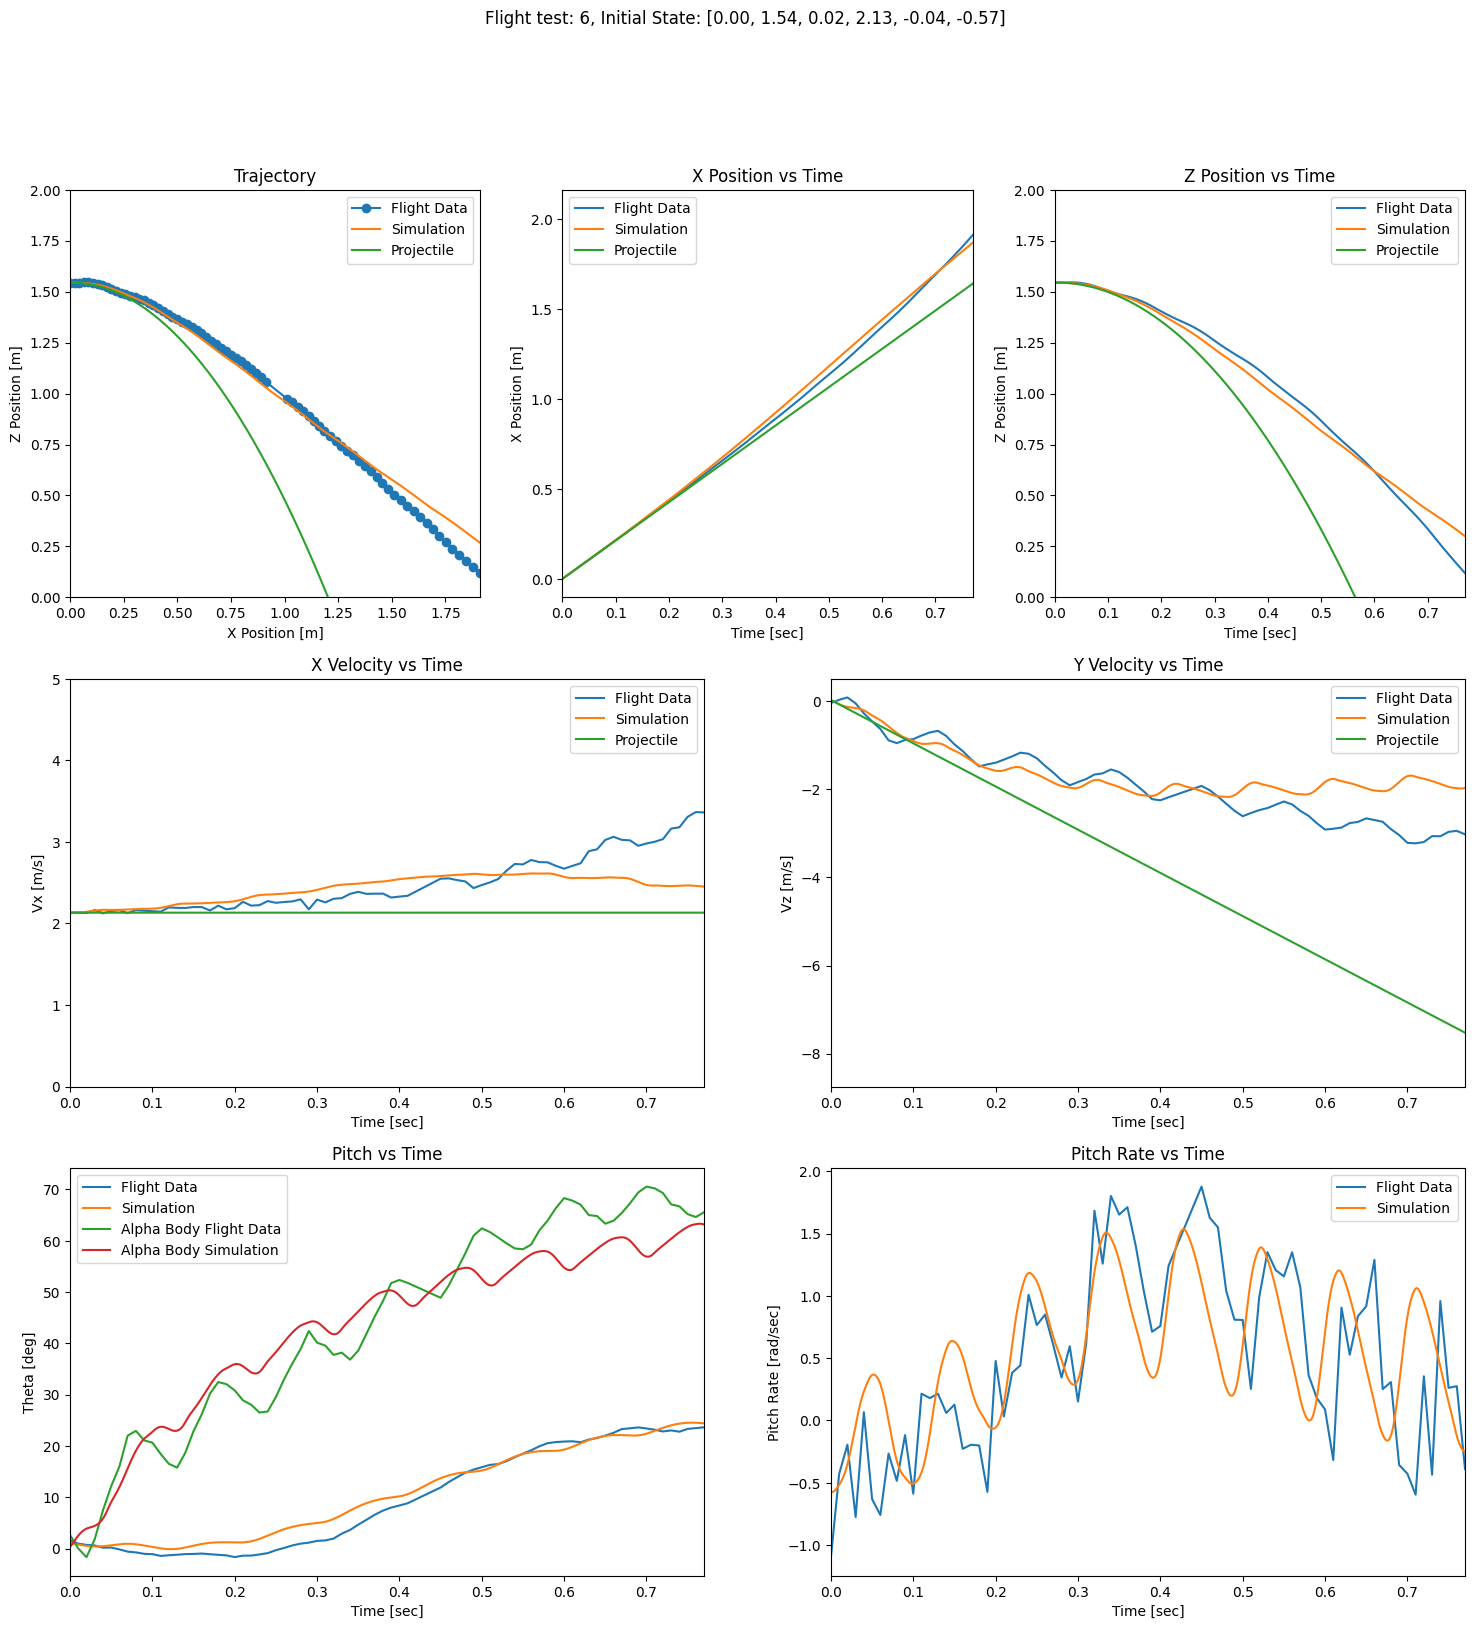

In [ ]:
trial = data[6]

t = trial['time']

x = trial['Tx']
y = trial['Ty']
z = trial['Tz']

vx = trial['Vx']
vz = trial['Vz']

Fx = m*trial['Ax']
Fz = m*trial['Az']

rx = trial["Rx"]
ry = trial["Ry"]
rz = trial["Rz"]

Wx = trial["Wx"]
Wy = trial["Wy"]
Wz = trial["Wz"]

My = Jz*trial['Alphay']
# print("here", z.iloc[-1], x.iloc[-1], t.iloc[-1])
tArr, results, wing_force, tail_force, alphaArr = simulation(vx[0:3].mean(), np.degrees(ry[0:3].mean()), vz[0:3].mean(), Wy[0:3].mean(), np.pi*4/4, np.pi*4/4)

x_norm = vx[0:3].mean()*tArr
y_norm = z[0] + vz[0:3].mean()*tArr - 0.5*g*tArr**2
vx_norm = vx[0:3].mean()*np.ones(len(tArr))
vy_norm = vz[0:3].mean()*np.ones(len(tArr)) - g*tArr

plt.figure(figsize=(18, 18))
plt.subplot(3, 3, 1)
plt.suptitle(f'Flight test: 6, Initial State: [{0:.2f}, {z[0]:.2f}, {ry[0:3].mean():.2f}, {vx[0:3].mean():.2f}, {vz[0]:.2f}, {Wy[0:3].mean():.2f}]')
plt.title("Trajectory")
plt.plot(x[:] - x[0], z[:], marker='o', label="Flight Data")
#plt.plot(x[:] - x[174], y[:], label="Flight Data y")
plt.plot(results[:, 0], results[:, 1]-(10-z[0]), label="Simulation")
plt.plot(x_norm, y_norm, label="Projectile")
plt.xlabel("X Position [m]")
plt.ylabel("Z Position [m]")
plt.legend()
plt.ylim(0, 2)
plt.xlim(0, x.iloc[-1]-x.iloc[0])

plt.subplot(3, 3, 2)
plt.title("X Position vs Time")
plt.plot(t[:]-t[0], x[:] - x[0], label="Flight Data")
plt.plot(tArr, results[:, 0],  label="Simulation")
plt.plot(tArr, x_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("X Position [m]")
plt.legend()
# plt.ylim(0, x.iloc[-1])
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 3, 3)
plt.title("Z Position vs Time")
plt.plot(t[:]-t[0], z[:], label="Flight Data")
plt.plot(tArr, results[:, 1]-(10-z[0]),  label="Simulation")
plt.plot(tArr, y_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Z Position [m]")
plt.legend()
plt.ylim(0, 2)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 3)
plt.title("X Velocity vs Time")
plt.plot(t[:]-t[0], vx[:], label="Flight Data")
plt.plot(tArr, results[:, 3],  label="Simulation")
plt.plot(tArr, vx_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Vx [m/s]")
plt.legend()
plt.ylim(0, 5)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 4)
plt.title("Y Velocity vs Time")
plt.plot(t[:]-t[0], vz, label="Flight Data")
plt.plot(tArr, results[:, 4],  label="Simulation")
plt.plot(tArr, vy_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Vz [m/s]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 5)
plt.title("Pitch vs Time")
#plt.plot(t[:]-t[0], np.degrees(rx[:]), label="Flight Data")
plt.plot(t[:]-t[0], np.degrees(ry[:]), label="Flight Data")
#plt.plot(t[:]-t[0], np.degrees(rz[:]), label="Flight Data")
plt.plot(tArr, np.degrees(results[:, 2]),  label="Simulation")
#plt.plot(tArr, np.degrees(alphaArr),  label="Alpha Wing Simulation")
plt.plot(t[:]-t[0], np.degrees(ry[:] - np.arctan2(vz[:], vx[:])), label="Alpha Body Flight Data")
plt.plot(tArr, np.degrees(results[:, 2] - np.arctan2(results[:, 4], results[:, 3])), label="Alpha Body Simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Theta [deg]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 6)
plt.title("Pitch Rate vs Time")
plt.plot(t[:]-t[0], (Wy[:]), label="Flight Data")
plt.plot(tArr, (results[:, 5]),  label="Simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Pitch Rate [rad/sec]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.tight_layout()
plt.show()

##Trial 7

<ipython-input-10-84914217033e>:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha_Arr[i] = wing_left.alpha_COP
<ipython-input-25-94c088cdf0b1>:115: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


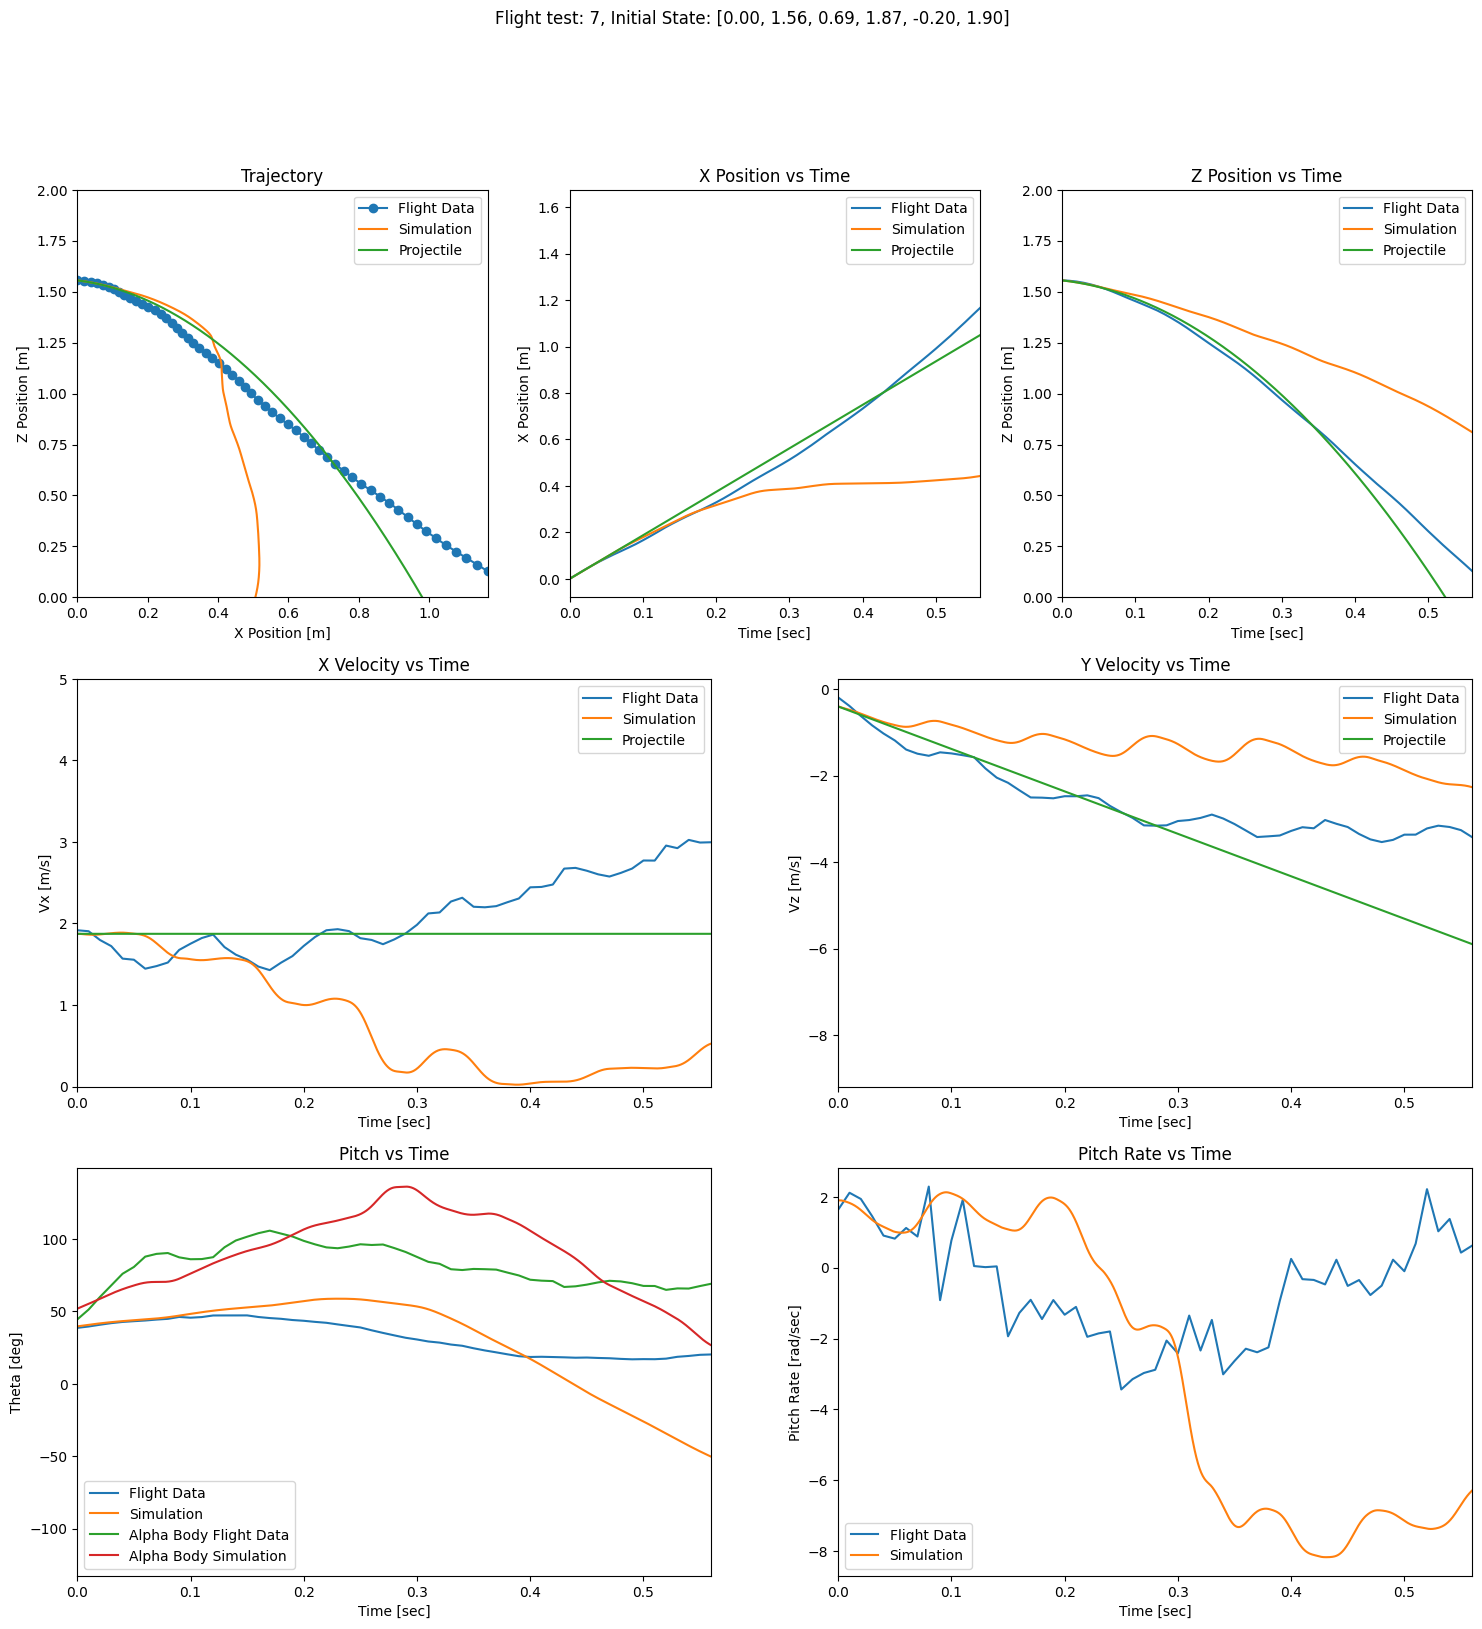

In [ ]:
trial = data[7]

t = trial['time']

x = trial['Tx']
y = trial['Ty']
z = trial['Tz']

vx = trial['Vx']
vz = trial['Vz']

Fx = m*trial['Ax']
Fz = m*trial['Az']

rx = trial["Rx"]
ry = trial["Ry"]
rz = trial["Rz"]

Wx = trial["Wx"]
Wy = trial["Wy"]
Wz = trial["Wz"]

My = Jz*trial['Alphay']
# print("here", z.iloc[-1], x.iloc[-1], t.iloc[-1])
tArr, results, wing_force, tail_force, alphaArr = simulation(vx[0:3].mean(), np.degrees(ry[0:3].mean()), vz[0:3].mean(), Wy[0:3].mean(), np.pi*0/4, np.pi*0/4)

x_norm = vx[0:3].mean()*tArr
y_norm = z[0] + vz[0:3].mean()*tArr - 0.5*g*tArr**2
vx_norm = vx[0:3].mean()*np.ones(len(tArr))
vy_norm = vz[0:3].mean()*np.ones(len(tArr)) - g*tArr

plt.figure(figsize=(18, 18))
plt.subplot(3, 3, 1)
plt.suptitle(f'Flight test: 7, Initial State: [{0:.2f}, {z[0]:.2f}, {ry[0:3].mean():.2f}, {vx[0:3].mean():.2f}, {vz[0]:.2f}, {Wy[0:3].mean():.2f}]')
plt.title("Trajectory")
plt.plot(x[:] - x[0], z[:], marker='o', label="Flight Data")
#plt.plot(x[:] - x[174], y[:], label="Flight Data y")
plt.plot(results[:, 0], results[:, 1]-(10-z[0]), label="Simulation")
plt.plot(x_norm, y_norm, label="Projectile")
plt.xlabel("X Position [m]")
plt.ylabel("Z Position [m]")
plt.legend()
plt.ylim(0, 2)
plt.xlim(0, x.iloc[-1]-x.iloc[0])

plt.subplot(3, 3, 2)
plt.title("X Position vs Time")
plt.plot(t[:]-t[0], x[:] - x[0], label="Flight Data")
plt.plot(tArr, results[:, 0],  label="Simulation")
plt.plot(tArr, x_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("X Position [m]")
plt.legend()
# plt.ylim(0, x.iloc[-1])
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 3, 3)
plt.title("Z Position vs Time")
plt.plot(t[:]-t[0], z[:], label="Flight Data")
plt.plot(tArr, results[:, 1]-(10-z[0]),  label="Simulation")
plt.plot(tArr, y_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Z Position [m]")
plt.legend()
plt.ylim(0, 2)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 3)
plt.title("X Velocity vs Time")
plt.plot(t[:]-t[0], vx[:], label="Flight Data")
plt.plot(tArr, results[:, 3],  label="Simulation")
plt.plot(tArr, vx_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Vx [m/s]")
plt.legend()
plt.ylim(0, 5)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 4)
plt.title("Y Velocity vs Time")
plt.plot(t[:]-t[0], vz, label="Flight Data")
plt.plot(tArr, results[:, 4],  label="Simulation")
plt.plot(tArr, vy_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Vz [m/s]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 5)
plt.title("Pitch vs Time")
#plt.plot(t[:]-t[0], np.degrees(rx[:]), label="Flight Data")
plt.plot(t[:]-t[0], np.degrees(ry[:]), label="Flight Data")
#plt.plot(t[:]-t[0], np.degrees(rz[:]), label="Flight Data")
plt.plot(tArr, np.degrees(results[:, 2]),  label="Simulation")
#plt.plot(tArr, np.degrees(alphaArr),  label="Alpha Wing Simulation")
plt.plot(t[:]-t[0], np.degrees(ry[:] - np.arctan2(vz[:], vx[:])), label="Alpha Body Flight Data")
plt.plot(tArr, np.degrees(results[:, 2] - np.arctan2(results[:, 4], results[:, 3])), label="Alpha Body Simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Theta [deg]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 6)
plt.title("Pitch Rate vs Time")
plt.plot(t[:]-t[0], (Wy[:]), label="Flight Data")
plt.plot(tArr, (results[:, 5]),  label="Simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Pitch Rate [rad/sec]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.tight_layout()
plt.show()

##Comparison of States

here 0.168933304 -1.118077759 2.7600000000000002
(2.239575199999999, -0.83955, 0.4631225999999877, -4.049800000000003)


<ipython-input-127-6603442621bd>:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha_Arr[i] = wing_left.alpha_COP
<ipython-input-121-e58dbe823d5b>:91: RuntimeWarning: invalid value encountered in scalar power
  K_PM = 0.803*((self.J + self.Wingshape.rhatM)**-0.972) + -0.363
<ipython-input-121-e58dbe823d5b>:92: RuntimeWarning: invalid value encountered in scalar power
  K_VM = -0.242*((self.J + self.Wingshape.rhatM)**-1.354) + -0.554
<ipython-input-145-90ff2d352646>:116: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


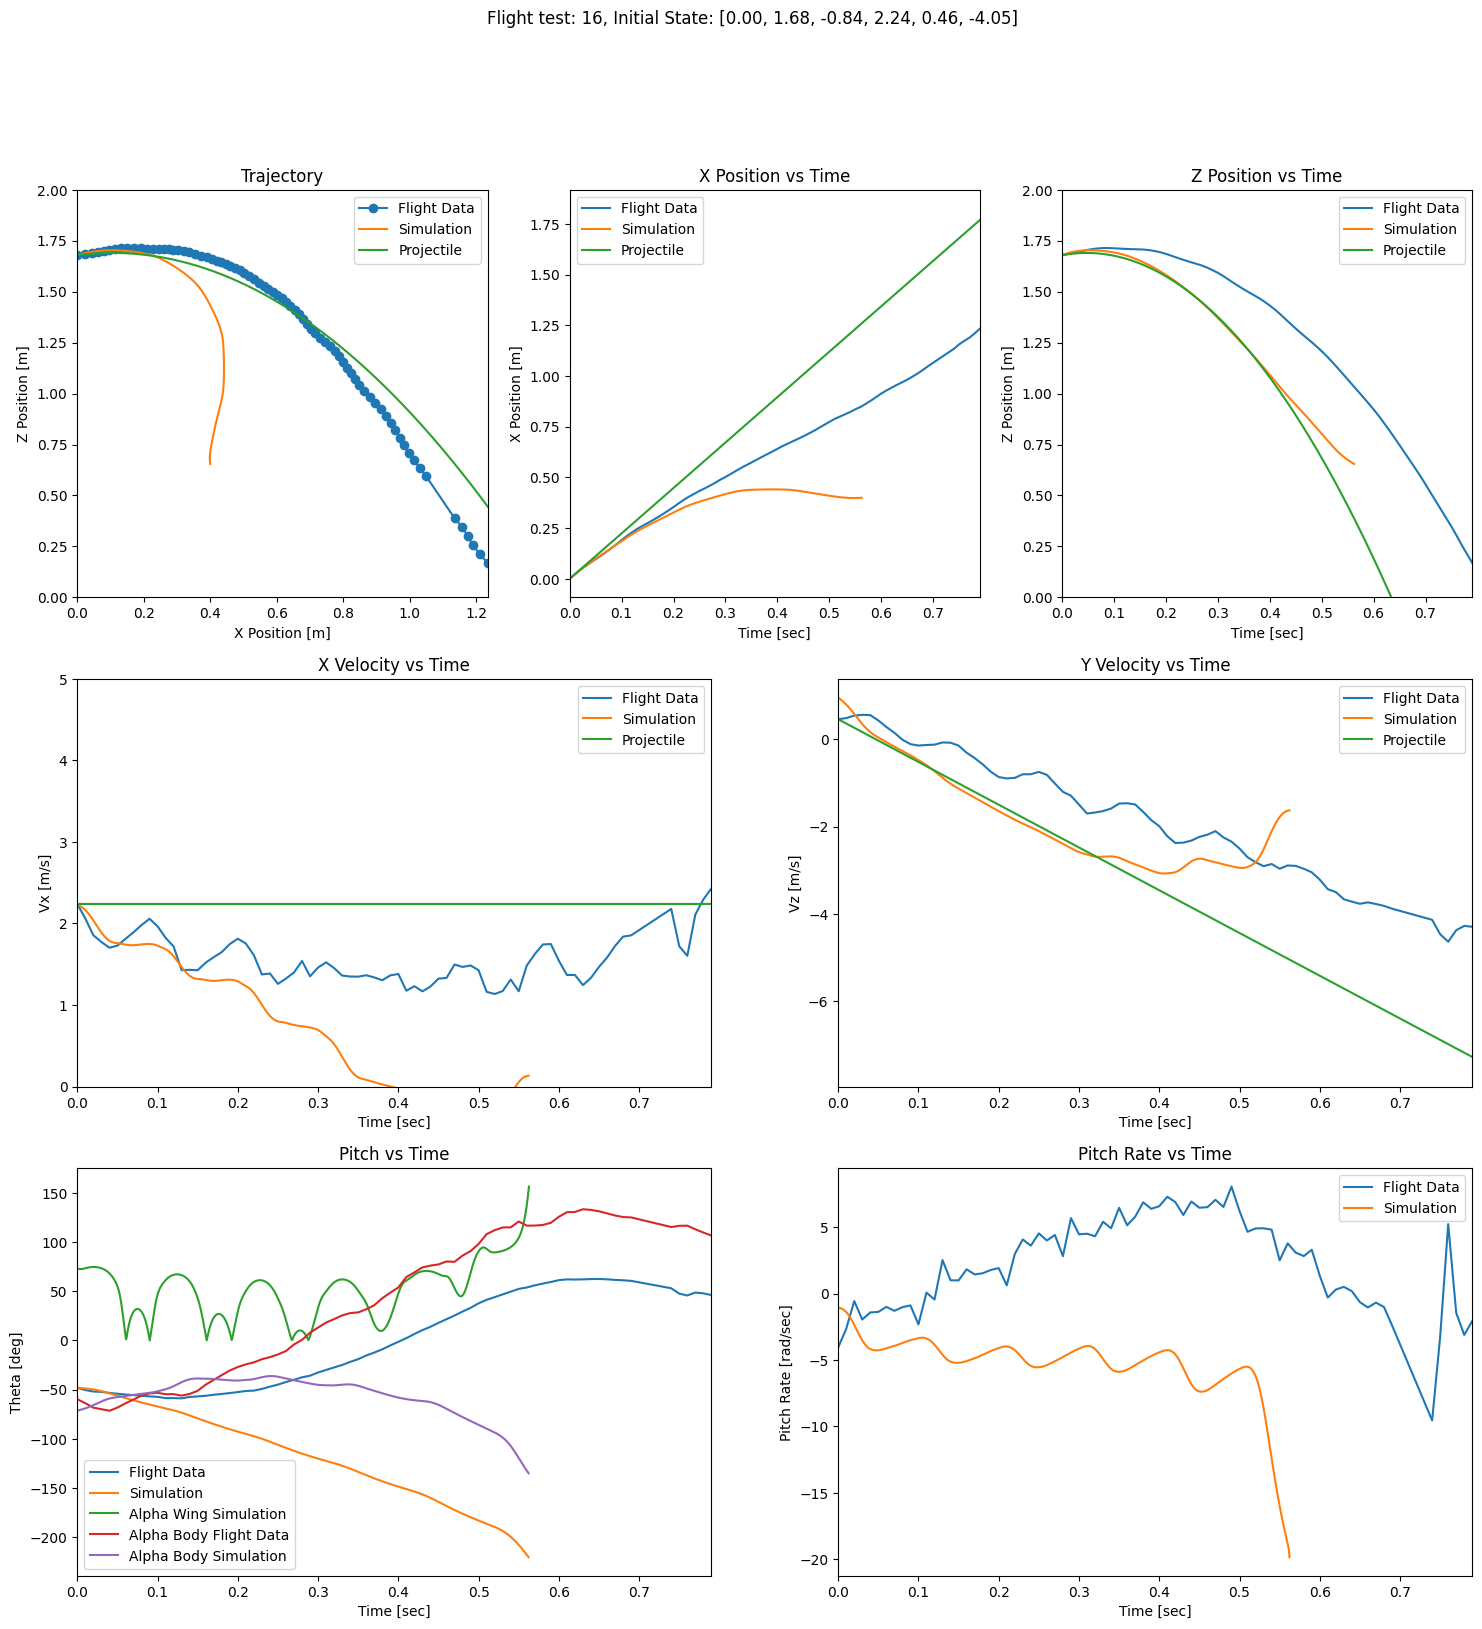

In [ ]:
trial = data[10]

t = trial['time']

x = trial['Tx']
y = trial['Ty']
z = trial['Tz']

vx = trial['Vx']
vz = trial['Vz']

Fx = m*trial['Ax']
Fz = m*trial['Az']

rx = trial["Rx"]
ry = trial["Ry"]
rz = trial["Rz"]

Wx = trial["Wx"]
Wy = trial["Wy"]
Wz = trial["Wz"]

My = Jz*trial['Alphay']
print("here", z.iloc[-1], x.iloc[-1], t.iloc[-1])
print((vx[0], ry[0], vz[0], Wy[0]))
tArr, results, wing_force, tail_force, alphaArr = simulation(vx[0], np.degrees(ry[0]), vz[0]+0.5, Wy[0]+3)

x_norm = vx[0]*tArr
y_norm = z[0] + vz[0]*tArr - 0.5*g*tArr**2
vx_norm = vx[0]*np.ones(len(tArr))
vy_norm = vz[0]*np.ones(len(tArr)) - g*tArr

plt.figure(figsize=(18, 18))
plt.subplot(3, 3, 1)
plt.suptitle(f'Flight test: {i}, Initial State: [{0:.2f}, {z[0]:.2f}, {ry[0]:.2f}, {vx[0]:.2f}, {vz[0]:.2f}, {Wy[0]:.2f}]')
plt.title("Trajectory")
plt.plot(x[:] - x[0], z[:], marker='o', label="Flight Data")
#plt.plot(x[:] - x[174], y[:], label="Flight Data y")
plt.plot(results[:, 0], results[:, 1]-(10-z[0]), label="Simulation")
plt.plot(x_norm, y_norm, label="Projectile")
plt.xlabel("X Position [m]")
plt.ylabel("Z Position [m]")
plt.legend()
plt.ylim(0, 2)
plt.xlim(0, x.iloc[-1]-x.iloc[0])

plt.subplot(3, 3, 2)
plt.title("X Position vs Time")
plt.plot(t[:]-t[0], x[:] - x[0], label="Flight Data")
plt.plot(tArr, results[:, 0],  label="Simulation")
plt.plot(tArr, x_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("X Position [m]")
plt.legend()
# plt.ylim(0, x.iloc[-1])
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 3, 3)
plt.title("Z Position vs Time")
plt.plot(t[:]-t[0], z[:], label="Flight Data")
plt.plot(tArr, results[:, 1]-(10-z[0]),  label="Simulation")
plt.plot(tArr, y_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Z Position [m]")
plt.legend()
plt.ylim(0, 2)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 3)
plt.title("X Velocity vs Time")
plt.plot(t[:]-t[0], vx[:], label="Flight Data")
plt.plot(tArr, results[:, 3],  label="Simulation")
plt.plot(tArr, vx_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Vx [m/s]")
plt.legend()
plt.ylim(0, 5)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 4)
plt.title("Y Velocity vs Time")
plt.plot(t[:]-t[0], vz, label="Flight Data")
plt.plot(tArr, results[:, 4],  label="Simulation")
plt.plot(tArr, vy_norm,  label="Projectile")
plt.xlabel("Time [sec]")
plt.ylabel("Vz [m/s]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 5)
plt.title("Pitch vs Time")
#plt.plot(t[:]-t[0], np.degrees(rx[:]), label="Flight Data")
plt.plot(t[:]-t[0], np.degrees(ry[:]), label="Flight Data")
#plt.plot(t[:]-t[0], np.degrees(rz[:]), label="Flight Data")
plt.plot(tArr, np.degrees(results[:, 2]),  label="Simulation")
plt.plot(tArr, np.degrees(alphaArr),  label="Alpha Wing Simulation")
plt.plot(t[:]-t[0], np.degrees(ry[:] - np.arctan2(vz[:], vx[:])), label="Alpha Body Flight Data")
plt.plot(tArr, np.degrees(results[:, 2] - np.arctan2(results[:, 4], results[:, 3])), label="Alpha Body Simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Theta [deg]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.subplot(3, 2, 6)
plt.title("Pitch Rate vs Time")
plt.plot(t[:]-t[0], (Wy[:]), label="Flight Data")
plt.plot(tArr, (results[:, 5]),  label="Simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Pitch Rate [rad/sec]")
plt.legend()
# plt.ylim(-3, 1)
plt.xlim(0, t.iloc[-1]-t.iloc[0])

plt.tight_layout()
plt.show()

##Comparison of Forces


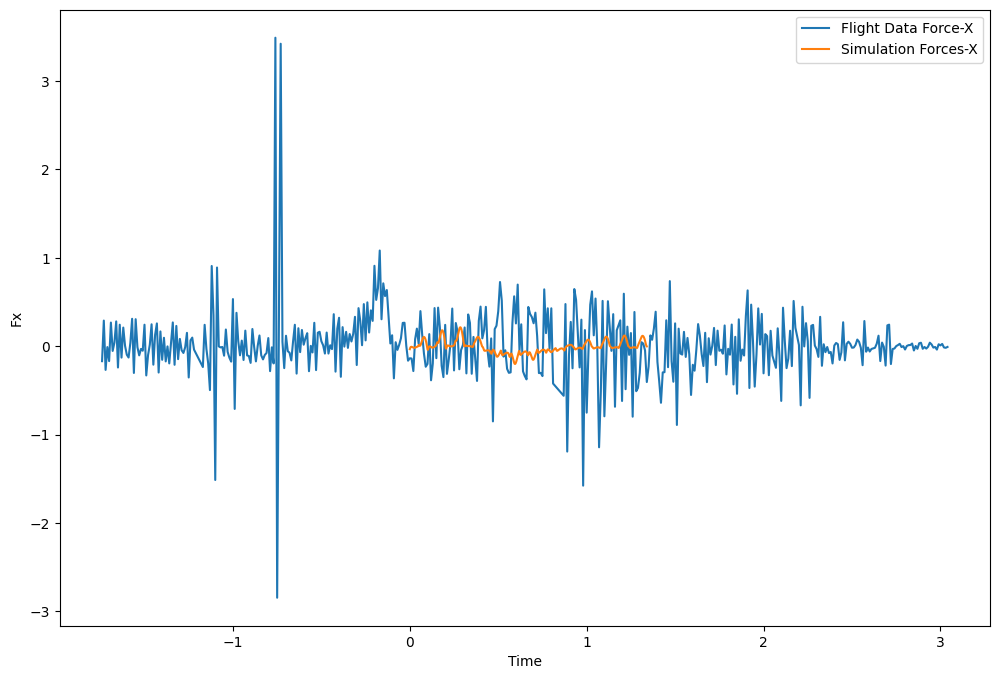

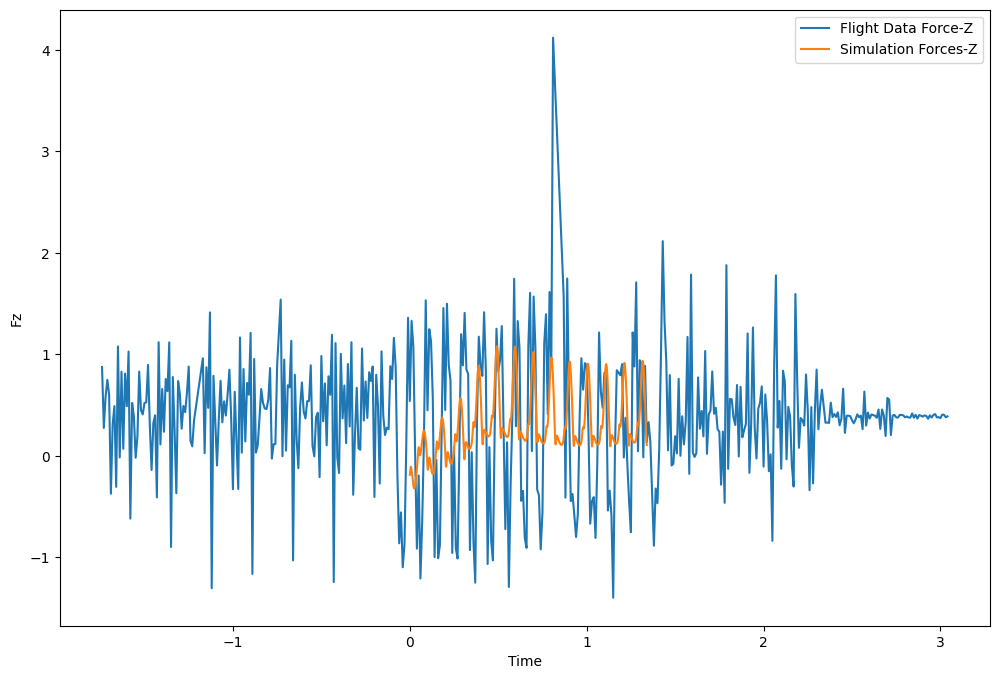

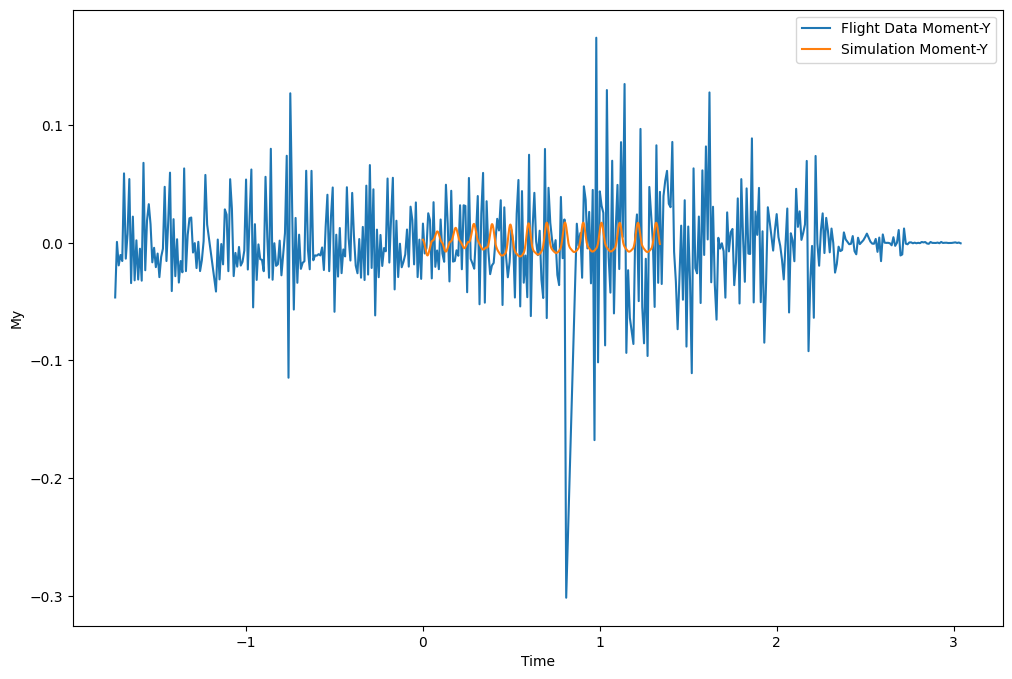

In [ ]:


Fx_sim = ((wing_force[:, 1] + tail_force[1, :])*-np.sin(results[:, 2]) + (wing_force[:, 0] + tail_force[0, :])*np.cos(results[:, 2]))
Fz_sim = (-m*g + (wing_force[:, 1] + tail_force[1, :])*np.cos(results[:, 2]) + (wing_force[:, 0] + tail_force[0, :])*np.sin(results[:, 2]))
My_sim = (r_wing*wing_force[:, 1] + r_tail*tail_force[1, :] + wing_moment[:, 0])

plt.figure(figsize=(12, 8))
plt.plot(t[:]-t[174], (Fx[:]), label="Flight Data Force-X")
plt.plot(tArr, ( Fx_sim),  label="Simulation Forces-X")
plt.xlabel("Time")
plt.ylabel("Fx")
plt.legend()
# plt.ylim(-3, 1)
# plt.xlim(0,0.8)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(t[:]-t[174], (Fz[:]+m*g), label="Flight Data Force-Z")
plt.plot(tArr, ( Fz_sim +m*g),  label="Simulation Forces-Z")
plt.xlabel("Time")
plt.ylabel("Fz")
plt.legend()
# plt.ylim(-3, 1)
# plt.xlim(0,0.8)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(t[:]-t[174], (My[:]), label="Flight Data Moment-Y")
plt.plot(tArr, ( My_sim),  label="Simulation Moment-Y")
plt.xlabel("Time")
plt.ylabel("My")
plt.legend()
# plt.ylim(-3, 1)
# plt.xlim(0,0.8)
plt.show()

#Double nested Main loop

In [ ]:
tArr = np.zeros(int(num_periods*t_period/t_step))
alpha_Arr = np.zeros(int(num_periods*t_period/t_step))
results = np.zeros((int(num_periods*t_period/t_step), 6))
wing_force = np.zeros((int(num_periods*t_period/t_step), 2))
wing_moment = np.zeros((int(num_periods*t_period/t_step), 1))
wing_angles = np.zeros((int(num_periods*t_period/t_step), 3))
wing_angle_vel = np.zeros((int(num_periods*t_period/t_step), 3))

time_sim = 0
time_flapping = 0
i = 0

Wingshape = WingShape(wing_length, AR_wing, 0)
wing_left = WingDynamics(side='left', Wingshape=Wingshape, v0=np.array([[2.5], [0], [0]]), glide=False, phi_dot=0)               #rectangle ellipse
wing_right = WingDynamics(side='right', Wingshape=Wingshape, v0=np.array([[2.5], [0], [0]]), glide=False, phi_dot=0)


state = [0, 10, np.radians(0), 2.5, 0, 0]
#results[:0] = state
#tArr[0] = time_sim
tmp_left = wing_left.force_calc()
tmp_right = wing_right.force_calc()

for j in range(num_periods):
    time_period = 0
    while time_period < t_period:
        results[i, :] = state
        if np.sign(state[2]) == 1:
            state[2] = state[2] % (2 * np.pi)
        else:
            state[2] = state[2] % (-2 * np.pi)

        wing_force[i, :] = [(tmp_left + tmp_right).item(0), -(tmp_left + tmp_right).item(2)]
        wing_moment[i, :] = [(tmp_left + tmp_right).item(4)]
        wing_angles[i, :] = [wing_left._state[7][0], wing_left._state[8][0], wing_left._state[9][0]]
        wing_angle_vel[i, :] = [wing_left._state[10][0], wing_left._state[11][0], wing_left._state[12][0]]

        tArr[i] = time_sim
        alpha_Arr[i] = wing_left.alpha

        time_sim = time_sim + t_step
        time_period = time_period + t_step
        if wing_left.glide == False:
            time_flapping = time_flapping + t_step
            if round(time_flapping, 8) >= round(t_period, 8):
                time_flapping = 0



        wing_left._state[3][0] = (state[3]*np.cos(state[2]) + state[4]*np.sin(state[2]))
        wing_left._state[4][0] = 0
        wing_left._state[5][0] = -(state[4]*np.cos(state[2]) - state[3]*np.sin(state[2]) + r_wing*state[5])

        wing_right._state[3][0] = (state[3]*np.cos(state[2]) + state[4]*np.sin(state[2]))
        wing_right._state[4][0] = 0
        wing_right._state[5][0] = -(state[4]*np.cos(state[2]) - state[3]*np.sin(state[2]) + r_wing*state[5])

        wing_right.update(time_flapping)
        wing_left.update(time_flapping)

        tmp_left = wing_left.force_calc()
        tmp_right = wing_right.force_calc()

        state = runge_kutta(time_sim, state, tmp_left, tmp_right, t_step)

        i+=1




#Simulation with precalculated flapping forces from wind tunnel

In [ ]:
tArr = np.zeros(int(num_periods*t_period/t_step))
alpha_Arr = np.zeros(int(num_periods*t_period/t_step))
results = np.zeros((int(num_periods*t_period/t_step), 6))
wing_force = np.zeros((int(num_periods*t_period/t_step), 2))
wing_moment = np.zeros((int(num_periods*t_period/t_step), 1))
wing_angles = np.zeros((int(num_periods*t_period/t_step), 3))
wing_angle_vel = np.zeros((int(num_periods*t_period/t_step), 3))

time_sim = 0
time_flapping = 0
i = 0

v0=2.      #initial forward velocity in global frame
angle0= -0#-8    #inital theta

Wingshape = WingShape(wing_length, AR_wing, 0)
# wing_left = WingDynamics(side='left', Wingshape=Wingshape, v0=np.array([[v0*np.cos(np.radians(angle0))], [-v0*np.sin(np.radians(angle0))], [0]]), glide=True, phi=0, phi_dot=0, theta=0, theta_dot=0)               #rectangle ellipse
# wing_right = WingDynamics(side='right', Wingshape=Wingshape, v0=np.array([[v0*np.cos(np.radians(angle0))], [-v0*np.sin(np.radians(angle0))], [0]]), glide=True, phi=0, phi_dot=0, theta=0, theta_dot=0)

wing_left = WingDynamics(side='left', Wingshape=Wingshape, v0=np.array([[v0], [0], [2]]), glide=False)               #rectangle ellipse
wing_right = WingDynamics(side='right', Wingshape=Wingshape, v0=np.array([[v0], [0], [2]]), glide=False)


state = [0, 10, np.radians(angle0), v0, -2, 0]

wing_left._state[3][0] = (state[3]*np.cos(state[2]) + state[4]*np.sin(state[2]))
wing_left._state[4][0] = 0
wing_left._state[5][0] = -(state[4]*np.cos(state[2]) - state[3]*np.sin(state[2]) + r_wing*state[5])

wing_right._state[3][0] = (state[3]*np.cos(state[2]) + state[4]*np.sin(state[2]))
wing_right._state[4][0] = 0
wing_right._state[5][0] = -(state[4]*np.cos(state[2]) - state[3]*np.sin(state[2]) + r_wing*state[5])

wing_right.update(-2*t_step)
wing_left.update(-2*t_step)
#print(wing_left.V_W_inflow_prev)
tmp_left = wing_left.force_calc()
tmp_right = wing_right.force_calc()

wing_right.update(-t_step)
wing_left.update(-t_step)
#print(wing_left.V_W_inflow_prev)
tmp_left = wing_left.force_calc()
tmp_right = wing_right.force_calc()

wing_right.update(time_flapping)
wing_left.update(time_flapping)
#print(wing_left.V_W_inflow_prev)
tmp_left = wing_left.force_calc()
tmp_right = wing_right.force_calc()
#print(wing_left.V_W_inflow_prev)

while round(time_sim, 9) < round(num_periods*t_period, 9):
    results[i, :] = state
    if np.sign(state[2]) == 1:
        state[2] = state[2] % (2 * np.pi)
    else:
        state[2] = state[2] % (-2 * np.pi)

    wing_force[i, :] = [(tmp_left + tmp_right).item(0), -(tmp_left + tmp_right).item(2)]
    wing_moment[i, :] = [(tmp_left + tmp_right).item(4)]
    wing_angles[i, :] = [wing_left._state[7][0], wing_left._state[8][0], wing_left._state[9][0]]
    wing_angle_vel[i, :] = [wing_left._state[10][0], wing_left._state[11][0], wing_left._state[12][0]]

    tArr[i] = time_sim
    alpha_Arr[i] = wing_left.alpha_COP

    time_sim = time_sim + t_step
    if wing_left.glide == False:
        time_flapping = time_flapping + t_step
        if round(time_flapping, 8) >= round(t_period, 8):
            time_flapping = 0



    # wing_left._state[3][0] = (state[3]*np.cos(state[2]) + state[4]*np.sin(state[2]))
    # wing_left._state[4][0] = 0
    # wing_left._state[5][0] = -(state[4]*np.cos(state[2]) - state[3]*np.sin(state[2]) )#+ r_wing*state[5])

    # wing_right._state[3][0] = (state[3]*np.cos(state[2]) + state[4]*np.sin(state[2]))
    # wing_right._state[4][0] = 0
    # wing_right._state[5][0] = -(state[4]*np.cos(state[2]) - state[3]*np.sin(state[2]) )#+ r_wing*state[5])

    wing_right.update(time_flapping)
    wing_left.update(time_flapping)

    tmp_left = wing_left.force_calc()
    tmp_right = wing_right.force_calc()
    #print((state[3]*np.cos(state[2]) + state[4]*np.sin(state[2])))
    state = runge_kutta(time_sim, state, tmp_left, tmp_right, t_step)
    i+=1

<ipython-input-17-fde8cff661cb>:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha_Arr[i] = wing_left.alpha_COP


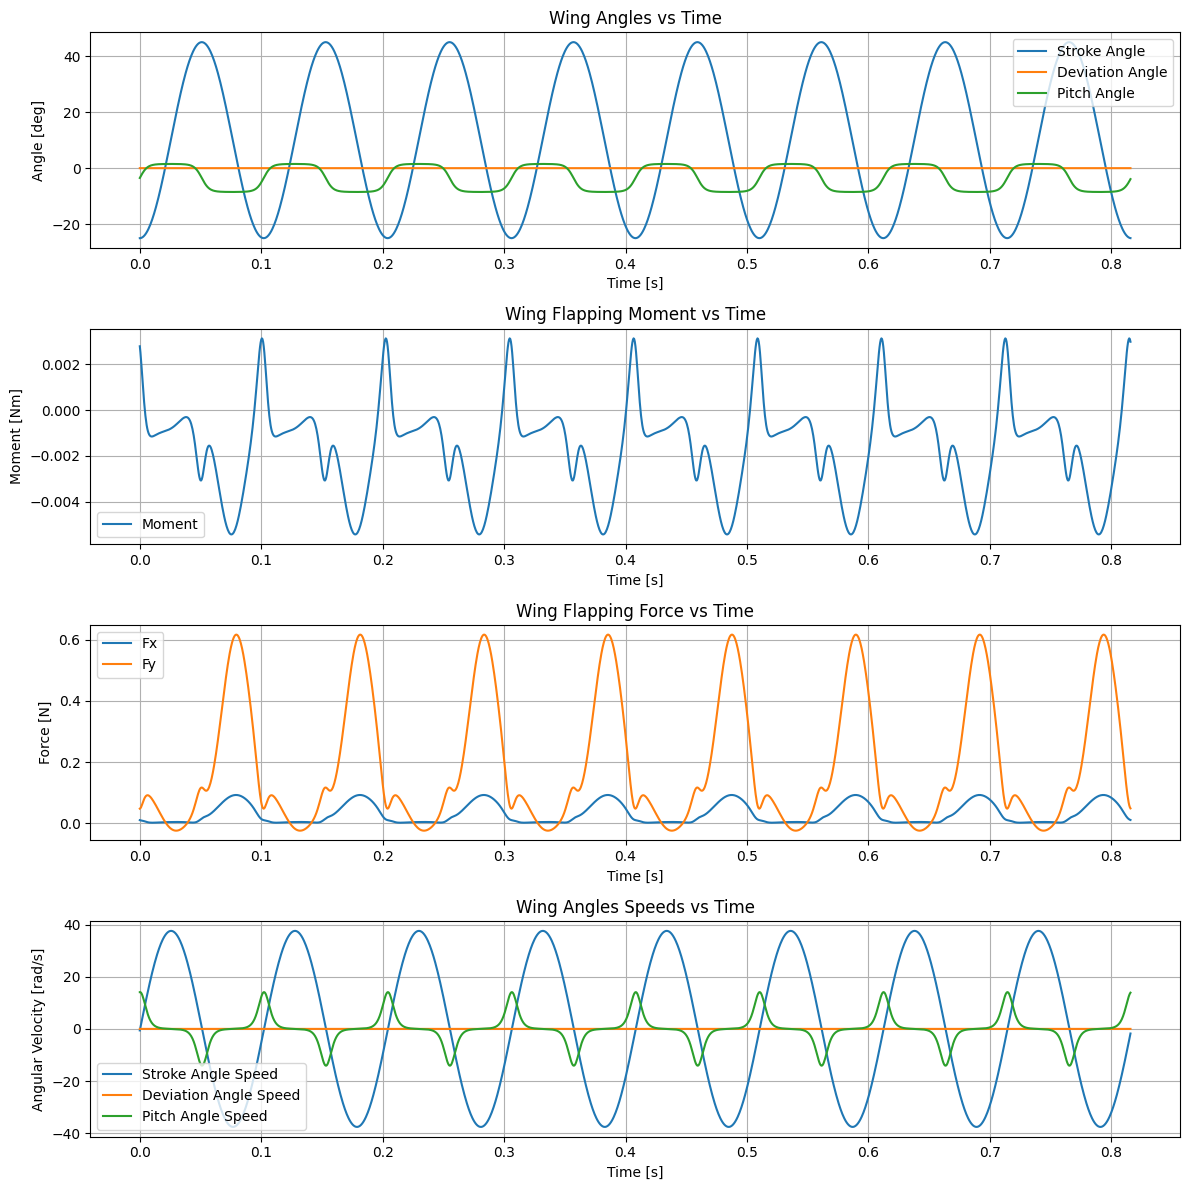

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(4, 1, 1)
plt.title("Wing Angles vs Time")
plt.plot(tArr, np.degrees(wing_angles[:, 0]), label="Stroke Angle")
plt.plot(tArr, np.degrees(wing_angles[:, 1]), label="Deviation Angle")
plt.plot(tArr, np.degrees(wing_angles[:, 2]), label="Pitch Angle")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Angle [deg]")
plt.grid()

plt.subplot(4, 1, 2)
plt.title("Wing Flapping Moment vs Time")
plt.plot(tArr, wing_moment[:, 0], label="Moment")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Moment [Nm]")
plt.grid()

plt.subplot(4, 1, 3)
plt.title("Wing Flapping Force vs Time")
plt.plot(tArr, wing_force[:, 0], label="Fx")
plt.plot(tArr, wing_force[:, 1], label="Fy")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Force [N]")
plt.grid()

plt.subplot(4, 1, 4)
plt.title("Wing Angles Speeds vs Time")
plt.plot(tArr, (wing_angle_vel[:, 0]), label="Stroke Angle Speed")
plt.plot(tArr, (wing_angle_vel[:, 1]), label="Deviation Angle Speed")
plt.plot(tArr, (wing_angle_vel[:, 2]), label="Pitch Angle Speed")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Angular Velocity [rad/s]")
plt.grid()

plt.tight_layout()

In [ ]:
print(sum(wing_moment)/len(wing_moment))
print(sum(wing_force[:, 1])/len(wing_moment))
print(sum(wing_force[:, 0])/len(wing_moment))
print(wing_force[1, 1])
print(np.degrees(wing_angles[399, 2]))
print(np.degrees(wing_angles[199, 2]))
print(np.degrees(wing_angles[200, 2]))

[-0.00179432]
0.0827436495023604
-0.0989845957799117
0.13701130977417983
1.2411742078781676
1.2411742078781676
0.0


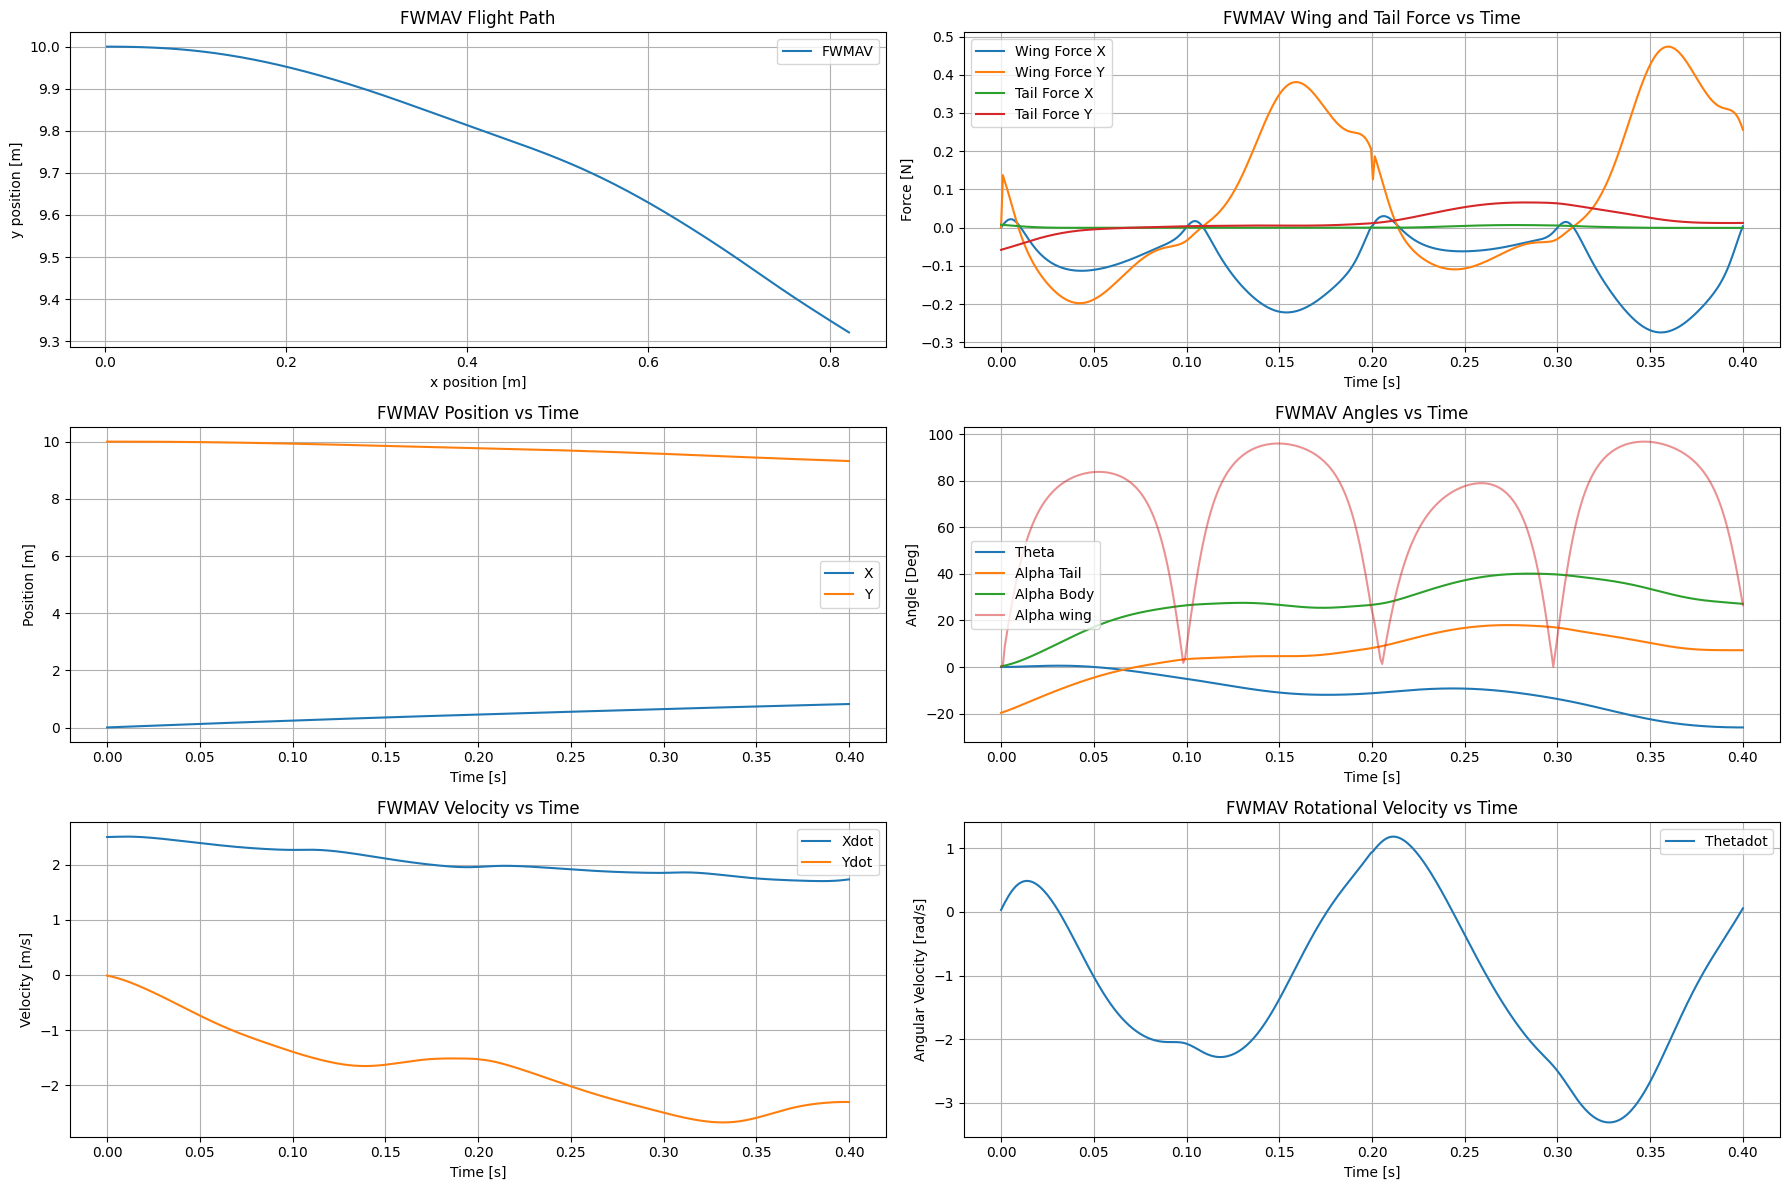

In [ ]:
def plot_figures(t, results, wing_force, tail_force):
    plt.figure(figsize=(18, 12))

    plt.subplot(3, 2, 1)
    plt.title("FWMAV Flight Path")
    plt.plot(results[:, 0], results[:, 1], label="FWMAV")
    plt.legend()
    plt.xlabel("x position [m]")
    plt.ylabel("y position [m]")
    plt.grid()

    plt.subplot(3, 2, 3)
    plt.title("FWMAV Position vs Time")
    plt.plot(t, results[:, 0], label="X")
    plt.plot(t, results[:, 1], label="Y")
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Position [m]")
    plt.grid()

    plt.subplot(3, 2, 5)
    plt.title("FWMAV Velocity vs Time")
    plt.plot(t, results[:, 3], label="Xdot")
    plt.plot(t, results[:, 4], label="Ydot")
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Velocity [m/s]")
    plt.grid()

    plt.subplot(3, 2, 4)
    plt.title("FWMAV Angles vs Time")
    plt.plot(t, np.degrees(results[:, 2]), label="Theta")
    plt.plot(t, np.degrees(tail_force[2, :]), label="Alpha Tail")
    #plt.plot(t, np.degrees(results[:, 2] - np.arctan2(results[:, 4] + results[:, 5]*r_tail*np.cos(results[:, 2]), results[:, 3] + -results[:, 5]*r_tail*np.sin(results[:, 2]))- angle_tail), label="Alpha tail")
    #plt.plot(t, np.degrees(results[:, 2] - np.arctan2(results[:, 4] + results[:, 5]*r_tail*np.cos(results[:, 2]), results[:, 3] + -results[:, 5]*r_tail*np.sin(results[:, 2]))), label="Alpha Body")
    plt.plot(t, np.degrees(results[:, 2] - np.arctan2(results[:, 4], results[:, 3])), label="Alpha Body")
    plt.plot(t, np.degrees(alpha_Arr), alpha=0.5, label="Alpha wing")
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Angle [Deg]")
    plt.grid()

    plt.subplot(3, 2, 6)
    plt.title("FWMAV Rotational Velocity vs Time")
    plt.plot(t, results[:, 5], label="Thetadot")
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Angular Velocity [rad/s]")
    plt.grid()

    plt.subplot(3, 2, 2)
    plt.title("FWMAV Wing and Tail Force vs Time")
    #plt.plot(result.t, np.degrees(result.y[2, :] - np.arctan2(-result.y[4, :], result.y[3, :])), label="Alpha")
    plt.plot(t, wing_force[:, 0], label="Wing Force X")
    plt.plot(t, wing_force[:, 1], label="Wing Force Y")
    plt.plot(t, tail_force[0, :], label="Tail Force X")
    plt.plot(t, tail_force[1, :], label="Tail Force Y")
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Force [N]")
    plt.grid()

    plt.tight_layout()
    plt.show()

tail_force = aero_force(tArr, results[:,2], results[:,3], results[:,4], results[:,5])
plot_figures(tArr, results, wing_force, tail_force)

#Visualization


In [ ]:
print(results[-1,:])
print(np.degrees(11.85727)%360)
print(np.degrees(tail_force[2,-200]))

[-2.49341286 -4.32760929 11.85727652 -1.69907796 -2.92432793 -4.53297571]
319.37152754708563
358.5197563930193


#Equations of Motion
Below are the equations of motion for the 2D simulation. $u(t)$ represent the flapping force, $\theta$ is the pitch of the rod, $f_{y-aero}$ and $f_{x-aero}$ represent the aerodynamic forces of the tail in the body frame, $g$ is the force of gravity, and $r_{wing}$ and $r_{tail}$ is the distance from the COM where the forces occur.
$$\ddot{x} = {(u(t)+f_{y-aero})*-sin(\theta) + f_{x-aero}*cos(\theta) \over m}$$
$$\ddot{y} = {-mg +(u(t)+f_{y-aero})*cos(\theta) + f_{x-aero}*sin(\theta) \over m}$$
$$\ddot{\theta} = {r_{wing}*u(t) + r_{tail}*f_{y-aero} \over J_z}$$

The aerodynamic force calculations for the tail are shown below. First the velocity at the tail is calculated as a function of the COM velocity as well  as the angular rotation of the body. Then the angle of atack is calculated as a function of $\theta$, $\dot{x}_{tail}$, and $\dot{y}_{tail}$. The dynamic force $q_{dynamic}$ is a function of $\rho$ (the air density), $S_{tail}$ (the surface area of the tail, $\dot{x}_{tail}$, and $\dot{y}_{tail}$. The aerocdynamic coefficients are functions of $\alpha$ and are based on the flat plate approximations for angles up to $10^\circ$. The aerodynamic forces are then converted into the body frame.
$$\dot{x}_{tail}= \dot{x}_{body} + \dot{\theta}* r_{tail} *-sin(\theta)$$
$$\dot{y}_{tail}= \dot{y}_{body} + \dot{\theta}* r_{tail} *cos(\theta)$$
$$\alpha = \theta - tan^{-1}({\dot{y}_{tail} \over \dot{x}_{tail}})$$
$$q_{dynamic}=0.5 *\rho *(\dot{x}_{tail}^2 + \dot{y}_{tail}^2)*S_{tail}$$
$$C_D=|1.28sin(\alpha)|$$
$$C_L=2 \pi \alpha$$
$$f_{drag}= C_D * q_{dynamic}$$
$$f_{lift}= C_L * q_{dynamic}$$

$$f_{y-aero}= f_{drag} * sin(\alpha) + f_{lift} * cos(\alpha)$$
$$f_{x-aero}= -f_{drag} * cos(\alpha) + f_{lift} * sin(\alpha)$$

In [ ]:
freq = 10
amp = 60
Ti = 0
Tf = 5
r = -0.05        #location from COM to where force is
r_tail = -1    #location from COM to where tail is
m = 1
g = 9.81*1.0
rho = 1.2682
L = 2
H = 0.2

angle_tail = np.radians(30)
S_tail = 0.05       #surface area
l_tail = 0.5        #tail length
AR_tail = l_tail**2/S_tail
e = 0.9             #oswald efficiency
M = 25              #for blending function
alpha0 = 0.0          #for blending function

Jx = 1/12*m*(L**2+H**2)
Jy = 1/12*m*(H**2)
Jz = 1/12*m*(L**2)
t_eval = np.linspace(Ti, Tf, 500)

# this one could be any other function of time
def u_t(t):
    #t = t%(1/freq)
    i = int((t) / (1/freq) * 99)

    #interp1 in matlab

    vals = [[ 1.28161531e-47], [ 1.28161531e-47], [ 1.36393701e-03], [ 1.62804361e-02],
            [ 7.26246088e-02], [ 2.12557593e-01], [ 4.90281689e-01], [ 9.68945535e-01],
            [ 1.71672279e+00], [ 2.80213727e+00], [ 4.28877643e+00], [ 6.22961832e+00],
            [ 8.66128642e+00], [ 1.15986288e+01], [ 1.50300799e+01], [ 1.89142897e+01],
            [ 2.31784797e+01], [ 2.77189110e+01], [ 3.24037046e+01], [ 3.70780720e+01],
            [ 4.15717826e+01], [ 4.57084612e+01], [ 4.93160856e+01], [ 5.22378813e+01],
            [ 5.43427101e+01], [ 5.55340442e+01], [ 5.57567083e+01], [ 5.50007642e+01],
            [ 5.33021723e+01], [ 5.07401732e+01], [ 4.74316445e+01], [ 4.35229684e+01],
            [ 3.91801643e+01], [ 3.45781654e+01], [ 2.98901469e+01], [ 2.52777476e+01],
            [ 2.08828744e+01], [ 1.68215784e+01], [ 1.31802583e+01], [ 1.00142198e+01],
            [ 7.34841882e+00], [ 5.18006313e+00], [ 3.48264811e+00], [ 2.21096062e+00],
            [ 1.30659382e+00], [ 7.03563386e-01], [ 3.33689000e-01], [ 1.31488666e-01],
            [ 3.84159014e-02], [ 6.34058542e-03], [ 2.27488860e-04], [-2.69006788e-31],
            [-1.59142077e-03], [-1.71866390e-02], [-7.46491094e-02], [-2.16119231e-01],
            [-4.95767884e-01], [-9.76699800e-01], [-1.72703050e+00], [-2.81521009e+00],
            [-4.30473614e+00], [-6.24848113e+00], [-8.68294901e+00], [-1.16228577e+01],
            [-1.50565061e+01], [-1.89424087e+01], [-2.32076601e+01], [-2.77484106e+01],
            [-3.24326950e+01], [-3.71056710e+01], [-4.15970923e+01], [-4.57306111e+01],
            [-4.93342761e+01], [-5.22514267e+01], [-5.43510764e+01], [-5.55368792e+01],
            [-5.57538621e+01], [-5.49922979e+01], [-5.32883545e+01], [-5.07214644e+01],
            [-4.74086708e+01], [-4.34964869e+01], [-3.91510224e+01], [-3.45472572e+01],
            [-2.98583704e+01], [-2.52459644e+01], [-2.08518749e+01], [-1.67920543e+01],
            [-1.31527828e+01], [-9.98923590e+00], [-7.32623554e+00], [-5.16085816e+00],
            [-3.46647595e+00], [-2.19776460e+00], [-1.29622044e+00], [-6.95777714e-01],
            [-3.28189817e-01], [-1.27922664e-01], [-3.63903395e-02], [-5.43423792e-03],
            [ 1.33133673e-16]]
    #return vals[i][0]
    return 1*(amp*np.sin(2*np.pi*freq*t)+10)



def aero_force(t, theta, xdot, ydot, thetadot):
    # Ensure that all inputs are NumPy arrays
    t = np.array(t)
    theta = np.array(theta)
    xdot = np.array(xdot)
    ydot = np.array(ydot)
    thetadot = np.array(thetadot)

    # Calculate tail_xdot and tail_ydot for arrays
    tail_ydot = ydot + thetadot * r_tail * np.cos(theta)
    tail_xdot = xdot + thetadot * r_tail * -np.sin(theta)
    #print(f"velocity: {tail_xdot} and {tail_ydot}")
    # Handle the case when theta is an array
    if theta.size > 1:
        theta = np.where(theta > 0, theta % (2 * np.pi), theta % (-2 * np.pi))
    else:
        if np.sign(theta) == 1:
            theta = theta % (2 * np.pi)
        else:
            theta = theta % (-2 * np.pi)

    alpha = theta - np.arctan2(tail_ydot, tail_xdot) - angle_tail
    #print(np.degrees(alpha))
    q_dynamic = 0.5 * rho * (tail_xdot ** 2 + tail_ydot ** 2) * S_tail

    # Sigma --> Blending Function
    sigma_num = (1 + np.exp(-M*(alpha - alpha0)) + np.exp(M*(alpha + alpha0)))
    sigma_denom = (1 + np.exp(-M*(alpha - alpha0))) * (1 + np.exp(M*(alpha + alpha0)))
    sigma = sigma_num / sigma_denom

    CL_0 = 0 #0.23
    CL_alpha = np.pi*AR_tail/(1+np.sqrt(1 + (AR_tail/2)**2))
    CD_alpha = ((CL_0 + CL_alpha*alpha)**2)/(np.pi*e*AR_tail)


    CL = ((1 - sigma)*(CL_0 + CL_alpha*alpha)) + ((sigma)*2*np.sign(alpha)*(np.sin(alpha)**2)*np.cos(alpha))
    CD = CD_alpha

    #CL = np.sin(2*alpha) #2 * np.pi * alpha
    #CD = 1-np.cos(2*alpha) #np.abs(1.28 * np.sin(alpha))
    f_lift = CL * q_dynamic
    f_drag = CD * q_dynamic
    fx = -f_drag * np.cos(alpha) + (f_lift * np.sin(alpha))
    fy = f_drag * np.sin(alpha) + (f_lift * np.cos(alpha))
    # Handle the case when inputs were scalars
    if isinstance(t, (int, float)):
        return fx.item(), fy.item(), alpha.item()  # Convert scalars back to Python scalars
    else:
        return np.array([fx, fy, alpha])  # Return NumPy arrays for arrays


def f(t, state):
    dx_dt = [0, 0, 0, 0, 0, 0]          #xdot, ydot, thetadot, xddot, yddot, thetaddot
    x, y, theta, xdot, ydot, thetadot = state
    fx_aero, fy_aero, alpha = aero_force(t, theta, xdot, ydot, thetadot)
    dx_dt[0] = xdot
    dx_dt[1] = ydot
    dx_dt[2] = thetadot
    dx_dt[3] = ((u_t(t)+fy_aero)*-np.sin(theta) + fx_aero*np.cos(theta))/m
    dx_dt[4] =  (-m*g + (u_t(t)+fy_aero)*np.cos(theta) + fx_aero*np.sin(theta))/m
    dx_dt[5] = (r*u_t(t)+ r_tail*fy_aero)/Jz
    return dx_dt
# y0 is our initial state
t_span = (Ti, Tf)
y0 = [0, 0, np.radians(np.degrees(np.arctan2(-amp/(m*2*np.pi*freq), 5))), 5, -amp/(m*2*np.pi*freq), -amp*r/(Jz*2*np.pi*freq)]
#y0 = [0, 10, np.radians(np.degrees(np.arctan2(0, 5))), 5, 0, 0]
result = solve_ivp(f, (Ti, Tf), y0, t_eval=t_eval, method = 'Radau')        #"LSODA" 'RK45' 'DOP853' 'Radau' 'BDF' 'RK23'


def plot_figures(result):
    plt.figure(figsize=(18, 12))

    plt.subplot(3, 2, 1)
    plt.plot(result.y[0, :], result.y[1, :], label="Y")
    plt.legend()
    plt.xlabel("x position [m]")
    plt.ylabel("y position [m]")
    plt.grid()

    plt.subplot(3, 2, 3)
    plt.plot(result.t, result.y[0, :], label="X")
    plt.plot(result.t, result.y[1, :], label="Y")
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Position [m]")
    plt.grid()

    plt.subplot(3, 2, 5)
    plt.plot(result.t, result.y[3, :], label="Xdot")
    plt.plot(result.t, result.y[4, :], label="Ydot")
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Velocity [m/s]")
    plt.grid()

    plt.subplot(3, 2, 4)
    plt.plot(result.t, np.degrees(result.y[2, :]), label="Theta")
    plt.plot(result.t, np.degrees(result.y[2, :] - np.arctan2(result.y[4, :] + result.y[5, :]*r_tail*np.cos(result.y[2, :]), result.y[3, :] + -result.y[5, :]*r_tail*np.sin(result.y[2, :]))- angle_tail), label="alpha")
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Angle [Deg]")
    plt.grid()

    plt.subplot(3, 2, 6)
    plt.plot(result.t, result.y[5, :], label="Thetadot")
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Angular Velocity [rad/s]")
    plt.grid()

    plt.subplot(3, 2, 2)
    #plt.plot(result.t, np.degrees(result.y[2, :] - np.arctan2(-result.y[4, :], result.y[3, :])), label="Alpha")
    plt.plot(result.t, amp*np.sin(2*np.pi*freq*t_eval)+10, label="Wing Force")
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Force [N]")
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_figures(result)

In [ ]:
ang = 0
print(aero_force(0, np.radians(ang), 1, -amp/(m*2*np.pi*freq), -amp*r/(Jz*2*np.pi*freq)))
print(aero_force(0, np.radians(ang), 1 + -amp*r/(Jz*2*np.pi*freq) * r_tail * -np.sin(np.radians(ang)), -amp/(m*2*np.pi*freq) + -amp*r/(Jz*2*np.pi*freq) * r_tail * np.cos(np.radians(ang)), 0))
#print(np.degrees(np.arctan2(2 * r_tail * np.cos(np.radians(ang)), 2 * r_tail * -np.sin(np.radians(ang)))))
#print(-amp/(m*2*np.pi*freq), -amp*r/(Jz*2*np.pi*freq))
print(1 + -amp*r/(Jz*2*np.pi*freq) * r_tail * -np.sin(np.radians(ang)), -amp/(m*2*np.pi*freq) + -amp*r/(Jz*2*np.pi*freq) * r_tail * np.cos(np.radians(ang)))

#Aerodynamic Coefficient Comparision

In [ ]:
e = 0.9
M = 25
alpha0 = 0.0 #0.47
def aero_coeff_BM(t, theta, xdot, ydot, thetadot):
    # Ensure that all inputs are NumPy arrays
    t = np.array(t)
    theta = np.array(theta)
    xdot = np.array(xdot)
    ydot = np.array(ydot)
    thetadot = np.array(thetadot)

    # Calculate tail_xdot and tail_ydot for arrays
    tail_ydot = ydot + thetadot * r_tail * np.cos(theta)
    tail_xdot = xdot + thetadot * r_tail * -np.sin(theta)
    #print(f"velocity: {tail_xdot} and {tail_ydot}")
    # Handle the case when theta is an array
    if theta.size > 1:
        theta = np.where(theta > 0, theta % (2 * np.pi), theta % (-2 * np.pi))
    else:
        if np.sign(theta) == 1:
            theta = theta % (2 * np.pi)
        else:
            theta = theta % (-2 * np.pi)

    alpha = theta - np.arctan2(tail_ydot, tail_xdot)
    #print(np.degrees(alpha))
    q_dynamic = 0.5 * rho * (tail_xdot ** 2 + tail_ydot ** 2) * S_tail

    # Sigma --> Blending Function
    sigma_num = (1 + np.exp(-M*(alpha - alpha0)) + np.exp(M*(alpha + alpha0)))
    sigma_denom = (1 + np.exp(-M*(alpha - alpha0))) * (1 + np.exp(M*(alpha + alpha0)))
    sigma = sigma_num / sigma_denom

    CL_0 = 0#0.23
    CL_alpha = np.pi*AR_tail/(1+np.sqrt(1 + (AR_tail/2)**2))
    CD_alpha = ((CL_0 + CL_alpha*alpha)**2)/(np.pi*e*AR_tail)


    CL = ((1 - sigma)*(CL_0 + CL_alpha*alpha)) + ((sigma)*2*np.sign(alpha)*(np.sin(alpha)**2)*np.cos(alpha))
    CD = np.minimum(CD_alpha, np.abs(1.28 * np.sin(alpha)))

    #CL = np.sin(2*alpha) #2 * np.pi * alpha
    #CD = 1-np.cos(2*alpha) #np.abs(1.28 * np.sin(alpha))
    f_lift = CL * q_dynamic
    f_drag = CD * q_dynamic
    fx = -f_drag * np.cos(alpha) + (f_lift * np.sin(alpha))
    fy = f_drag * np.sin(alpha) + (f_lift * np.cos(alpha))
    # Handle the case when inputs were scalars
    if isinstance(t, (int, float)):
        return CL.item(), CD.item(), alpha.item(), fx.item(), fy.item()  # Convert scalars back to Python scalars
    else:
        return np.array([CL, CD, alpha, fx, fy])  # Return NumPy arrays for arrays

def aero_coeff_NASA(t, theta, xdot, ydot, thetadot):
    # Ensure that all inputs are NumPy arrays
    t = np.array(t)
    theta = np.array(theta)
    xdot = np.array(xdot)
    ydot = np.array(ydot)
    thetadot = np.array(thetadot)

    # Calculate tail_xdot and tail_ydot for arrays
    tail_ydot = ydot + thetadot * r_tail * np.cos(theta)
    tail_xdot = xdot + thetadot * r_tail * -np.sin(theta)
    #print(f"velocity: {tail_xdot} and {tail_ydot}")
    # Handle the case when theta is an array
    if theta.size > 1:
        theta = np.where(theta > 0, theta % (2 * np.pi), theta % (-2 * np.pi))
    else:
        if np.sign(theta) == 1:
            theta = theta % (2 * np.pi)
        else:
            theta = theta % (-2 * np.pi)

    alpha = theta - np.arctan2(tail_ydot, tail_xdot)
    #print(np.degrees(alpha))
    q_dynamic = 0.5 * rho * (tail_xdot ** 2 + tail_ydot ** 2) * S_tail

    # Sigma --> Blending Function
    sigma_num = (1 + np.exp(-M*(alpha - alpha0)) + np.exp(M*(alpha + alpha0)))
    sigma_denom = (1 + np.exp(-M*(alpha - alpha0))) * (1 + np.exp(M*(alpha + alpha0)))
    sigma = sigma_num / sigma_denom

    CL_0 = 0.23
    CL_alpha = np.pi*AR_tail/(1+np.sqrt(1 + (AR_tail/2)**2))
    CD_alpha = ((CL_0 + CL_alpha*alpha)**2)/(np.pi*e*AR_tail)


    CL = ((1 - sigma)*(CL_0 + CL_alpha*alpha)) + ((sigma)*2*np.sign(alpha)*(np.sin(alpha)**2)*np.cos(alpha))
    CD = CD_alpha

    CL = 2 * np.pi * alpha
    CL = 2*np.sign(alpha)*(np.sin(alpha)**2)*np.cos(alpha)
    CD = np.abs(1.28 * np.sin(alpha))
    f_lift = CL * q_dynamic
    f_drag = CD * q_dynamic
    fx = f_drag * np.cos(alpha) + (-f_lift * np.sin(alpha))
    fy = -f_drag * np.sin(alpha) + (-f_lift * np.cos(alpha))
    # Handle the case when inputs were scalars
    if isinstance(t, (int, float)):
        return CL.item(), CD.item(), alpha.item()  # Convert scalars back to Python scalars
    else:
        return np.array([CL, CD, alpha])  # Return NumPy arrays for arrays

def aero_coeff_AF(t, theta, xdot, ydot, thetadot):
    # Ensure that all inputs are NumPy arrays
    t = np.array(t)
    theta = np.array(theta)
    xdot = np.array(xdot)
    ydot = np.array(ydot)
    thetadot = np.array(thetadot)

    # Calculate tail_xdot and tail_ydot for arrays
    tail_ydot = ydot + thetadot * r_tail * np.cos(theta)
    tail_xdot = xdot + thetadot * r_tail * -np.sin(theta)
    #print(f"velocity: {tail_xdot} and {tail_ydot}")
    # Handle the case when theta is an array
    if theta.size > 1:
        theta = np.where(theta > 0, theta % (2 * np.pi), theta % (-2 * np.pi))
    else:
        if np.sign(theta) == 1:
            theta = theta % (2 * np.pi)
        else:
            theta = theta % (-2 * np.pi)

    alpha = theta - np.arctan2(tail_ydot, tail_xdot)
    #print(np.degrees(alpha))
    q_dynamic = 0.5 * rho * (tail_xdot ** 2 + tail_ydot ** 2) * S_tail

    CL = np.sin(2*alpha) #2 * np.pi * alpha
    CD = 1-np.cos(2*alpha) #np.abs(1.28 * np.sin(alpha))
    f_lift = CL * q_dynamic
    f_drag = CD * q_dynamic
    fx = -f_drag * np.cos(alpha) + (f_lift * np.sin(alpha))
    fy = f_drag * np.sin(alpha) + (f_lift * np.cos(alpha))
    # Handle the case when inputs were scalars
    if isinstance(t, (int, float)):
        return CL.item(), CD.item(), alpha.item()  # Convert scalars back to Python scalars
    else:
        return np.array([CL, CD, alpha])  # Return NumPy arrays for arrays

<ipython-input-39-0b69b4bfd5d6>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1)


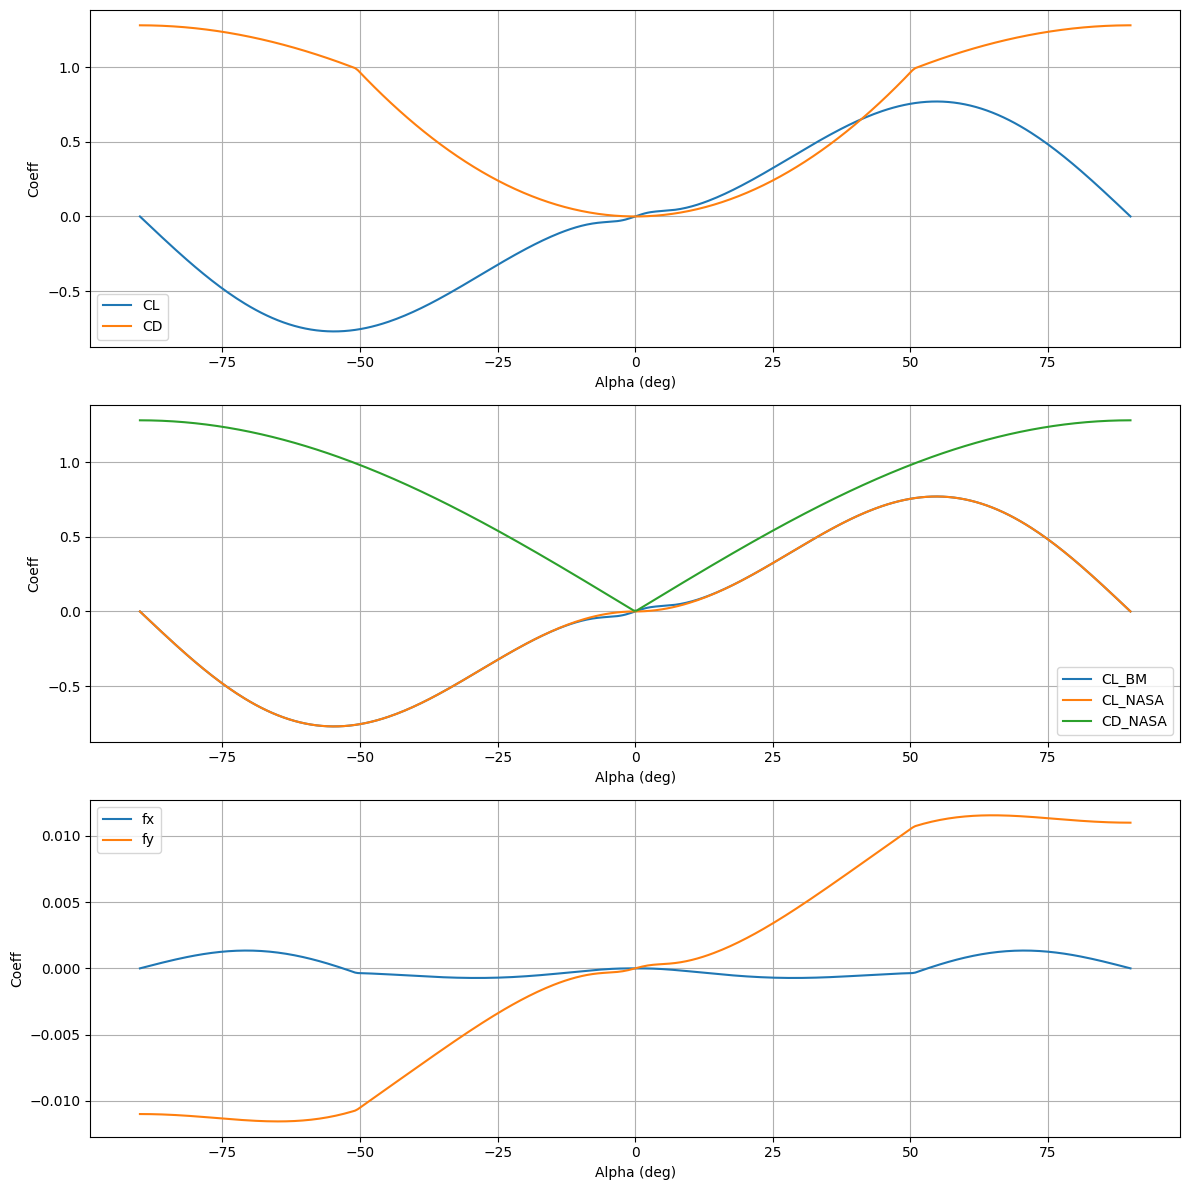

In [ ]:
t = np.linspace(0, 1, 360)
theta = np.linspace(np.radians(-90), np.radians(90), 360)
xdot = np.ones(360)
ydot = 0 * np.ones(360)
thetadot = 0* np.ones(360)
CL_BM, CD_BM, alpha_BM, fx, fy = aero_coeff_BM(t, theta, xdot, ydot, thetadot)
CL_AF, CD_AF, alpha_AF = aero_coeff_AF(t, theta, xdot, ydot, thetadot)
CL_NASA, CD_NASA, alpha_NASA = aero_coeff_NASA(t, theta, xdot, ydot, thetadot)

plt.figure(figsize=(12, 12))
plt.title("beard mclain")
plt.subplot(3, 1, 1)
plt.plot(np.degrees(alpha_BM), CL_BM, label='CL')
plt.plot(np.degrees(alpha_BM), CD_BM, label='CD')
plt.xlabel("Alpha (deg)")
plt.ylabel("Coeff")
plt.grid()
plt.legend()


# plt.subplot(3, 3, 2)
# plt.plot(np.degrees(alpha_BM), CL_NASA, label='CL_NASA')
# plt.plot(np.degrees(alpha_BM), CD_NASA, label='CD_NASA')
# plt.xlabel("Alpha (deg)")
# plt.ylabel("Coeff")
# plt.grid()
# plt.legend()

# plt.subplot(3, 3, 3)
# plt.plot(np.degrees(alpha_BM), CL_AF, label='CL_AF')
# plt.plot(np.degrees(alpha_BM), CD_AF, label='CD_AF')
# plt.xlabel("Alpha (deg)")
# plt.ylabel("Coeff")
# plt.grid()
# plt.legend()

plt.subplot(3, 1, 2)
plt.plot(np.degrees(alpha_BM), CL_BM, label='CL_BM')
plt.plot(np.degrees(alpha_BM), CL_NASA, label='CL_NASA')
plt.plot(np.degrees(alpha_BM), CD_NASA, label='CD_NASA')
plt.xlabel("Alpha (deg)")
plt.ylabel("Coeff")
plt.grid()
plt.legend()

plt.subplot(3, 1, 3)
# plt.plot(np.degrees(alpha_BM), CD_BM, label='CD_BM')
plt.plot(np.degrees(alpha_BM), fx, label='fx')
plt.plot(np.degrees(alpha_BM), fy, label='fy')
# plt.plot(np.degrees(alpha_BM), CD_NASA, label='CD_NASA')
# plt.plot(np.degrees(alpha_BM), CD_AF, label='CD_AF')
plt.xlabel("Alpha (deg)")
plt.ylabel("Coeff")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

#Curve fitting for wing flapping simulation



In [ ]:
for t in t_eval:
    print(f"At time {t}, u_t = {u_t(t)}")

[ 3.69613029e+01  6.30209749e+01 -1.14559753e-01 -6.76699049e+01
  8.36435257e-02  1.55430045e+00  9.14454225e-02  6.22101137e+02
  8.22046231e-01]


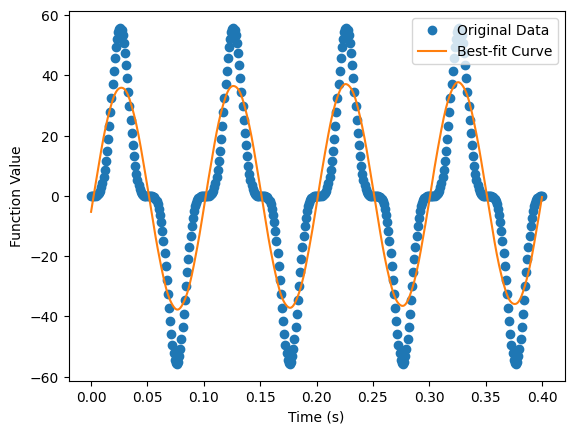

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Given time values
t = np.linspace(0, 0.4, 400)

# Given data values
data = np.array([[ 1.28161531e-47], [ 1.28161531e-47], [ 1.36393701e-03], [ 1.62804361e-02],
            [ 7.26246088e-02], [ 2.12557593e-01], [ 4.90281689e-01], [ 9.68945535e-01],
            [ 1.71672279e+00], [ 2.80213727e+00], [ 4.28877643e+00], [ 6.22961832e+00],
            [ 8.66128642e+00], [ 1.15986288e+01], [ 1.50300799e+01], [ 1.89142897e+01],
            [ 2.31784797e+01], [ 2.77189110e+01], [ 3.24037046e+01], [ 3.70780720e+01],
            [ 4.15717826e+01], [ 4.57084612e+01], [ 4.93160856e+01], [ 5.22378813e+01],
            [ 5.43427101e+01], [ 5.55340442e+01], [ 5.57567083e+01], [ 5.50007642e+01],
            [ 5.33021723e+01], [ 5.07401732e+01], [ 4.74316445e+01], [ 4.35229684e+01],
            [ 3.91801643e+01], [ 3.45781654e+01], [ 2.98901469e+01], [ 2.52777476e+01],
            [ 2.08828744e+01], [ 1.68215784e+01], [ 1.31802583e+01], [ 1.00142198e+01],
            [ 7.34841882e+00], [ 5.18006313e+00], [ 3.48264811e+00], [ 2.21096062e+00],
            [ 1.30659382e+00], [ 7.03563386e-01], [ 3.33689000e-01], [ 1.31488666e-01],
            [ 3.84159014e-02], [ 6.34058542e-03], [ 2.27488860e-04], [-2.69006788e-31],
            [-1.59142077e-03], [-1.71866390e-02], [-7.46491094e-02], [-2.16119231e-01],
            [-4.95767884e-01], [-9.76699800e-01], [-1.72703050e+00], [-2.81521009e+00],
            [-4.30473614e+00], [-6.24848113e+00], [-8.68294901e+00], [-1.16228577e+01],
            [-1.50565061e+01], [-1.89424087e+01], [-2.32076601e+01], [-2.77484106e+01],
            [-3.24326950e+01], [-3.71056710e+01], [-4.15970923e+01], [-4.57306111e+01],
            [-4.93342761e+01], [-5.22514267e+01], [-5.43510764e+01], [-5.55368792e+01],
            [-5.57538621e+01], [-5.49922979e+01], [-5.32883545e+01], [-5.07214644e+01],
            [-4.74086708e+01], [-4.34964869e+01], [-3.91510224e+01], [-3.45472572e+01],
            [-2.98583704e+01], [-2.52459644e+01], [-2.08518749e+01], [-1.67920543e+01],
            [-1.31527828e+01], [-9.98923590e+00], [-7.32623554e+00], [-5.16085816e+00],
            [-3.46647595e+00], [-2.19776460e+00], [-1.29622044e+00], [-6.95777714e-01],
            [-3.28189817e-01], [-1.27922664e-01], [-3.63903395e-02], [-5.43423792e-03],
            [ 1.28161531e-47], [ 1.28161531e-47], [ 1.36393701e-03], [ 1.62804361e-02],
            [ 7.26246088e-02], [ 2.12557593e-01], [ 4.90281689e-01], [ 9.68945535e-01],
            [ 1.71672279e+00], [ 2.80213727e+00], [ 4.28877643e+00], [ 6.22961832e+00],
            [ 8.66128642e+00], [ 1.15986288e+01], [ 1.50300799e+01], [ 1.89142897e+01],
            [ 2.31784797e+01], [ 2.77189110e+01], [ 3.24037046e+01], [ 3.70780720e+01],
            [ 4.15717826e+01], [ 4.57084612e+01], [ 4.93160856e+01], [ 5.22378813e+01],
            [ 5.43427101e+01], [ 5.55340442e+01], [ 5.57567083e+01], [ 5.50007642e+01],
            [ 5.33021723e+01], [ 5.07401732e+01], [ 4.74316445e+01], [ 4.35229684e+01],
            [ 3.91801643e+01], [ 3.45781654e+01], [ 2.98901469e+01], [ 2.52777476e+01],
            [ 2.08828744e+01], [ 1.68215784e+01], [ 1.31802583e+01], [ 1.00142198e+01],
            [ 7.34841882e+00], [ 5.18006313e+00], [ 3.48264811e+00], [ 2.21096062e+00],
            [ 1.30659382e+00], [ 7.03563386e-01], [ 3.33689000e-01], [ 1.31488666e-01],
            [ 3.84159014e-02], [ 6.34058542e-03], [ 2.27488860e-04], [-2.69006788e-31],
            [-1.59142077e-03], [-1.71866390e-02], [-7.46491094e-02], [-2.16119231e-01],
            [-4.95767884e-01], [-9.76699800e-01], [-1.72703050e+00], [-2.81521009e+00],
            [-4.30473614e+00], [-6.24848113e+00], [-8.68294901e+00], [-1.16228577e+01],
            [-1.50565061e+01], [-1.89424087e+01], [-2.32076601e+01], [-2.77484106e+01],
            [-3.24326950e+01], [-3.71056710e+01], [-4.15970923e+01], [-4.57306111e+01],
            [-4.93342761e+01], [-5.22514267e+01], [-5.43510764e+01], [-5.55368792e+01],
            [-5.57538621e+01], [-5.49922979e+01], [-5.32883545e+01], [-5.07214644e+01],
            [-4.74086708e+01], [-4.34964869e+01], [-3.91510224e+01], [-3.45472572e+01],
            [-2.98583704e+01], [-2.52459644e+01], [-2.08518749e+01], [-1.67920543e+01],
            [-1.31527828e+01], [-9.98923590e+00], [-7.32623554e+00], [-5.16085816e+00],
            [-3.46647595e+00], [-2.19776460e+00], [-1.29622044e+00], [-6.95777714e-01],
            [-3.28189817e-01], [-1.27922664e-01], [-3.63903395e-02], [-5.43423792e-03],
            [ 1.28161531e-47], [ 1.28161531e-47], [ 1.36393701e-03], [ 1.62804361e-02],
            [ 7.26246088e-02], [ 2.12557593e-01], [ 4.90281689e-01], [ 9.68945535e-01],
            [ 1.71672279e+00], [ 2.80213727e+00], [ 4.28877643e+00], [ 6.22961832e+00],
            [ 8.66128642e+00], [ 1.15986288e+01], [ 1.50300799e+01], [ 1.89142897e+01],
            [ 2.31784797e+01], [ 2.77189110e+01], [ 3.24037046e+01], [ 3.70780720e+01],
            [ 4.15717826e+01], [ 4.57084612e+01], [ 4.93160856e+01], [ 5.22378813e+01],
            [ 5.43427101e+01], [ 5.55340442e+01], [ 5.57567083e+01], [ 5.50007642e+01],
            [ 5.33021723e+01], [ 5.07401732e+01], [ 4.74316445e+01], [ 4.35229684e+01],
            [ 3.91801643e+01], [ 3.45781654e+01], [ 2.98901469e+01], [ 2.52777476e+01],
            [ 2.08828744e+01], [ 1.68215784e+01], [ 1.31802583e+01], [ 1.00142198e+01],
            [ 7.34841882e+00], [ 5.18006313e+00], [ 3.48264811e+00], [ 2.21096062e+00],
            [ 1.30659382e+00], [ 7.03563386e-01], [ 3.33689000e-01], [ 1.31488666e-01],
            [ 3.84159014e-02], [ 6.34058542e-03], [ 2.27488860e-04], [-2.69006788e-31],
            [-1.59142077e-03], [-1.71866390e-02], [-7.46491094e-02], [-2.16119231e-01],
            [-4.95767884e-01], [-9.76699800e-01], [-1.72703050e+00], [-2.81521009e+00],
            [-4.30473614e+00], [-6.24848113e+00], [-8.68294901e+00], [-1.16228577e+01],
            [-1.50565061e+01], [-1.89424087e+01], [-2.32076601e+01], [-2.77484106e+01],
            [-3.24326950e+01], [-3.71056710e+01], [-4.15970923e+01], [-4.57306111e+01],
            [-4.93342761e+01], [-5.22514267e+01], [-5.43510764e+01], [-5.55368792e+01],
            [-5.57538621e+01], [-5.49922979e+01], [-5.32883545e+01], [-5.07214644e+01],
            [-4.74086708e+01], [-4.34964869e+01], [-3.91510224e+01], [-3.45472572e+01],
            [-2.98583704e+01], [-2.52459644e+01], [-2.08518749e+01], [-1.67920543e+01],
            [-1.31527828e+01], [-9.98923590e+00], [-7.32623554e+00], [-5.16085816e+00],
            [-3.46647595e+00], [-2.19776460e+00], [-1.29622044e+00], [-6.95777714e-01],
            [-3.28189817e-01], [-1.27922664e-01], [-3.63903395e-02], [-5.43423792e-03],
            [ 1.28161531e-47], [ 1.28161531e-47], [ 1.36393701e-03], [ 1.62804361e-02],
            [ 7.26246088e-02], [ 2.12557593e-01], [ 4.90281689e-01], [ 9.68945535e-01],
            [ 1.71672279e+00], [ 2.80213727e+00], [ 4.28877643e+00], [ 6.22961832e+00],
            [ 8.66128642e+00], [ 1.15986288e+01], [ 1.50300799e+01], [ 1.89142897e+01],
            [ 2.31784797e+01], [ 2.77189110e+01], [ 3.24037046e+01], [ 3.70780720e+01],
            [ 4.15717826e+01], [ 4.57084612e+01], [ 4.93160856e+01], [ 5.22378813e+01],
            [ 5.43427101e+01], [ 5.55340442e+01], [ 5.57567083e+01], [ 5.50007642e+01],
            [ 5.33021723e+01], [ 5.07401732e+01], [ 4.74316445e+01], [ 4.35229684e+01],
            [ 3.91801643e+01], [ 3.45781654e+01], [ 2.98901469e+01], [ 2.52777476e+01],
            [ 2.08828744e+01], [ 1.68215784e+01], [ 1.31802583e+01], [ 1.00142198e+01],
            [ 7.34841882e+00], [ 5.18006313e+00], [ 3.48264811e+00], [ 2.21096062e+00],
            [ 1.30659382e+00], [ 7.03563386e-01], [ 3.33689000e-01], [ 1.31488666e-01],
            [ 3.84159014e-02], [ 6.34058542e-03], [ 2.27488860e-04], [-2.69006788e-31],
            [-1.59142077e-03], [-1.71866390e-02], [-7.46491094e-02], [-2.16119231e-01],
            [-4.95767884e-01], [-9.76699800e-01], [-1.72703050e+00], [-2.81521009e+00],
            [-4.30473614e+00], [-6.24848113e+00], [-8.68294901e+00], [-1.16228577e+01],
            [-1.50565061e+01], [-1.89424087e+01], [-2.32076601e+01], [-2.77484106e+01],
            [-3.24326950e+01], [-3.71056710e+01], [-4.15970923e+01], [-4.57306111e+01],
            [-4.93342761e+01], [-5.22514267e+01], [-5.43510764e+01], [-5.55368792e+01],
            [-5.57538621e+01], [-5.49922979e+01], [-5.32883545e+01], [-5.07214644e+01],
            [-4.74086708e+01], [-4.34964869e+01], [-3.91510224e+01], [-3.45472572e+01],
            [-2.98583704e+01], [-2.52459644e+01], [-2.08518749e+01], [-1.67920543e+01],
            [-1.31527828e+01], [-9.98923590e+00], [-7.32623554e+00], [-5.16085816e+00],
            [-3.46647595e+00], [-2.19776460e+00], [-1.29622044e+00], [-6.95777714e-01],
            [-3.28189817e-01], [-1.27922664e-01], [-3.63903395e-02], [-5.43423792e-03]])

# Define the function to fit (polynomial of degree 5)
# def func(t, a, b, c, d, e, f, g, h, i, j, k, l, m):
#     return  a*np.sin(b*t) + c * np.sin(d*t)**2 + e * np.sin(f*t)**3 + g + h*t**1 + i*t**2 + j*t**3 + k*t**3 + l*t**4 + m*t**5

#initial_guess = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1, 1, 1, 1, 1, 1]

def func(t, a1, b1, c1, a2, b2, c2, a3, b3, c3):
    return a1 * np.sin(b1 * t + c1) + a2 * np.cos(b2 * t + c2) + a3 * np.sin(b3 * t + c3)

# Perform the curve fit with an initial guess
initial_guess = [60, 2*np.pi*10, 0.0, 60.0, 2*np.pi*1, 0.0, 60.0, 2*np.pi*100, 0.0]

params, covariance = curve_fit(func, t, data.ravel(), p0=initial_guess, maxfev=10000000)
#params, covariance = curve_fit(func, t, data.ravel(), maxfev=100000)

# Generate fitted curve values
fit_curve = func(t, *params)
print(params)
# Plot the original data and the best-fit curve
plt.plot(t, data, 'o', label='Original Data')
plt.plot(t, fit_curve, label='Best-fit Curve')

plt.xlabel('Time (s)')
plt.ylabel('Function Value')
plt.legend()
plt.show()